### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhoutee score


1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process

In [9]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [10]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [11]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-07 08:41:53,464 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=9cad1ecc8ef94b40a72de5b2607bb3fb
2025-05-07 08:41:53,723 - AInewsbot - INFO - thread_id: 9cad1ecc8ef94b40a72de5b2607bb3fb


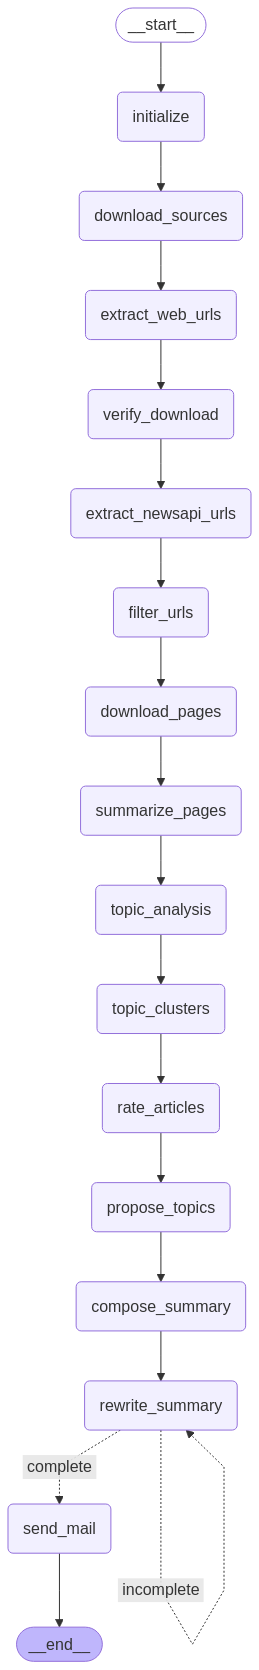

In [27]:
before_date = None
# before_date = '2025-05-03 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [28]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-07 08:41:54,734 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-07 08:41:54,735 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-07 08:41:54,735 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-07 08:41:54,735 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-07 08:41:54,735 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-07 08:41:54,736 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-07 08:41:54,736 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-07 08:41:55,487 - AInewsbot - INFO - parse_file - found 250 raw links
2025-05-07 08:41:55,490 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-07 08:41:55,490 - AInewsbot - INFO - 37 links found
2025-05-07 08:41:55,490 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-07 08:41:55,518 - AInewsbot - INFO - parse_file - found 217 raw links
2025-05-07 08:41:55,521 - AInewsbot - INFO - parse_file - found 22 filtered links
2025-05-07 08:41:55,521 - AInewsbot - INFO - 22 links found
2025-05-07 08:41:55,521 - AInewsbot - INFO - FT -> htmldata/FT.html
2025-05-07 08:41:55,559 - AInewsbot - INFO - parse_file - found 487 raw links
2025-05-07 08:41:55,564 - AInewsbot - INFO - parse_file - found 119 filtered links
2025-05-07 08:41:55,564 - AInewsbot - INFO - 119 links found
2025-05-07 08:41:55,564 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly_AI.html
2025-05-07 08:41:55,607 - AInewsbot - INFO - parse_file - found 137 raw links
2025-05-07 08:

,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,22
FT,66
Feedly AI,32
Hacker News 1,25
Hacker News 2,24
HackerNoon,17
New York Times,18


2025-05-07 08:41:56,013 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,22
FT,66
Feedly AI,32
Hacker News 1,25
Hacker News 2,24
HackerNoon,17
New York Times,18


2025-05-07 08:41:56,018 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-06T08:41:56 from NewsAPI


,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,22
FT,66
Feedly AI,32
Hacker News 1,25
Hacker News 2,24
HackerNoon,17
New York Times,18


2025-05-07 08:41:56,305 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-07 08:41:57,010 - AInewsbot - INFO - URLs in orig_df: 856
2025-05-07 08:41:57,013 - AInewsbot - INFO - Existing URLs in DB: 255272
2025-05-07 08:41:57,078 - AInewsbot - INFO - New URLs in df filtered by URL: 263
2025-05-07 08:41:57,224 - AInewsbot - INFO - Existing src+title: 32
2025-05-07 08:41:57,225 - AInewsbot - INFO - New URLs in df filtered by src+title: 231
2025-05-07 08:41:57,239 - AInewsbot - INFO - Found 231 unique new headlines
2025-05-07 08:41:57,243 - AInewsbot - INFO - Found 226 unique cleaned new headlines
2025-05-07 08:42:06,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:42:06,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:42:07,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:42:07,4

,id
src,
Bloomberg,3
Business Insider,3
FT,4
Feedly AI,26
Hacker News 1,3
HackerNoon,2
New York Times,1
NewsAPI,41
Reddit,1


2025-05-07 08:42:09,678 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-07 08:42:09,694 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-07 08:42:10,105 - AInewsbot - INFO - Launching browser
2025-05-07 08:42:11,281 - AInewsbot - INFO - Launching workers
2025-05-07 08:42:11,282 - AInewsbot - INFO - Launching worker
2025-05-07 08:42:11,282 - AInewsbot - INFO - from queue: 0, https://economictimes.indiatimes.com/news/international/global-trends/cant-take-a-joke-trumps-bizarre-response-on-his-loved-ai-viral-image-of-him-as-pope/articleshow/120927639.cms, 'Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope
2025-05-07 08:42:11,283 - AInewsbot - INFO - fetch_url(https://economictimes.indiatimes.com/news/international/global-trends/cant-take-a-joke-trumps-bizarre-response-on-his-loved-ai-viral-image-of-him-as-pope/articleshow/120927639.cms)
2025-05-07 08:42:11,299 - AInewsbot - INFO - Launching worker
2025-05-07 08:42:11,

2025-05-07 08:43:10,801 - AInewsbot - INFO - Saving HTML to htmlpages/AI_agents__from_co-pilot_to_autopilot.html
2025-05-07 08:43:11,030 - AInewsbot - INFO - from queue: 16, https://www.theguardian.com/technology/2025/may/07/amazon-makes-fundamental-leap-forward-in-robotics-with-device-having-sense-of-touch, Amazon unveils Vulcan, a sorting robot with a sense of touch and will be capable of grabbing ~75% of warehouse items, rolling out globally in the next few years
2025-05-07 08:43:11,031 - AInewsbot - INFO - fetch_url(https://www.theguardian.com/technology/2025/may/07/amazon-makes-fundamental-leap-forward-in-robotics-with-device-having-sense-of-touch)
2025-05-07 08:43:12,445 - AInewsbot - INFO - Saving HTML to htmlpages/Alexis_Ohanian_says_robotics_will_soon_level_the_parental_playing_field_between_men_and_women.html
2025-05-07 08:43:12,770 - AInewsbot - INFO - from queue: 17, https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf, Amazons Zoox to scale up robotaxi productio

2025-05-07 08:45:02,546 - AInewsbot - INFO - from queue: 31, https://biztoc.com/x/7f143f2296502574, EY CEO says AI won't decrease its 400,000-person workforce  but it might help it double in size
2025-05-07 08:45:02,630 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/7f143f2296502574)
2025-05-07 08:45:05,639 - AInewsbot - INFO - Saving HTML to htmlpages/Curl_project_founder_snaps_over_deluge_of_time-sucking_AI_slop_bug_reports.html
2025-05-07 08:45:07,397 - AInewsbot - INFO - from queue: 32, https://www.geeky-gadgets.com/no-code-web-app-development-tools/, Easily Convert n8n AI Workflows into Stunning Web Apps (No Code)
2025-05-07 08:45:07,398 - AInewsbot - INFO - fetch_url(https://www.geeky-gadgets.com/no-code-web-app-development-tools/)
2025-05-07 08:45:17,949 - AInewsbot - INFO - Saving HTML to htmlpages/Create_Stunning_Excel_Dashboards_in_Seconds_with_AI___You_Wont_Believe_How_Easy_It_Is.html
2025-05-07 08:45:18,370 - AInewsbot - INFO - from queue: 33, https://www.theregister.c

2025-05-07 08:47:39,731 - AInewsbot - INFO - fetch_url(https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-says-customers-are-doubling-down-on-ai-amid-economic-uncertainty/articleshow/120932021.cms)
2025-05-07 08:47:45,820 - AInewsbot - INFO - Saving HTML to htmlpages/How_Is_Elon_Musk_Powering_His_Supercomputer.html
2025-05-07 08:47:46,887 - AInewsbot - INFO - from queue: 47, https://www.thehindubusinessline.com/info-tech/india-panel-to-review-copyright-law-amid-legal-challenges-to-openai/article69544759.ece, India panel to review copyright law amid legal challenges to OpenAI
2025-05-07 08:47:46,888 - AInewsbot - INFO - fetch_url(https://www.thehindubusinessline.com/info-tech/india-panel-to-review-copyright-law-amid-legal-challenges-to-openai/article69544759.ece)
2025-05-07 08:47:47,387 - AInewsbot - INFO - Saving HTML to htmlpages/How_to_Use_the_A.I.-Powered_Writing_Tools_on_Your_Phone.html
2025-05-07 08:47:47,715 - AInewsbot - INFO - Saving HTML to htmlpages/Google_

2025-05-07 08:50:11,735 - AInewsbot - INFO - Saving HTML to htmlpages/Keep_your_ChatGPT_data_private_by_opting_out_of_training__here_s_how.html
2025-05-07 08:50:12,696 - AInewsbot - INFO - from queue: 61, https://www.globalsecurity.org/military/library/news/2025/05/mil-250505-nato01.htm, NATO releases strategy to use data for enhancing collective defence
2025-05-07 08:50:12,697 - AInewsbot - INFO - fetch_url(https://www.globalsecurity.org/military/library/news/2025/05/mil-250505-nato01.htm)
2025-05-07 08:50:18,408 - AInewsbot - INFO - Saving HTML to htmlpages/Mark_Zuckerberg_destroyed_friendship._Now_he_wants_to_replace_it_with_AI..html
2025-05-07 08:50:20,470 - AInewsbot - INFO - Saving HTML to htmlpages/Leading_Healthcare_Executive_Examines_How_AI__Big_Tech__And_Retail_Medicine_Are_Reshaping_The_Industry.html
2025-05-07 08:50:20,856 - AInewsbot - INFO - from queue: 62, https://www.reddit.com/user/NVIDIAOFFICIAL, NVIDIAOFFICIAL
2025-05-07 08:50:20,863 - AInewsbot - INFO - fetch_url(ht

2025-05-07 08:53:32,129 - AInewsbot - INFO - fetch_url(https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)
2025-05-07 08:53:37,855 - AInewsbot - INFO - Saving HTML to htmlpages/Nozomi_Networks_adds_support_for_Nvidia_BlueField_DPUs_to_enhance_OT_and_IoT_security.html
2025-05-07 08:53:40,057 - AInewsbot - INFO - from queue: 75, https://www.patentlyapple.com/2025/05/sam-altman-hands-elon-musk-a-win-scrapping-openais-for-profit-plan.html, Sam Altman hands Elon Musk a win, scrapping OpenAIs For-Profit Plan
2025-05-07 08:53:40,060 - AInewsbot - INFO - fetch_url(https://www.patentlyapple.com/2025/05/sam-altman-hands-elon-musk-a-win-scrapping-openais-for-profit-plan.html)
2025-05-07 08:53:44,020 - AInewsbot - INFO - Saving HTML to htmlpages/OpenAI_abandons_for-profit_shift__keeps_nonprofit_control_with_new_public_benefit_corporation.html
2025-05-07 08:53:45,434 - AInewsbot - INFO - from queue: 76, https:/

2025-05-07 08:56:35,205 - AInewsbot - INFO - from queue: 89, https://github.com/VictorTaelin/WebMonkeys, WebMonkeys: parallel GPU programming in JavaScript
2025-05-07 08:56:35,208 - AInewsbot - INFO - fetch_url(https://github.com/VictorTaelin/WebMonkeys)
2025-05-07 08:56:37,005 - AInewsbot - INFO - Saving HTML to htmlpages/The_Stakes_for_OpenAIs_Plan_B.html
2025-05-07 08:56:37,152 - AInewsbot - INFO - from queue: 90, https://discoverwildscience.com/what-if-ai-had-a-soul-philosophical-thought-experiments-about-machine-minds-1-306032/, What If AI Had a Soul? Philosophical Thought Experiments About Machine Minds
2025-05-07 08:56:37,153 - AInewsbot - INFO - fetch_url(https://discoverwildscience.com/what-if-ai-had-a-soul-philosophical-thought-experiments-about-machine-minds-1-306032/)
2025-05-07 08:56:38,544 - AInewsbot - INFO - Saving HTML to htmlpages/This_patients_Neuralink_brain_implant_gets_a_boost_from_generative_AI.html
2025-05-07 08:56:39,084 - AInewsbot - INFO - from queue: 91, htt

,id
src,
Bloomberg,3
Business Insider,3
FT,4
Feedly AI,26
Hacker News 1,3
HackerNoon,2
New York Times,1
NewsAPI,41
Reddit,1


2025-05-07 08:57:23,219 - AInewsbot - INFO - Starting summarize
2025-05-07 08:57:23,220 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-07 08:57:23,223 - AInewsbot - INFO - Attempting to fetch summaries for 94 articles
2025-05-07 08:57:23,285 - AInewsbot - INFO - clean_html - Page title: trump AI image pope: 'Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope - The Economic Times
Social card title: 'Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope
Social card description: President Donald Trump last week posted an AI-generated image of himself as the Pope, inviting criticism from all quarters. Now, the President has claimed that the image was loved by the Catholics. The image showed Trump in a white cassock and a Mitre hat with a large gold cross around his neck, with the White House's official X, formerly Twitter, account later republishing the photo.

2025-05-07 08:57:23,428 - AInewsbot

2025-05-07 08:57:24,798 - AInewsbot - INFO - Queuing 16: Page title: Amazon makes ‘fundamental leap forward...
2025-05-07 08:57:24,819 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Amazon’s Zoox to scale up robotaxi production for US expansion
Social card description: Self-driving start-up is opening a facility in California’s Bay Area to increase its fleet significantly

2025-05-07 08:57:24,843 - AInewsbot - INFO - Queuing 17: Page title: Subscribe to read
Social card title: A...
2025-05-07 08:57:24,870 - AInewsbot - INFO - clean_html - Page title: Generative AI surpasses cybersecurity in 2025 IT budgets, AWS survey finds
Social card title: Generative AI tops cybersecurity in 2025 tech budget priorities, new AWS study finds
Social card description: A new AWS-commissioned survey finds that generative AI is the top tech spending priority for 2025, surpassing cybersecurity, as organizations accelerate adoption and integration.

2025-05-07 08:57:24,890

2025-05-07 08:57:25,667 - AInewsbot - INFO - Queuing 33: Page title: Optimizing ETL processes in AI data in...
2025-05-07 08:57:25,684 - AInewsbot - INFO - clean_html - Page title: Facebook stole my book to train its AI
Social card title: Facebook stole my book to train its AI. The insult wasn't the money
Social card description: Internal discussions show that Meta’s engineers explicitly debated the legal risks and chose to proceed anyway

2025-05-07 08:57:25,714 - AInewsbot - INFO - Queuing 34: Page title: Facebook stole my book to train its AI...
2025-05-07 08:57:25,733 - AInewsbot - INFO - clean_html - Page title: From Beginner to AI/ML Pro in 2025: The Step-by-Step Roadmap that Gets You Hired | HackerNoon
Social card title: From Beginner to AI/ML Pro in 2025: The Step-by-Step Roadmap that Gets You Hired | HackerNoon
Social card description: Break into AI/ML in 2025 with this step-by-step roadmap. Learn Python, ML, MLOps, and land your dream job faster—without wasting time on fluff.

2025-05-07 08:57:26,922 - AInewsbot - INFO - No path for 52
2025-05-07 08:57:26,947 - AInewsbot - INFO - clean_html - Page title: Leading Healthcare Executive Examines How AI, Big Tech, And Retail Medicine Are Reshaping The Industry
Social card title: Leading Healthcare Executive Examines How AI, Big Tech, And Retail Medicine Are Reshaping The Industry
Social card description: “The Great Healthcare Disruption: Big Tech, Bold Policy, and the Future of American Medicine” by Marschall Runge is released with Forbes Books.

2025-05-07 08:57:27,002 - AInewsbot - INFO - Queuing 53: Page title: Leading Healthcare Executive Examines ...
2025-05-07 08:57:27,002 - AInewsbot - INFO - No path for 54
2025-05-07 08:57:27,022 - AInewsbot - INFO - clean_html - Page title: Mark Zuckerberg Destroyed Friendship. Now He Wants AI to Replace It.  - Business Insider
Social card title: Mark Zuckerberg destroyed friendship. Now he wants to replace it with AI.
Social card description: Facebook exacerbated loneli

2025-05-07 08:57:27,779 - AInewsbot - INFO - Queuing 74: Page title: Predictive policing AI is on the rise ...
2025-05-07 08:57:27,791 - AInewsbot - INFO - clean_html - Page title: Sam Altman hands Elon Musk a win, scrapping OpenAI’s For-Profit Plan - Patently Apple
Social card title: Sam Altman hands Elon Musk a win, scrapping OpenAI’s For-Profit Plan
Social card description: Sam Altman has handed Elon Musk a win, scrapping OpenAI’s For-Profit Plan. In a letter to OpenAI staff, Altman stated ...

2025-05-07 08:57:27,802 - AInewsbot - INFO - Queuing 75: Page title: Sam Altman hands Elon Musk a win, scra...
2025-05-07 08:57:27,825 - AInewsbot - INFO - clean_html - Page title: ServiceNow looks to take on Salesforce with its new AI agent-infused CRM | TechRadar
Social card title: ServiceNow looks to take on Salesforce with its new AI agent-infused CRM
Social card description: ServiceNow launches agentic AI-enhanced CRM

2025-05-07 08:57:27,868 - AInewsbot - INFO - Queuing 76: Page title: 

2025-05-07 08:57:28,688 - AInewsbot - INFO - Queuing 90: Page title: What If AI Had a Soul? Philosophical T...
2025-05-07 08:57:28,706 - AInewsbot - INFO - clean_html - Page title: Why KiranaPro Quit OpenAI for TWO AI
Social card title: Why KiranaPro Quit OpenAI for TWO AI
Social card description: Indian Quick commerce company KiranaPro recently transitioned from using OpenAI’s API to its own ChatSutra API, developed by the Indian company TWO AI. 

2025-05-07 08:57:28,733 - AInewsbot - INFO - Queuing 91: Page title: Why KiranaPro Quit OpenAI for TWO AI
S...
2025-05-07 08:57:28,764 - AInewsbot - INFO - clean_html - Page title: ZenaTech Expands Ireland Office Offering Drone as a Service (DaaS) Including Precision Agriculture to a European Market Growing at 28.6% Annually | Financial Post
Social card title: ZenaTech Expands Ireland Office Offering Drone as a Service (DaaS) Including Precision Agriculture to a European Market Growing at 28.6% Annually

2025-05-07 08:57:28,814 - AInewsbot -

async_langchain: 0, {'article': "Page title: trump AI image pope: 'Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope - The Economic Times\nSocial card title: 'Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope\nSocial card description: President Donald Trump last week posted an AI-generated image of himself as the Pope, inviting criticism from all quarters. Now, the President has claimed that the image was loved by the Catholics. The image showed Trump in a white cassock and a Mitre hat with a large gold cross around his neck, with the White House's official X, formerly Twitter, account later republishing the photo.\nPerhaps the best way to understand Dubai’s evolution in the ‘future-tech’ space is through a story shared by Dr. Marwan Al Zarouni, Head of the Dubai Blockchain Centre.\n“Back in 2014, when we hosted Dubai’s first blockchain conference, people would ask, ‘What’s blockchain?’” Fast forward to 2

2025-05-07 08:57:30,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 57 response: • no content


2025-05-07 08:57:30,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 50 response: • No substantive content available in the provided article excerpt.


2025-05-07 08:57:30,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 62 response: • The Reddit account "NVIDIAOFFICIAL" exists but has not posted any content yet.


2025-05-07 08:57:30,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 31 response: • EY CEO Janet Truncale stated at the Milken conference that advances in artificial intelligence will not reduce the firm's 400,000-person workforce.  
• Instead, she suggested AI could enable EY to potentially double its workforce size in the future.  
• Her remarks highlight EY's optimistic view on AI as a growth enabler rather than a job threat for the consulting giant.


2025-05-07 08:57:31,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 1 response: • Alphabet's advertising business remains resilient despite challenges from tariff-related headwinds.  
• Taiwan Semiconductor Manufacturing is benefiting from a significant increase in chip production, contributing to its strong market position.  
• The article highlights two affordable AI stocks with promising potential for a rebound amid the broader AI investment landscape.
async_langchain: 82 response: • OpenAI has scaled back its corporate reorganization plan amid uncertainty about its future direction.  
• The company faces significant questions about its long-term strategy despite being a major player in artificial intelligence development.  
• The article highlights the challenges and stakes involved as OpenAI navigates its next phase of growth and restructuring.
async_langchain: 72 response: • OpenAI plans to expand its Stargate artificial intelligence infrastructure beyond the United States.  
• Global spending on AI infrastructure with partners i

2025-05-07 08:57:31,549 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 9 response: • AiSticker is an AI-powered sticky note app designed to enhance task organization and productivity by helping users manage to-do lists, prioritize tasks, and optimize notes intelligently.  
• The app will be available cross-platform soon on MacOS, Windows, iOS, and Android, allowing seamless task synchronization across devices for personal use, business goals, and team projects.  
• AiSticker reflects broader trends in AI-driven productivity apps, intelligent task prioritization, and cross-platform task management, signaling evolving opportunities in productivity software and mobile app development.
async_langchain: 75 response: • OpenAI has reversed its plan to transition into a for-profit entity, deciding that its non-profit arm will retain control over the company that develops ChatGPT and other AI products.  
• CEO Sam Altman stated the decision came after discussions with civic leaders and Attorneys General from California and Delaware, emphasizing co

2025-05-07 08:57:31,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:31,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 58 response: • The Trump administration is considering replacing the tiered approach to accessing advanced AI chips with a global licensing regime based on government-to-government agreements, aiming to simplify and strengthen trade controls.  
• Proposed changes include lowering the threshold for licensing exceptions from orders under about 1,700 Nvidia H100 chips to orders under 500, potentially limiting global access to US-designed AI semiconductors.  
• Industry leaders and some Republican senators oppose these restrictions, warning they may push countries, especially Tier 2 nations, to source cheaper, unregulated AI chips from China, potentially undermining US trade interests.
async_langchain: 79 response: • Taiwan Semiconductor Manufacturing Company Limited (TSM) is highlighted for its strong AI-driven growth potential amid changes in U.S. semiconductor export rules.  
• The Trump administration may replace the tiered access system for advanced AI chips with a gl

2025-05-07 08:57:32,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,085 - httpx 

async_langchain: 30 response: • Gordon Ramsay has partnered with MasterClass to launch an AI version of himself on their platform, providing users with personalized cooking advice, recipe suggestions, and ingredient substitutions based on Ramsay’s knowledge and 1,500 recipes.  
• The AI chatbot, available in beta since May 6 on desktop and mobile, mimics Ramsay's voice and personality but is toned down to be more supportive, avoiding the chef's usual explicit language.  
• Ramsay has worked with MasterClass for nearly two years to fine-tune the AI, emphasizing ethical development by training it on his own content, and views the technology as a way to share his expertise efficiently while addressing concerns about AI’s impact in entertainment and creative fields.
async_langchain: 59 response: • Microsoft is introducing an AI-powered search bar in the Windows 11 Settings app for Copilot+ PCs with Snapdragon X chips, allowing users to adjust settings via natural language queries, initiall

2025-05-07 08:57:32,260 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,466 - httpx 

async_langchain: 36 response: • A recent AWS study reveals that 90% of organizations are using generative AI (GenAI), with spending on GenAI now surpassing cybersecurity budgets across sectors such as financial services, ICT, manufacturing, and retail.  
• Sixty percent of companies have appointed Chief AI Officers (CAIOs) to oversee AI strategies, and 44% have fully implemented GenAI beyond experimentation.  
• Over half of businesses have internal AI training programs, expected to rise to 75% by 2025, while 92% will require AI skills in recruitment, despite budget constraints and uncertainty around defining skillsets.
async_langchain: 43 response: • Artificial intelligence software, including free tools from Apple and Google, can now compose, edit, proofread, rewrite, and summarize text quickly on smartphones.  
• Apple’s A.I. suite, Apple Intelligence, features Writing Tools available on devices with iOS 18.1 or later, enabling users to edit text directly in most apps by selecting t

2025-05-07 08:57:32,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 0 response: • Former President Donald Trump posted an AI-generated image of himself as the Pope, dressed in papal attire, which drew widespread criticism; Trump responded by claiming the image was loved by Catholics, with the White House’s official X account sharing the photo.  
• Dubai has become a global leader in blockchain and crypto adoption, ranking third worldwide, driven by progressive regulations, government support, and a thriving ecosystem including 400 blockchain firms and innovation hubs like the Dubai Blockchain Centre and Area 2071.  
• Key areas of blockchain application in Dubai include digital asset payments, decentralized finance (DeFi), and smart contracts, with significant initiatives such as the real estate tokenization pilot by Dubai Land Department and collaborations between India and Dubai to foster blockchain innovation.
async_langchain: 89 response: • WebMonkeys is a JavaScript library enabling massively parallel GPU programming with a simple

2025-05-07 08:57:32,709 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:32,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: • Amazon.com, Inc. (NASDAQ: AMZN) ranks 4th among ChatGPT's top 12 stock recommendations, praised for its long-term performance, innovation, and economic resilience despite a 13% stock decline in 2025 due to trade war impacts.  
• In Q1 fiscal 2025, Amazon reported $155.7 billion in net sales (up 9% YoY) and net income of $17.1 billion ($1.59 per diluted share), beating earnings estimates but missing on cloud revenue growth and operating income forecasts.  
• Wall Street analysts maintain a Strong Buy consensus with nearly 30% price upside potential; Amazon plans to invest over $4 billion by 2026 to expand its rural US delivery network to accelerate shipments and boost demand in smaller markets.
async_langchain: 55 response: • Mark Zuckerberg envisions AI chatbots as substitutes for real friendships, citing that many people feel lonely and lack social connections, though he acknowledges AI won't replace in-person relationships.  
• Critics argue Meta's soc

2025-05-07 08:57:33,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 67 response: • Nvidia CEO Jensen Huang stated that missing out on China's AI market, projected to be worth about $50 billion in the next two to three years, would be a "tremendous loss" for the company and the U.S. economy through lost revenue, taxes, and jobs.  
• The U.S. government recently restricted Nvidia's ability to ship H20 AI chips to China without a license, causing Nvidia to take a $5.5 billion quarterly charge and slowing its historic growth amid escalating U.S.-China trade tensions.  
• Despite challenges, Huang emphasized support for U.S. government policies and highlighted China's competitiveness in AI, calling Huawei a "formidable technology company," while Nvidia continues to lead the AI chip market with significant revenue growth expected.
async_langchain: 83 response: • Bradford G. Smith, the third person and first nonverbal ALS patient implanted with Neuralink’s brain-computer interface, is using the device to type and communicate by controlling a 

2025-05-07 08:57:33,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 10 response: • AI agents are evolving from simple co-pilots to autonomous systems capable of performing complex tasks with minimal human input, using advanced machine learning, large language models, and predictive analytics to understand context and make strategic decisions.  
• Despite rapid advancements, AI agents currently operate at partial autonomy (levels two to four), mostly handling repetitive or well-defined tasks with human oversight still necessary for complex or novel situations; full autonomy (level five) remains theoretical.  
• Adoption spans diverse sectors such as customer service, coding, marketing, finance, healthcare, and logistics, delivering significant productivity gains, though challenges remain around data quality, trust, cybersecurity, ethical considerations, and workforce impacts, emphasizing the importance of clear strategy, transparency, and balancing AI assistance with human roles.
async_langchain: 84 response: • WorldCon faced backlash a

2025-05-07 08:57:33,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:33,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:34,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 29 response: • The EU has launched the AI Continent Strategy to address its lagging AI competitiveness by simplifying investment regulations, boosting private funding with €50bn in guarantees, and building essential infrastructure like a European cloud computing platform and AI "factories."  
• Key challenges include over-regulation, fragmented capital and single markets, high energy costs, and a brain drain to the US; only 13.5% of EU firms currently use AI, compared to the dominant US market capturing 80% of AI investment in the past decade.  
• EU officials emphasize that the global AI race is ongoing, with promises to harmonize digital regulations, ease bureaucratic barriers, and support industry growth, while acknowledging that current AI rules deter innovation despite 85% of AI systems not being directly regulated under the new AI Act.
async_langchain: 44 response: • Michael Sukkarieh built a basic AI code review agent in a few hours using GitHub API and OpenAI’s

2025-05-07 08:57:34,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:34,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:34,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 28 response: • Duolingo CEO Luis von Ahn announced the company will become "AI-first," planning to gradually stop using contractors for tasks AI can handle, as part of a broader AI integration strategy shared in an internal email made public on April 28, 2025.  
• The shift includes evaluating AI usage in hiring and performance reviews, limiting new headcount unless automation is insufficient, and implementing initiatives to fundamentally change workflows, while emphasizing the company’s commitment to supporting and retaining human employees.  
• The announcement sparked significant online reactions, including millions of views and some user pledges to cancel memberships, though it remains unclear how many contractor roles will be affected or the financial impact on Duolingo’s operations.
async_langchain: 27 response: • Figma’s 2025 AI Report, based on a survey of 2,500 designers and developers, finds high enthusiasm for AI but widespread uncertainty about how to effec

2025-05-07 08:57:34,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:35,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 34 response: • Meta (Facebook) employees knowingly downloaded millions of pirated books from LibGen, including the author's book "Poe for Your Problems," to train their AI model LLaMA 3, with approval from top leadership including Mark Zuckerberg.  
• A class action lawsuit involving authors like Sarah Silverman is underway, accusing Meta of theft and exploitation; despite Meta's defense of "fair use," authors argue this constitutes large-scale looting that disregards the creative labor behind the works.  
• The author highlights the difficulty of securing a publishing deal and earning royalties, contrasting this with Meta's ability to acquire vast amounts of content cheaply, raising concerns about artist rights and the broader impact of AI on creative livelihoods.
async_langchain: 86 response: • US lawmakers have backed a bipartisan proposed bill aimed at countering the smuggling of high-powered AI chips, such as those manufactured by Nvidia.  
• The legislation seeks

2025-05-07 08:57:35,511 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:35,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 88 response: • Uber announced partnerships with three Chinese autonomous vehicle companies—Pony AI, Momenta, and WeRide—to expand its robotaxi services in Europe and the Middle East, with launches planned between late 2024 and 2026.  
• Pony AI will deploy robotaxis in a key Middle Eastern market later this year, Momenta will target Europe in 2026, and WeRide will expand into 15 cities across Europe and the Middle East over five years, building on an existing robotaxi service in Abu Dhabi.  
• These partnerships aim to bolster Uber’s global autonomous mobility presence amid competitive pressures from Tesla and regulatory challenges, leveraging the international expansion of Chinese AV firms to accelerate growth.
async_langchain: 46 response: • IBM reports that customers are increasing investments in AI amid economic uncertainty, focusing on value-driven applications rather than experimentation, says CEO Arvind Krishna.  
• IBM’s R&D budget has grown nearly 60% over the

2025-05-07 08:57:36,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: • Google is reportedly developing a feature to allow its Gemini Live AI chatbot to connect with and perform tasks within different apps, as discovered in the latest beta version of the Google app (Android beta version 16.17.38.sa.arm64).  
• The feature, indicated by the code phrase “Extensions_on_Live_Phase_One,” suggests a phased rollout of app integration capabilities, potentially expanding Gemini Live’s real-time voice interaction abilities beyond its current camera-based query responses.  
• Google has hinted at upcoming AI advancements for Gemini at Google I/O 2025, scheduled for May 20-21, promising new ways to interact with and leverage Gemini's features.


2025-05-07 08:57:38,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 92 response: • ZenaTech is expanding its operations by opening a larger office and establishing its European Headquarters in Dublin, Ireland, to serve the growing European market for Drone as a Service (DaaS) including precision agriculture, with the grand opening planned for summer 2025.  
• The European agricultural drone market, valued at USD 4.6 billion in 2023, is projected to grow at a 28.58% CAGR to USD 43.23 billion by 2032, driven by drone applications like crop spraying, mapping, pest control, and favorable government policies promoting sustainable farming.  
• ZenaTech's DaaS offerings utilize AI-powered drones such as the ZenaDrone 1000 and IQ series, providing scalable, subscription or pay-per-use drone services for sectors including agriculture, construction, renewable energy, logistics, and government, reducing upfront costs and operational complexities for customers.


2025-05-07 08:57:39,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:39,184 - AInewsbot - INFO - Received 83 summaries
2025-05-07 08:57:39,185 - AInewsbot - INFO - Summary for 0 (length 7852): • Former President Donald Trump posted an AI-generated image of himself as the Pope, dressed in papal attire, which drew widespread criticism; Trump responded by claiming the image was loved by Catholics, with the White House’s official X account sharing the photo.  
• Dubai has become a global leader in blockchain and crypto adoption, ranking third worldwide, driven by progressive regulations, government support, and a thriving ecosystem including 400 blockchain firms and innovation hubs like the Dubai Blockchain Centre and Area 2071.  
• Key areas of blockchain application in Dubai include digital asset payments, decentralized finance (DeFi), and smart contracts, with significant initiatives such as the real estate tokenizatio

2025-05-07 08:57:39,196 - AInewsbot - INFO - Summary for 11 (length 9291): • AI, machine learning (ML), and data science are transforming industries by driving automation, advancing innovation, and enabling predictive analytics across sectors such as healthcare, finance, retail, and autonomous systems.  
• Key challenges include data privacy concerns, ethical issues, and biases in AI models, which can reinforce discrimination if not properly managed; scalability and real-world deployment also present obstacles requiring continual monitoring and infrastructure support.  
• Future advancements like quantum computing and federated learning could enhance AI potential and privacy, while the evolving landscape will impact employment, creating new jobs and necessitating education and training to prepare society for an AI-driven world.
2025-05-07 08:57:39,197 - AInewsbot - INFO - Summary for 12 (length 4389): • Alexis Ohanian, at the Milken Global Conference, predicted that advancements in rob

2025-05-07 08:57:39,201 - AInewsbot - INFO - Summary for 23 (length 30053): • A GitHub repository named "system_prompts_leaks" by user asgeirtj contains a large text file called "claude.txt" with 1110 lines, which appears to store detailed system prompts or instructions related to Claude, an AI assistant created by Anthropic.  
• The file includes extensive content presumably outlining how Claude operates, including interaction guidelines, ethical constraints, and instructions for responding in various contexts.  
• This repository serves as a publicly accessible resource revealing the internal prompt structure and operational directives for Claude's AI model.
2025-05-07 08:57:39,201 - AInewsbot - INFO - Summary for 24 (length 10121): • AI tools like Bricks, Claude, ChatGPT, and Microsoft Copilot enable rapid creation of interactive Excel dashboards but vary widely in customization, integration with Excel, handling large data sets, and interactivity levels.  
• PowerBI remains the most

2025-05-07 08:57:39,204 - AInewsbot - INFO - Summary for 34 (length 10223): • Meta (Facebook) employees knowingly downloaded millions of pirated books from LibGen, including the author's book "Poe for Your Problems," to train their AI model LLaMA 3, with approval from top leadership including Mark Zuckerberg.  
• A class action lawsuit involving authors like Sarah Silverman is underway, accusing Meta of theft and exploitation; despite Meta's defense of "fair use," authors argue this constitutes large-scale looting that disregards the creative labor behind the works.  
• The author highlights the difficulty of securing a publishing deal and earning royalties, contrasting this with Meta's ability to acquire vast amounts of content cheaply, raising concerns about artist rights and the broader impact of AI on creative livelihoods.
2025-05-07 08:57:39,204 - AInewsbot - INFO - Summary for 35 (length 6877): • The article outlines a detailed, step-by-step roadmap to become a job-ready AI/ML pr

2025-05-07 08:57:39,205 - AInewsbot - INFO - Summary for 46 (length 2047): • IBM reports that customers are increasing investments in AI amid economic uncertainty, focusing on value-driven applications rather than experimentation, says CEO Arvind Krishna.  
• IBM’s R&D budget has grown nearly 60% over the past four years to support the anticipated surge of around one billion agentic AI applications by 2028.  
• At the IBM Think event, the company introduced Watsonx Orchestrate for rapid enterprise AI agent deployment and launched IBM LinuxOne 5, a high-performance platform capable of processing 450 billion AI inference operations daily, while expanding collaborations with AMD, CoreWeave, Intel, and Nvidia for enhanced GPU and storage solutions.
2025-05-07 08:57:39,206 - AInewsbot - INFO - Summary for 47 (length 2763): • India has formed an eight-expert panel to review if the existing Copyright Act of 1957 adequately addresses legal and policy issues arising from the use of artificial i

2025-05-07 08:57:39,207 - AInewsbot - INFO - Summary for 62 (length 1736): • The Reddit account "NVIDIAOFFICIAL" exists but has not posted any content yet.
2025-05-07 08:57:39,207 - AInewsbot - INFO - Summary for 64 (length 3491): • Netcracker Technology received the 2025 Artificial Intelligence Excellence Award in the Telecommunications category from the Business Intelligence Group for its innovative AI and GenAI solutions.  
• Netcracker’s AI & Data Analytics platform helps telecom operators make better data-driven decisions, enhance customer experience, improve productivity, and ensures data privacy by obfuscating sensitive data for generative AI models.  
• Ari Banerjee, Chief Strategy Officer at Netcracker, highlighted the award as validation of their efforts to innovate and empower customers to leverage revolutionary AI technology in the telecom industry.
2025-05-07 08:57:39,207 - AInewsbot - INFO - Summary for 66 (length 3793): • Nozomi Networks has integrated its cybersecurity 

2025-05-07 08:57:39,208 - AInewsbot - INFO - Summary for 79 (length 3328): • Taiwan Semiconductor Manufacturing Company Limited (TSM) is highlighted for its strong AI-driven growth potential amid changes in U.S. semiconductor export rules.  
• The Trump administration may replace the tiered access system for advanced AI chips with a global licensing regime involving government-to-government agreements, potentially strengthening U.S. trade leverage using American-designed chips.  
• Industry experts and some Republican senators criticize the rules, arguing limitations on chip access might drive countries to China’s cheaper, unregulated alternatives; the new restrictions under the Framework for Artificial Intelligence Diffusion begin May 15, 2024.
2025-05-07 08:57:39,208 - AInewsbot - INFO - Summary for 80 (length 4887): • Only 17% of government leaders have plans to improve their AI skills, a situation described by Apolitical CEO Robyn Scott as “a disaster” for effective AI regulation a

2025-05-07 08:57:39,210 - AInewsbot - INFO - Summary for 91 (length 5854): • Indian quick commerce company KiranaPro switched from using OpenAI’s API to the ChatSutra API by Indian startup TWO AI, citing cost-effectiveness, multilingual support (up to 50 languages), and a free award of one billion tokens covering six months without infrastructure costs as key reasons.  
• KiranaPro operates an AI-first model utilizing voice assistants, predictive demand algorithms, dynamic pricing, and aims to build a commerce engine focused exclusively on ultra-fast local shopping, distinguishing itself from competitors like Perplexity AI and other quick commerce players such as Zepto and Zomato.  
• The company, which has onboarded 30,000 kirana stores and is profitable with 2,000 daily orders, plans global expansion (launching in Dubai as "Black Pearl"), recently acquired hyperlocal delivery startup Joper.app, and has added notable investors and brand ambassadors including PV Sindhu and Razia Ali.
2

async_langchain: 18 response: • Generative AI has become the top tech spending priority for 2025, surpassing cybersecurity, with 45% of global IT leaders naming it their main focus, according to the inaugural AWS Generative AI Adoption Index surveying 3,739 senior IT decision-makers worldwide.  
• The study found that 90% of organizations are already using generative AI, with nearly half fully integrating it into workflows beyond pilot stages; additionally, 60% have appointed a Chief AI Officer or equivalent role, and 92% plan to hire AI-experienced staff in 2025.  
• AWS emphasizes the survey's independence despite its business interests, highlighting that AI projects also prioritize security concerns such as data protection and responsible use, and about two-thirds of organizations expect to engage outside vendors to assist with AI implementations.


,id
src,
Bloomberg,3
Business Insider,3
FT,4
Feedly AI,26
Hacker News 1,3
HackerNoon,2
New York Times,1
NewsAPI,41
Reddit,1


2025-05-07 08:57:39,220 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 08:57:42,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:43,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:43,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:46,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:49,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:49,953 - AInewsbot - INFO - 94 free-form topics extracted
2025-05-07 08:57:49,955 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 08:57:49,960 - AInewsbot - IN

2025-05-07 08:57:49,987 - AInewsbot - INFO - Canonical topic hardware
2025-05-07 08:57:49,987 - AInewsbot - INFO - Canonical topic governance
2025-05-07 08:57:49,988 - AInewsbot - INFO - Canonical topic ai ethics
2025-05-07 08:57:49,988 - AInewsbot - INFO - Canonical topic open source
2025-05-07 08:57:49,988 - AInewsbot - INFO - Canonical topic recommendation systems
2025-05-07 08:57:49,988 - AInewsbot - INFO - Canonical topic legal issues
2025-05-07 08:57:49,988 - AInewsbot - INFO - Canonical topic nuclear
2025-05-07 08:57:49,988 - AInewsbot - INFO - Canonical topic quantum computing
2025-05-07 08:57:49,989 - AInewsbot - INFO - Canonical topic sustainability
2025-05-07 08:57:49,989 - AInewsbot - INFO - Canonical topic authors & writing
2025-05-07 08:57:49,989 - AInewsbot - INFO - Canonical topic gen ai
2025-05-07 08:57:49,989 - AInewsbot - INFO - Canonical topic agriculture
2025-05-07 08:57:49,989 - AInewsbot - INFO - Canonical topic transformers
2025-05-07 08:57:49,989 - AInewsbot - 

2025-05-07 08:57:55,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:55,695 - httpx 

2025-05-07 08:57:56,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,345 - httpx 

2025-05-07 08:57:56,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,779 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,784 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:56,799 - httpx 

2025-05-07 08:57:57,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,215 - httpx 

2025-05-07 08:57:57,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,541 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:57,566 - httpx 

2025-05-07 08:57:58,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:58,103 - httpx 

2025-05-07 08:57:59,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:57:59,196 - httpx 

2025-05-07 08:58:00,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,220 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:00,320 - httpx 

,id
src,
Bloomberg,3
Business Insider,3
FT,4
Feedly AI,26
Hacker News 1,3
HackerNoon,2
New York Times,1
NewsAPI,41
Reddit,1


2025-05-07 08:58:02,739 - AInewsbot - INFO - Fetching embeddings for 94 headlines
2025-05-07 08:58:04,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-07 08:58:04,766 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-07 08:58:04,784 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-07 08:58:05,581 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-07 08:58:05,675 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-07 08:58:05,703 - AInewsbot - INFO - Found 3 clusters


,title_topic_str
0,"A look at the hype and reality surrounding AI agents, currently used primarily by companies to boost efficiency and cut costs, rather than drive top-line growth (Lucy Colback/Financial Times) (Topics: Agentic AI, AI Adoption Challenges, AI Agents Evolution, AI Ethics, AI Governance, AI In Business Operations, Autonomy Levels In AI, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Language Models, Manufacturing, Safety And Alignment, Virtual Assistants)"
1,"AI agents: from co-pilot to autopilot (Topics: Agentic AI, AI Adoption Challenges, AI Agents Autonomy, AI Ethics, AI Ethics And Trust, AI Governance, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning In AI Agents, Manufacturing, Privacy, Privacy & Surveillance, Safety And Alignment, Sectoral AI Adoption, Supply Chain Optimization, Virtual Assistants)"
2,"How agentic commerce redefines AI's role in payments (Topics: Agentic AI, Agentic Commerce, AI Payment Technologies, Deals, Economics, Finance, Fintech, Fintech Partnerships, Gen AI, Job Automation, Mastercard, Products, Supply Chain Optimization, Virtual Assistants, Visa)"


2025-05-07 08:58:06,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:06,868 - AInewsbot - INFO - I dub this cluster: AI Agents Transforming Business Operations


,title_topic_str
3,"3 ChatGPT Prompts to Become Irreplaceable at Work (Topics: AI Problem-Solving, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompts, Cognitive Science, Creativity At Work, Gen AI, Human-AI Collaboration, Job Automation, Jobs & Careers, Language Models, Virtual Assistants)"
4,"A look at the impact of ChatGPT use on energy consumption, as analysis suggests AI usage is still a rounding error on a person's total electricity footprint (Topics: AI Environmental Impact, AI Ethics, Carbon Footprint Of AI, Chatbots, Chatgpt, Chatgpt Energy Consumption, Climate, Data Center Energy Use, Energy, Ethics, Gen AI, Hardware, Language Models, Privacy, Sustainability, Uk)"
5,"ChatGPT Stock Advice: Adobe Inc. (ADBE) Among Top Stock Recommendations (Topics: Adobe Financial Performance, AI Partnerships, AI Startups, AI Stock Recommendations, Art & Design, Chatgpt, Economics, Finance, Gen AI, Investor Sentiment On AI Stocks, Language Models, Products, Sports, Stocks)"


2025-05-07 08:58:08,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:08,028 - AInewsbot - INFO - I dub this cluster: ChatGPT's Work, Impact, and Finance


,title_topic_str
6,"Google Might Be Working On Connecting Apps With Gemini Live: Report (Topics: AI Chatbot Features, Chatbots, Gen AI, Google AI Advancements, Google Gemini Live App Integration, Language Models, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants)"
7,"Google Is Reportedly Working On AI Mode With Gemini Live-Like Features for Google Lens (Topics: Chatbots, Computer Vision, Gemini Live, Gen AI, Google Lens AI Features, Hardware, Language Models, Live Camera AI Integration, Privacy, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants)"
8,"New Gemini 2.5 Pro update is so good, Google couldn't wait until I/O 2025 to release it (Topics: )"


2025-05-07 08:58:09,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:09,111 - AInewsbot - INFO - I dub this cluster: Google's Gemini AI Updates
2025-05-07 08:58:09,120 - AInewsbot - INFO - ['AI Agents Transforming Business Operations', "ChatGPT's Work, Impact, and Finance", "Google's Gemini AI Updates"]


bullets created


[A look at the hype and reality surrounding AI agents, currently used primarily by companies to boost efficiency and cut costs, rather than drive top-line growth (Lucy Colback/Financial Times) - on.ft.com](https://on.ft.com/4d5AXpx)

Topics: Agentic AI, AI Adoption Challenges, AI Agents Evolution, AI Ethics, AI Governance, AI In Business Operations, Autonomy Levels In AI, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Language Models, Manufacturing, Safety And Alignment, Virtual Assistants

• AI agents are evolving from basic reactive tools to sophisticated autonomous systems powered by large language models, capable of analyzing data, learning, making decisions, and executing tasks with minimal human input, although full autonomy (level five) remains theoretical.  
• Current AI agent deployments focus primarily on improving efficiency and productivity in areas like customer service, internal operations, sales, marketing, finance, healthcare, and manufacturing, with most operating at mid-level autonomy (levels two to four) and still requiring human oversight in complex or novel situations.  
• Challenges to adoption include data quality, interoperability, trust, ethical concerns, cybersecurity risks, and the need for clear strategies; successful implementation emphasizes starting with simple, well-defined tasks, maintaining transparency, and integrating AI as a strategic, modular capability rather than a mere add-on.



[AI agents: from co-pilot to autopilot - Financial Times](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)

Topics: Agentic AI, AI Adoption Challenges, AI Agents Autonomy, AI Ethics, AI Ethics And Trust, AI Governance, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning In AI Agents, Manufacturing, Privacy, Privacy & Surveillance, Safety And Alignment, Sectoral AI Adoption, Supply Chain Optimization, Virtual Assistants

• AI agents are evolving from simple co-pilots to autonomous systems capable of performing complex tasks with minimal human input, using advanced machine learning, large language models, and predictive analytics to understand context and make strategic decisions.  
• Despite rapid advancements, AI agents currently operate at partial autonomy (levels two to four), mostly handling repetitive or well-defined tasks with human oversight still necessary for complex or novel situations; full autonomy (level five) remains theoretical.  
• Adoption spans diverse sectors such as customer service, coding, marketing, finance, healthcare, and logistics, delivering significant productivity gains, though challenges remain around data quality, trust, cybersecurity, ethical considerations, and workforce impacts, emphasizing the importance of clear strategy, transparency, and balancing AI assistance with human roles.



[How agentic commerce redefines AI's role in payments - American Banker](https://www.americanbanker.com/payments/news/visa-mastercard-launch-payments-for-agentic-ai)

Topics: Agentic AI, Agentic Commerce, AI Payment Technologies, Deals, Economics, Finance, Fintech, Fintech Partnerships, Gen AI, Job Automation, Mastercard, Products, Supply Chain Optimization, Virtual Assistants, Visa

• Visa and Mastercard have launched new agentic payment technologies that enable AI agents to autonomously conduct commercial transactions on behalf of consumers, marking a significant advancement in AI-driven commerce.  
• Mastercard's Agent Pay and Visa's Intelligent Commerce platform use tokenized digital credentials to allow AI agents to make purchases within user-set spending limits and personalized conditions, aiming to build trust and scale agentic commerce.  
• These initiatives are supported by partnerships with major AI and fintech companies, including Microsoft, OpenAI, IBM, and others, and are expected to disrupt traditional payment methods similarly to how mobile wallets did, with industry experts projecting significant growth over the next 3 to 5 years.



[3 ChatGPT Prompts to Become Irreplaceable at Work - Geeky Gadgets](https://www.geeky-gadgets.com/ai-prompts-for-workplace-success/)

Topics: AI Problem-Solving, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompts, Cognitive Science, Creativity At Work, Gen AI, Human-AI Collaboration, Job Automation, Jobs & Careers, Language Models, Virtual Assistants

• Vicky Zhao highlights three ChatGPT prompts designed to boost creativity, problem-solving, and critical thinking at work by reframing challenges and uncovering deeper insights, helping professionals stand out in an AI-driven workplace.  
• Effective AI use involves refining problems with structured frameworks—such as articulating assumptions, the Five W’s, and exploring alternatives—while combining AI’s analytical power with human intuition, experience, and judgment to deliver innovative, well-considered solutions.  
• The guide emphasizes shifting focus from producing quick fixes and large outputs to engaging in iterative conversations with AI that prioritize quality, creativity, and strategic problem-solving as essential strategies for thriving alongside AI tools like ChatGPT.



[A look at the impact of ChatGPT use on energy consumption, as analysis suggests AI usage is still a rounding error on a person's total electricity footprint - www.sustainabilitybynumbers.com](https://www.sustainabilitybynumbers.com/p/carbon-footprint-chatgpt)

Topics: AI Environmental Impact, AI Ethics, Carbon Footprint Of AI, Chatbots, Chatgpt, Chatgpt Energy Consumption, Climate, Data Center Energy Use, Energy, Ethics, Gen AI, Hardware, Language Models, Privacy, Sustainability, Uk

• Individual use of ChatGPT has a very small carbon and energy footprint, with each query consuming about 3 Wh of electricity and emitting roughly 2-3 grams of CO2, equivalent to 0.16% of a typical UK citizen's annual emissions if using it 10 times daily.  
• Updated analyses suggest the actual energy use per query might be ten times lower (around 0.3 Wh), making ChatGPT’s environmental impact on individuals negligible compared to other daily activities like household energy use or transportation.  
• While individual usage has a minimal footprint, the overall environmental impact of AI at scale, including data center energy demand and hardware production, remains significant, prompting calls for more transparency and intentional use of AI technologies.



[ChatGPT Stock Advice: Adobe Inc. (ADBE) Among Top Stock Recommendations - Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-adobe-inc-092804765.html)

Topics: Adobe Financial Performance, AI Partnerships, AI Startups, AI Stock Recommendations, Art & Design, Chatgpt, Economics, Finance, Gen AI, Investor Sentiment On AI Stocks, Language Models, Products, Sports, Stocks

• Adobe Inc. (NASDAQ: ADBE) is ranked 12th among ChatGPT’s top 12 stock recommendations, recognized for strong fiscal Q1 2025 results including \\$5.71 billion in revenue and 13% EPS growth, despite recent stock declines due to investor concerns over AI competition and monetization strategy.  
• Adobe is actively expanding its AI initiatives, aiming to double annualized recurring revenue from AI products, and recently partnered with AI startup Synthesia and the NFL to enhance AI-driven fan experiences for the 2025 season.  
• The article notes broad investor reliance on ChatGPT for stock advice across younger generations, with mixed views on its predictive reliability, and suggests that other AI stocks may offer higher returns than Adobe within shorter time frames.



[Google Might Be Working On Connecting Apps With Gemini Live: Report - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-gemini-live-app-extension-connection-under-development-report-8344521)

Topics: AI Chatbot Features, Chatbots, Gen AI, Google AI Advancements, Google Gemini Live App Integration, Language Models, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants

• Google is reportedly developing a feature to allow its Gemini Live AI chatbot to connect with and perform tasks within different apps, as discovered in the latest beta version of the Google app (Android beta version 16.17.38.sa.arm64).  
• The feature, indicated by the code phrase “Extensions_on_Live_Phase_One,” suggests a phased rollout of app integration capabilities, potentially expanding Gemini Live’s real-time voice interaction abilities beyond its current camera-based query responses.  
• Google has hinted at upcoming AI advancements for Gemini at Google I/O 2025, scheduled for May 20-21, promising new ways to interact with and leverage Gemini's features.



[Google Is Reportedly Working On AI Mode With Gemini Live-Like Features for Google Lens - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-lens-ai-mode-live-feature-camera-screensharing-ai-gemini-in-development-report-8343832)

Topics: Chatbots, Computer Vision, Gemini Live, Gen AI, Google Lens AI Features, Hardware, Language Models, Live Camera AI Integration, Privacy, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants

• Google is developing a new experimental feature for Google Lens called “Live for AI Mode” that integrates live camera feed analysis with AI, similar to the recently introduced Gemini Live feature in Google Search.  
• The feature will allow users to point their camera at objects, like plants, and receive instant AI-generated responses without capturing or uploading images, potentially handling complex, multi-step queries.  
• Code strings found in the Google app beta (version 16.17) reveal the feature’s experimental status, its functionality to access live camera feed, and that users can share their screen for AI queries, though follow-up questions are currently not supported.



[New Gemini 2.5 Pro update is so good, Google couldn't wait until I/O 2025 to release it - BGR](https://bgr.com/tech/new-gemini-2-5-pro-update-is-so-good-google-couldnt-wait-until-i-o-2025-to-release-it/)

Topics: 

None



[Sam Altman hands Elon Musk a win, scrapping OpenAIs For-Profit Plan - www.patentlyapple.com](https://www.patentlyapple.com/2025/05/sam-altman-hands-elon-musk-a-win-scrapping-openais-for-profit-plan.html)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Mission, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Issues, Nonprofit Oversight, OpenAI For-Profit Reversal, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has reversed its plan to transition into a for-profit entity, deciding that its non-profit arm will retain control over the company that develops ChatGPT and other AI products.  
• CEO Sam Altman stated the decision came after discussions with civic leaders and Attorneys General from California and Delaware, emphasizing continued non-profit oversight.  
• This move follows a lawsuit filed by Elon Musk in March 2024 accusing OpenAI and Altman of abandoning their mission to serve humanity.



[Introducing OpenAI for Countries - OpenAI](https://openai.com/global-affairs/openai-for-countries)

Topics: AI Ethics, AI Governance, AI Regulation, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cybersecurity, Democratic AI Infrastructure, Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Localized AI Services, OpenAI For Countries, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sovereign Data Centers, Transformers, Virtual Assistants

• OpenAI launches "OpenAI for Countries," a new initiative within its Stargate project to support global governments in building democratic AI infrastructure, promoting sovereign data centers, localized AI services, and safeguarding democratic principles.  
• The initiative includes partnerships to establish secure in-country data centers, customized ChatGPT deployments tailored to local languages and cultures, enhanced AI security and safety controls, and a national start-up fund to foster local AI ecosystems.  
• OpenAI aims to start with 10 country or regional projects, coordinating closely with the US government to advance democratic AI as an alternative to authoritarian uses of AI.



[Decoding Diffusion Models: Core Concepts & PyTorch Code - Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)

Topics: Art & Design, Cognitive Science, Computer Vision, Diffusion Models, Gen AI, Generative AI, Language Models, Pytorch Implementations

• The article explains diffusion models, a type of generative machine learning model that creates high-quality data (e.g., images) by progressively adding noise to data (forward diffusion) and then learning to reverse this noising process to reconstruct the original data (reverse diffusion).  
• It provides an overview of the forward and reverse diffusion phases, the role of the noise schedule (β_t), and the neural network approach—using a simplified U-Net architecture with sinusoidal positional embeddings—to predict and remove noise during training.  
• The article includes a PyTorch implementation example using the Oxford Flowers102 dataset, demonstrating how to train a diffusion model with mean squared error loss and generate new images by applying the learned reverse diffusion on Gaussian noise.



[Nozomi Networks adds support for Nvidia BlueField DPUs to enhance OT and IoT security - SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)

Topics: AI Adoption Challenges, AI Ethics, AI-Powered Threat Detection, Cybersecurity, Gen AI, Hardware, Industrial Infrastructure Protection, Infrastructure, Internet Of Things, Language Models, Manufacturing, Military, Nozomi Networks, Nvidia Bluefield Dpus, Ot And Iot Cybersecurity, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips, Smart Grid

• Nozomi Networks has integrated its cybersecurity sensors with Nvidia BlueField-3 data processing units (DPUs) to enhance AI-powered monitoring, analysis, and response for operational technology (OT) and IoT security in industrial environments.  
• The integration enables real-time threat detection and response at the edge, offloads data processing from CPUs to DPUs, improves system resilience, and helps protect critical and legacy infrastructure without requiring network or system reconfiguration.  
• Andrea Carcano, Nozomi Networks’ co-founder and chief product officer, emphasized the critical role of AI in defending critical infrastructure and highlighted the integration's advanced data processing capabilities for AI-driven threat detection, vulnerability management, and risk mitigation.



[Curl project founder snaps over deluge of time-sucking AI slop bug reports - The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/07/curl_ai_bug_reports/)

Topics: AI Ethics, AI-Generated Bug Reports, Curl Project, Cybersecurity, Ethics, Gen AI, Open Source, Open Source Community Challenges, Testing

• Curl project founder Daniel Stenberg introduced a checkbox on HackerOne to identify AI-generated bug reports after being overwhelmed by low-effort, invalid submissions that waste maintainers' time; reports flagged as AI-generated now face stringent proof requirements before verification.  
• Stenberg likened the flood of AI-based "slop" reports to a DDoS attack on the project, noting no valid AI-generated bug reports have ever been confirmed in six years, despite an increasing submission rate; persistent low-quality AI reports risk burnout among unpaid open source maintainers.  
• The problematic influx reflects a broader issue highlighted by other open source projects like Python, where AI-generated reports appear plausible initially but require extensive scrutiny, with some experienced reporters also submitting these flawed AI-driven bug claims.



['Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope - The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/cant-take-a-joke-trumps-bizarre-response-on-his-loved-ai-viral-image-of-him-as-pope/articleshow/120927639.cms)

Topics: AI-Generated Imagery, Art & Design, Cryptocurrency, Digital Asset Payments, Donald Trump, Dubai Blockchain Adoption, Economics, Finance, Fintech, Gen AI, Governance, India, Infrastructure, Policy And Regulation, Politics, Real Estate Tokenization, Society & Culture

• Former President Donald Trump posted an AI-generated image of himself as the Pope, dressed in papal attire, which drew widespread criticism; Trump responded by claiming the image was loved by Catholics, with the White House’s official X account sharing the photo.  
• Dubai has become a global leader in blockchain and crypto adoption, ranking third worldwide, driven by progressive regulations, government support, and a thriving ecosystem including 400 blockchain firms and innovation hubs like the Dubai Blockchain Centre and Area 2071.  
• Key areas of blockchain application in Dubai include digital asset payments, decentralized finance (DeFi), and smart contracts, with significant initiatives such as the real estate tokenization pilot by Dubai Land Department and collaborations between India and Dubai to foster blockchain innovation.



[3 Ways AI Accelerates Sustainability Efforts - Forbes](https://www.forbes.com/sites/sap/2025/05/06/3-ways-ai-can-accelerate-sustainability-efforts/)

Topics: AI For Sustainability, Climate, Corporate Sustainability Reporting Directive, Economics, Energy, Esg Reporting Automation, European Union, Finance, Gen AI, Governance, Policy And Regulation, Products, Sap AI Tools, Supply Chain Optimization, Sustainability

• AI enhances sustainability efforts by improving supply chain visibility, automating supplier data management, mapping emission factors to products, and generating audit-ready ESG reports, thereby increasing efficiency and accuracy in meeting sustainability KPIs.  
• Compliance with evolving regulations like the EU’s Corporate Sustainability Reporting Directive (CSRD) requires robust data management systems; an ERP-centric approach is recommended to integrate sustainability and financial data for actionable insights.  
• SAP’s AI-powered tools, such as SAP Green Token and Sustainability Footprint Management, help companies automate large-scale sustainability declarations processing, emission factor mapping, and report generation, accelerating sustainable business transformation.



[ChatGPT Stock Advice: Amazon.com, Inc. (AMZN) Among Top Stock Recommendations - Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-amazon-com-090550022.html)

Topics: AI Stock Recommendations, Amazon Financial Performance, Chatgpt, Customer Service, Deals, Economics, Finance, Funding, Infrastructure, Manufacturing, Products, Rural Delivery Expansion, Stocks, Supply Chain Optimization, Trade War Impact, Transportation

• Amazon.com, Inc. (NASDAQ: AMZN) ranks 4th among ChatGPT's top 12 stock recommendations, praised for its long-term performance, innovation, and economic resilience despite a 13% stock decline in 2025 due to trade war impacts.  
• In Q1 fiscal 2025, Amazon reported \\$155.7 billion in net sales (up 9% YoY) and net income of \\$17.1 billion (\\$1.59 per diluted share), beating earnings estimates but missing on cloud revenue growth and operating income forecasts.  
• Wall Street analysts maintain a Strong Buy consensus with nearly 30% price upside potential; Amazon plans to invest over \\$4 billion by 2026 to expand its rural US delivery network to accelerate shipments and boost demand in smaller markets.



[2 Cheap Artificial Intelligence (AI) Stocks That Are Primed to Rebound - biztoc.com](https://biztoc.com/x/bfb81b3b2f3c3b44)

Topics: AI Stock Investment, AI Stock Recommendations, Alphabet Advertising, Chip Production, Economics, Finance, Gen AI, Hardware, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing

• Alphabet's advertising business remains resilient despite challenges from tariff-related headwinds.  
• Taiwan Semiconductor Manufacturing is benefiting from a significant increase in chip production, contributing to its strong market position.  
• The article highlights two affordable AI stocks with promising potential for a rebound amid the broader AI investment landscape.



[US Lawmakers Push Location-Tracking/Phoning Homne For High Powered AI Chips - slashdot.org](https://slashdot.org/submission/17335769/us-lawmakers-push-location-trackingphoning-homne-for-high-powered-ai-chips)

Topics: AI Chip Export Control, AI Governance, AI Regulation, Bill By Bill Foster, Bipartisan AI Legislation, China, Deals, Economics, Finance, Gen AI, Governance, Hardware, Legal Issues, Location Verification Technology, Nvidia Chips Regulation, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips

• U.S. lawmakers, led by Democratic Representative Bill Foster, plan to introduce legislation requiring high-powered AI chips, such as those made by Nvidia, to have built-in location-tracking and verification technology to prevent unauthorized use and smuggling, particularly into China.  
• The proposed bill aims to mandate that chips can only operate if they are in authorized locations under U.S. export control laws, using technology that measures signal travel time to secure servers for location verification.  
• The initiative has bipartisan support, with statements from Democratic Representative Raja Krishnamoorthi and Republican Representative John Moolenaar endorsing the use of existing technology to combat illegal chip exports and enforce export controls.



[How to Use the A.I.-Powered Writing Tools on Your Phone - The New York Times](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)

Topics: AI Writing Tools, Apple Intelligence, Authors & Writing, Books & Publishing, Gen AI, Google AI Tools, Job Automation, Language Models, Products, Smartphone AI Applications

• Artificial intelligence software, including free tools from Apple and Google, can now compose, edit, proofread, rewrite, and summarize text quickly on smartphones.  
• Apple’s A.I. suite, Apple Intelligence, features Writing Tools available on devices with iOS 18.1 or later, enabling users to edit text directly in most apps by selecting text and accessing the tools via a pop-up menu or toolbar icon.  
• Users are encouraged to experiment with these A.I. tools to understand their capabilities and limitations, ensuring they check the work produced by the software.



[US Air Force wants to develop smarter mini-drones powered by brain-inspired AI chips - Live Science](https://www.livescience.com/technology/artificial-intelligence/us-air-force-wants-to-develop-smarter-mini-drones-powered-by-brain-inspired-ai)

Topics: Brain-Inspired AI Chips, Cognitive Science, Computer Vision, Drones, Energy, Energy-Efficient AI, Funding, Gen AI, Hardware, Infrastructure, Internet Of Things, Military, Miniature Drone Technology, Neuromorphic Computing, Politics, Products, Robots, Safety And Alignment, Semiconductor Chips, Transportation, Us AIr Force Drones

• The US Air Force is funding research led by Suin Yi at the University of Texas to develop an energy-efficient, brain-inspired AI chip the size of a grain of rice for miniature drones, aiming to extend their flight time and enhance autonomy such as piloting and object recognition.  
• The project utilizes conducting polymer thin films in neuromorphic computing to mimic how human neurons process information efficiently by activating only when needed, potentially overcoming current AI energy demands that reduce small drone flight time from 45 minutes to four.  
• This research aligns with broader advancements in neuromorphic computing, exemplified by Intel’s Hala Point system and initiatives by the Joint Artificial Intelligence Center, which aim to improve situational awareness and AI networking capabilities for applications including drones and robotics.



[Autonomous Trucks Market worth \\$179.9 billion by 2035, Globally, at a CAGR of 14.4%, says MarketsandMarketsTM - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/06/3075046/0/en/Autonomous-Trucks-Market-worth-179-9-billion-by-2035-Globally-at-a-CAGR-of-14-4-says-MarketsandMarkets.html)

Topics: Autonomous Trucks Market, Autonomous Vehicles, Driving Technology Advancements, Economics, Electric Vehicles, Energy, European Union, Finance, Governance, Hardware, Infrastructure, Job Automation, Jobs & Careers, Lidar Technology, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Supply Chain Optimization, Sustainability, Transportation, Travel, Truck Platooning

• The global autonomous trucks market is projected to grow from USD 40.7 billion in 2024 to USD 179.9 billion by 2035, at a compound annual growth rate (CAGR) of 14.4%, driven by rising demand for electric and autonomous vehicles, government safety regulations, and advancements in driving technologies.  
• Key market drivers include increased adoption of automation technology and opportunities in truck platooning, while challenges involve regulatory hurdles and lack of infrastructure in developing countries; Europe currently holds the largest market share.  
• Major recent developments include partnerships and technology integrations among leading companies such as Daimler Truck AG, AB Volvo, MAN Truck & Bus SE, and Aurora Innovation, focusing on advanced LiDAR technology, autonomous driving systems, and electric heavy-duty trucks.



[Top sci-fi convention gets an earful from authors after using AI to screen panelistsLeave it to the Borg? Scribe David D. Levine slams 'use of planet-destroying plagiarism machines'Bootnotes4 hrs|26 - The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)

Topics: AI Ethics, AI Ethics In Publishing, AI Plagiarism Concerns, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Chatgpt In Vetting, Entertainment, Ethics, Gen AI, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Sci-Fi Community Backlash, Society & Culture, Tv & Film & Movies, Worldcon AI Controversy

• WorldCon faced backlash after using AI, specifically ChatGPT, to vet over 1,300 potential panelists for scandals like racism and harassment, sparking outrage from sci-fi authors who criticized AI’s reliance on content generated without permission and its environmental impact.  
• Chair Kathy Bond apologized for the flawed and insensitive use of AI in the vetting process, acknowledging community concerns and confirming that no panelists were rejected solely based on AI results; organizers are re-vetting all panelists without AI.  
• The controversy led to resignations of key WorldCon staff members, with further statements condemning the use of AI tools trained on stolen creative works, reflecting broader tensions in the sci-fi community over AI’s ethical and legal implications for authors.



[Thats a disaster: Only 17% of government leaders have plans to improve their AI skills - Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Regulation, AI Skills In Government, AI Training Programs, Apolitical Ceo Robyn Scott, Education, European Union, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Uae AI Policy, Uk

• Only 17% of government leaders have plans to improve their AI skills, a situation described by Apolitical CEO Robyn Scott as “a disaster” for effective AI regulation and implementation.  
• Different global approaches to AI regulation include Europe’s broad AI Act and the UK’s sector-specific oversight, with experts emphasizing the need for clear, adaptable, and context-specific rules to balance innovation and safety.  
• Governments struggle with consistent upskilling at scale, though examples like the UAE’s mandatory AI courses for government employees show early efforts to improve understanding and alignment on AI policies.



[AI Needs a Customer Strategy, Not Just a Use Case - CMSWire](https://www.cmswire.com/customer-experience/ai-needs-a-customer-strategy-not-just-a-use-case/)

Topics: Agentic AI, AI Customer Experience, AI Ethics, AI Governance, AI Regulation, Chatbots, Customer Service, Customer Service Automation, Cx Redesign, Cybersecurity, Ethics, Gen AI, Governance, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Recommendation Systems, Safety And Alignment, Society & Culture, Virtual Assistants

• While AI is transforming customer experience (CX), success depends on starting with customer needs—making experiences effortless, personalized, and trustworthy—not just focusing on operational KPIs or cost reduction.  
• Traditional CX challenges persist and cannot be solved by technology alone; many customer journeys require strategic redesign rather than AI patchwork, exemplified by outdated processes like car buying.  
• Agentic AI, capable of autonomous decision making, is poised to resolve most customer service issues by 2029 but carries risks of errors and harm, necessitating strong governance, oversight, and ethical controls to safeguard customers and brands.



[The Stakes for OpenAIs Plan B - biztoc.com](https://biztoc.com/x/dba8560ea50b3ba6)

Topics: AI Company Challenges, Artificial General Intelligence, Chatgpt, Corporate Restructuring, Gen AI, Language Models, OpenAI Strategy

• OpenAI has scaled back its corporate reorganization plan amid uncertainty about its future direction.  
• The company faces significant questions about its long-term strategy despite being a major player in artificial intelligence development.  
• The article highlights the challenges and stakes involved as OpenAI navigates its next phase of growth and restructuring.



[Jeff Bezos and Michael Dell's family offices have committed \\$1B in total to Coatue's new investment fund targeting high-growth public and private tech companies - The Wall Street Journal](https://www.wsj.com/finance/investing/a-new-tech-fund-backed-by-jeff-bezos-courts-individual-investors-85610d78)

Topics: 

None



[Jesse Levinson of Amazon Zoox: The public has less patience for robotaxi mistakes - Financial Times](https://www.ft.com/content/97609a14-8e16-4ee3-a7a0-810ff0be7d57)

Topics: 

• No substantive content available in the provided article excerpt.



[OpenAI abandons for-profit shift, keeps nonprofit control with new public benefit corporation - TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Challenges, Legal Issues, Nonprofit Control, Nonprofit Oversight, OpenAI Corporate Structure, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has decided to abandon its plan to shift fully to a for-profit model and will instead convert its for-profit subsidiary into a public benefit corporation (PBC) controlled by the original nonprofit arm, maintaining nonprofit majority ownership and mission oversight.  
• The decision followed discussions with civic leaders and Attorneys General offices in California and Delaware, and comes amid legal challenges including a lawsuit from Elon Musk, who alleged mission abandonment by OpenAI; CEO Sam Altman denied any connection between the lawsuit and the restructuring.  
• OpenAI’s restructuring aims to balance profit motives with public benefit commitments, reflecting the company's need for massive funding to scale AI services globally, including nearly one billion users of ChatGPT, while continuing its mission to ensure artificial general intelligence (AGI) benefits all humanity.



[OpenAI to Invest in Efforts to Build AI Infrastructure Overseas - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/openai-aims-to-help-more-countries-build-out-ai-infrastructure)

Topics: 

None



[Claude's system prompt is over 24k tokens with tools - GitHub](https://github.com/asgeirtj/system_prompts_leaks/blob/main/claude.txt)

Topics: Agentic AI, AI Ethics, AI Governance, AI Operational Guidelines, Anthropic AI Assistant, Artificial General Intelligence, Chatbots, Claude AI System Prompts, Code Assistants, Ethics, Gen AI, Language Models, Open Source, Privacy & Surveillance, Safety And Alignment, Virtual Assistants

• A GitHub repository named "system_prompts_leaks" by user asgeirtj contains a large text file called "claude.txt" with 1110 lines, which appears to store detailed system prompts or instructions related to Claude, an AI assistant created by Anthropic.  
• The file includes extensive content presumably outlining how Claude operates, including interaction guidelines, ethical constraints, and instructions for responding in various contexts.  
• This repository serves as a publicly accessible resource revealing the internal prompt structure and operational directives for Claude's AI model.



[Predictive policing AI is on the rise  making it accountable to the public could curb its harmful effects - The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Regulation, AI Transparency, Bias And Fairness, Bias In AI Systems, Cognitive Science, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Predictive Policing AI, Privacy, Privacy & Surveillance, Public Accountability, Safety And Alignment, Society & Culture

• Predictive policing uses AI to forecast where crimes may occur and who might be involved, but faces ethical concerns including privacy violations, racial and socioeconomic biases, and lack of transparency.  
• High-profile programs like Pasco County's intelligence-led policing, Chicago's Strategic Subject List, and LA's PredPol faced lawsuits, public backlash, and eventual discontinuation due to constitutional rights violations and accuracy issues.  
• San Jose is pioneering a transparent, accountable approach by requiring AI systems to be effective, equitable, and open to public scrutiny, aiming to reduce bias and enhance democratic oversight of predictive policing technologies.



[OpenAI plans Stargate expansion outside US - Financial Times](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)

Topics: AI Infrastructure, AI Startups, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Global AI Investment, Infrastructure, International AI Partnerships, Language Models, OpenAI Stargate Expansion, Virtual Assistants

• OpenAI plans to expand its Stargate artificial intelligence infrastructure beyond the United States.  
• Global spending on AI infrastructure with partners is expected to exceed the initial \\$500 billion target set for the US market.  
• The expansion aims to accelerate OpenAI's AI capabilities and partnerships internationally.



[Meet the 10 AI startup unicorns with tiny teams - Business Insider](https://www.businessinsider.com/ai-startup-unicorns-with-tiny-teams-2025-5)

Topics: AI Startups, AI-Driven Business Scaling, Artificial General Intelligence, Chatgpt, Deals, Economics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Lean Operations, Products, Sam Altman, Unicorn Companies, Venture Capital

• A new wave of AI startups with teams of 50 or fewer employees have reached billion-dollar valuations, leveraging AI to maintain lean operations while scaling rapidly.  
• Notable examples include Safe Superintelligence (\\$32 billion valuation, 20 employees), 0G Labs (\\$2 billion, 40 employees), Magic (\\$1.58 billion, 20 employees), and Sakana AI (\\$1.5 billion, 28 employees), among others.  
• OpenAI CEO Sam Altman highlighted that AI could soon enable extremely small companies, possibly even one-person startups, to achieve billion-dollar valuations— a previously unimaginable scenario.



[Legrand Saw Outstanding Data Center Growth Amid AI Boom - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/legrand-saw-outstanding-data-center-growth-amid-ai-boom)

Topics: 

None



[Meta Platforms, Inc. (META): Momentum in Ads & AI Drives Strong Beat  Argus Maintains Buy at \\$725 Target - Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)

Topics: AI Chip Export Controls, AI Regulation, China, Cybersecurity, Deals, Economics, Finance, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Meta Platforms, Nvidia H100, Policy And Regulation, Politics, Products, Semiconductor Chips, Trump Administration, Us-China Tech Competition

• The Trump administration is considering replacing the tiered approach to accessing advanced AI chips with a global licensing regime based on government-to-government agreements, aiming to simplify and strengthen trade controls.  
• Proposed changes include lowering the threshold for licensing exceptions from orders under about 1,700 Nvidia H100 chips to orders under 500, potentially limiting global access to US-designed AI semiconductors.  
• Industry leaders and some Republican senators oppose these restrictions, warning they may push countries, especially Tier 2 nations, to source cheaper, unregulated AI chips from China, potentially undermining US trade interests.



[Taiwan Semiconductor Manufacturing Company Limited (TSM) Highlighted for Strong AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

Topics: AI Adoption Challenges, AI Chip Licensing, AI Governance, AI Regulation, China, Cybersecurity, Economics, Finance, Gen AI, Global Trade Tensions, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Politics, Privacy & Surveillance, Products, Semiconductor Chips, Semiconductor Export Rules, Stocks, Taiwan, Tsmc AI Growth, Us Export Regulations

• Taiwan Semiconductor Manufacturing Company Limited (TSM) is highlighted for its strong AI-driven growth potential amid changes in U.S. semiconductor export rules.  
• The Trump administration may replace the tiered access system for advanced AI chips with a global licensing regime involving government-to-government agreements, potentially strengthening U.S. trade leverage using American-designed chips.  
• Industry experts and some Republican senators criticize the rules, arguing limitations on chip access might drive countries to China’s cheaper, unregulated alternatives; the new restrictions under the Framework for Artificial Intelligence Diffusion begin May 15, 2024.



[Cisco Systems Introduces New Quantum Chip, Opens Lab Facility - The Wall Street Journal](https://www.wsj.com/tech/cisco-systems-introduces-new-quantum-chip-opens-lab-facility-9cac05f3)

Topics: 

None



[Amazon unveils Vulcan, a sorting robot with a sense of touch and will be capable of grabbing ~75% of warehouse items, rolling out globally in the next few years - The Guardian](https://www.theguardian.com/technology/2025/may/07/amazon-makes-fundamental-leap-forward-in-robotics-with-device-having-sense-of-touch)

Topics: Amazon Vulcan Robot, Automation Impact On Jobs, Computer Vision, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Robot Safety, Robots, Safety And Alignment, Supply Chain Optimization, Warehouse Robotics Deployment

• Amazon unveiled Vulcan, a new robot with a sense of touch that can identify and handle about 75% of items in warehouses, marking a “fundamental leap forward in robotics” aimed at improving sorting and delivery preparation alongside human workers.  
• Vulcan’s capability to stow items on different shelving levels reduces the need for humans to use ladders or bend frequently, while AI helps the robot decide how best to pick up objects, complementing the company’s existing fleet of over 750,000 wheeled robots.  
• The introduction of more advanced robots fuels concerns over job losses in warehousing, though Amazon emphasizes robots will augment human roles by taking on repetitive tasks and improving safety, with human workers remaining essential for oversight, problem-solving, and cybersecurity.



[Facebook stole my book to train its AI. The insult wasn't the money - Quartz](https://qz.com/meta-facebook-ai-mark-zuckerberg-books-llama-theft-1851779221)

Topics: AI Ethics, AI Ethics And Lawsuits, AI Governance, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Infringement, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Meta AI Training Data Controversy, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture

• Meta (Facebook) employees knowingly downloaded millions of pirated books from LibGen, including the author's book "Poe for Your Problems," to train their AI model LLaMA 3, with approval from top leadership including Mark Zuckerberg.  
• A class action lawsuit involving authors like Sarah Silverman is underway, accusing Meta of theft and exploitation; despite Meta's defense of "fair use," authors argue this constitutes large-scale looting that disregards the creative labor behind the works.  
• The author highlights the difficulty of securing a publishing deal and earning royalties, contrasting this with Meta's ability to acquire vast amounts of content cheaply, raising concerns about artist rights and the broader impact of AI on creative livelihoods.



[OpenAI focuses on its nonprofit control amid legal clash with Elon Musk - cryptoslate.com](https://cryptoslate.com/openai-focuses-on-its-nonprofit-control-amidst-legal-clash-with-elon-musk/)

Topics: Agentic AI, Agi Development, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Disputes With Elon Musk, Legal Issues, Nonprofit Oversight, OpenAI Governance, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI announced it will retain its nonprofit parent organization and convert its for-profit arm into a Public Benefit Corporation (PBC) to maintain control and prioritize public interest in AGI development, reversing earlier plans to become a traditional for-profit entity.  
• CEO Sam Altman emphasized the new structure allows for responsible scaling and simpler capital arrangements, aiming for the nonprofit to ensure AGI benefits everyone, following consultations with regulatory officials from California and Delaware.  
• This change occurs amid ongoing legal disputes with co-founder Elon Musk, who opposes OpenAI’s profit-driven shift and has filed lawsuits claiming the new structure benefits private parties; OpenAI has countersued Musk alleging sabotage attempts.



[AI Is Transforming Entrepreneurship: Whats Changing And What Comes Next - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/06/ai-is-transforming-entrepreneurship-whats-changing-and-what-comes-next/)

Topics: Agentic AI, AI Automation In Startups, AI In Entrepreneurship, AI Startups, Chatbots, Code Assistants, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Generative AI Funding, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Open Source, Products, Recommendation Systems, Startup Productivity, Stocks, Venture Capital, Virtual Assistants

• AI is revolutionizing entrepreneurship by enabling leaner teams, faster product iteration, and smarter tooling, allowing startups to build prototypes in days rather than months and significantly speeding up development processes with tools like GitHub Copilot.  
• Startups are increasingly emerging from bottom-up, experimentation-led approaches focusing on niche problems, with AI automating routine tasks like outreach, content creation, and customer support, thereby reducing traditional staffing needs.  
• Venture funding for generative AI startups surged in 2023, making up nearly half of AI investments, with expectations that AI will drive smaller teams, domain-specific intelligent agents, conversational user interfaces, and enhanced user acquisition and retention, potentially leading to highly scalable AI-assisted companies.



[How hedge funds Citadel, WorldQuant, and Freestone Grove are using AI - Business Insider](https://www.businessinsider.com/how-citadel-worldquant-freestone-grove-use-ai-2025-5)

Topics: AI In Investment, AI Stock Recommendations, Chatbots, Citadel, Economics, Ethics, Finance, Fintech, Freestone Grove, Gen AI, Hedge Funds, Job Automation, Jobs & Careers, Safety And Alignment, Stocks, Virtual Assistants, Worldquant

• Executives from Citadel, WorldQuant, and Freestone Grove discussed at the Milken conference how they are integrating AI to enhance investment workflows, with Citadel using AI to help analysts process large volumes of information and employing chatbot interfaces for faster decision-making.  
• WorldQuant is leveraging AI to incorporate diverse data types like images and audio into its models, while Freestone Grove emphasizes careful, intentional use of AI tools to preserve human judgment and investment edge.  
• All three firms stress the importance of human oversight to avoid misuse of AI, with a consensus that AI supports but does not replace human judgment in investment decisions.



[Microsoft has a big new AI settings upgrade for Windows 11 on Copilot+ PCs  plus 3 other nifty tricks - TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

Topics: Accessibility Features, AI-Powered Settings, Art & Design, Computer Vision, Copilot+ Pcs, Gen AI, Hardware, Infrastructure, Job Automation, Language Models, Microsoft, Products, Semiconductor Chips, Speech Recognition & Synthesis, Virtual Assistants, Windows 11

• Microsoft is introducing an AI-powered search bar in the Windows 11 Settings app for Copilot+ PCs with Snapdragon X chips, allowing users to adjust settings via natural language queries, initially in testing before expanding to AMD and Intel devices.  
• Additional AI-enhanced features in testing include dynamic lighting controls in the Photos app, a "Perfect Screenshot" tool in the Snipping Tool that auto-crops images, and an improved Narrator that can generate rich image descriptions for better accessibility.  
• These updates aim to simplify user interactions and improve accessibility on Windows 11 by leveraging AI, with full rollout plans yet to be announced.



[NATO releases strategy to use data for enhancing collective defence - www.globalsecurity.org](https://www.globalsecurity.org/military/library/news/2025/05/mil-250505-nato01.htm)

Topics: AI And Machine Learning In Defence, AI Governance, AI Regulation, Collective Defence, Cybersecurity, Data Interoperability, Digital Transformation, Gen AI, Governance, Infrastructure, Military, Nato Data Strategy, Policy And Regulation, Politics, Privacy, Privacy & Surveillance

• NATO published its first Data Strategy on April 30, 2025, aiming to accelerate data use for interoperability and integration across all operational domains to enhance collective defence.  
• The strategy promotes secure data collection, storage, and distribution with common standards, enabling collaboration between the Alliance, industry, and academia on AI and machine learning models while maintaining Allies' control over their data.  
• This initiative aligns with NATO's 2022 Strategic Concept and the 2023 Vilnius Summit endorsement of the Digital Transformation Implementation Strategy to strengthen deterrence, multi-domain operations, and situational awareness.



[Mind Readings: Saving Time With Generative AI, Part 2 - www.christopherspenn.com](https://www.christopherspenn.com/2025/05/mind-readings-saving-time-with-generative-ai-part-2/)

Topics: AI Adoption Challenges, AI Api Access, AI Cost Management, AI Workflow Optimization, Gen AI, Generative AI Automation, Job Automation, Language Models, Low-Code No-Code AI Tools

• Christopher S. Penn discusses two main approaches to automating AI workflows: low-code/no-code tools like Zapier and N8N, suitable for less technical users, and custom software development using generative AI for more complex, powerful automation.  
• He highlights the importance of API access and managing costs associated with AI usage, noting that running models locally can reduce expenses but requires significant computing power.  
• Penn recommends N8N for marketers seeking a private, cost-effective automation tool and previews a future discussion on strategies to make AI workloads easier.



[An AWS survey of 3,739 senior IT decision-makers across nine countries finds 45% plan to prioritize spending on generative AI in 2025, and 30% on cybersecurity - GeekWire](https://www.geekwire.com/2025/generative-ai-tops-cybersecurity-in-2025-tech-budget-priorities-new-aws-study-finds/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Training Programs, Artificial General Intelligence, Aws Survey, Chatbots, Chief AI Officer Roles, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI Adoption, Governance, It Spending Priorities, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• Generative AI has become the top tech spending priority for 2025, surpassing cybersecurity, with 45% of global IT leaders naming it their main focus, according to the inaugural AWS Generative AI Adoption Index surveying 3,739 senior IT decision-makers worldwide.  
• The study found that 90% of organizations are already using generative AI, with nearly half fully integrating it into workflows beyond pilot stages; additionally, 60% have appointed a Chief AI Officer or equivalent role, and 92% plan to hire AI-experienced staff in 2025.  
• AWS emphasizes the survey's independence despite its business interests, highlighting that AI projects also prioritize security concerns such as data protection and responsible use, and about two-thirds of organizations expect to engage outside vendors to assist with AI implementations.



[Amazon develops a robot that feels touch, just like its human workers - The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)

Topics: Amazon Vulcan Robot, Computer Vision, Economics, Gen AI, Hardware, Human-Robot Collaboration, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Robotics With Touch Sensors, Robots, Safety And Alignment, Supply Chain Optimization, Warehouse Automation

• Amazon has launched Vulcan, a new AI-driven warehouse robot with a sense of touch, enabling it to pick and stow about 75% of items in the company's warehouses by maneuvering goods inside compact fabric storage pods using sensitive force sensors and AI-powered cameras.  
• Vulcan operates alongside human workers, aiming to improve safety by handling items at difficult heights and reducing injuries; it has already processed half a million orders in Spokane, Washington, and Hamburg, Germany.  
• Aaron Parness, Amazon’s director of applied science, stated that Vulcan represents “a fundamental leap forward in robotics” but does not aim for full automation, emphasizing collaboration between robots and employees as the most effective approach.



[Amazon is working on an AI code generation tool - TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)

Topics: AI Coding Assistants, Amazon AI Code Generation, Aws Kiro Tool, Chatbots, Code Assistants, Economics, Gen AI, Hardware, Jobs & Careers, Language Models, Products

• Amazon Web Services is developing an AI-powered code generation tool called "Kiro" that uses prompts and existing data to generate code in near real-time and integrates with AI agents.  
• Kiro is designed to have web and desktop applications, multimodal capabilities, and the ability to create technical design documents, flag potential issues, and optimize code.  
• Amazon already offers an AI coding assistant named Q Developer and had considered launching Kiro by late June, though those plans may have changed.



[Easily Convert n8n AI Workflows into Stunning Web Apps (No Code) - Geeky Gadgets](https://www.geeky-gadgets.com/no-code-web-app-development-tools/)

Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Gen AI, Language Models, N8N Automation, No-Code AI Workflow Platforms, Privacy, Privacy & Surveillance, Products, Testing, Web App Development

• No-code platforms like n8n, Supabase, and Lovable enable users to convert automation workflows into scalable, secure, and client-ready web applications without coding, supporting multi-instance or multi-tenant architectures for tailored scalability and data isolation.  
• Key workflows include content outline creation, article generation, image production, and automated publishing, while Supabase manages backend operations and secure storage, and n8n handles automation of repetitive tasks.  
• Best practices emphasize modular workflow design, thorough testing, secure handling of API keys and authorization tokens, and extendable features like image regeneration and social media sharing to enhance app functionality and client customization.



[AI, ML, and Data Science: Shaping the Future of Automation - dzone.com](https://dzone.com/articles/ai-ml-and-data-science)

Topics: AI Adoption Challenges, AI Automation, AI Ethics, AI Ethics And Privacy, AI Governance, AI Training Programs, Autonomous Vehicles, Bias And Fairness, Cognitive Science, Cybersecurity, Data Science, Economics, Education, Ethics, Finance, Future AI Advancements, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Quantum Computing, Safety And Alignment, Society & Culture

• AI, machine learning (ML), and data science are transforming industries by driving automation, advancing innovation, and enabling predictive analytics across sectors such as healthcare, finance, retail, and autonomous systems.  
• Key challenges include data privacy concerns, ethical issues, and biases in AI models, which can reinforce discrimination if not properly managed; scalability and real-world deployment also present obstacles requiring continual monitoring and infrastructure support.  
• Future advancements like quantum computing and federated learning could enhance AI potential and privacy, while the evolving landscape will impact employment, creating new jobs and necessitating education and training to prepare society for an AI-driven world.



[Zuckerbergs Grand Vision: Most of Your Friends Will Be AI - The Wall Street Journal](https://www.wsj.com/tech/ai/mark-zuckerberg-ai-digital-future-0bb04de7)

Topics: 

None



[US Lawmakers Push Location-Tracking For High Powered AI Chips - biztoc.com](https://biztoc.com/x/b364f1eef796d3e3)

Topics: AI Governance, AI Regulation, China, Deals, Economics, Finance, Gen AI, Governance, Hardware, Legal Issues, Location-Tracking Technology, Nvidia AI Chips, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips, Semiconductor Export Controls, Us AI Chip Legislation, Us-China Trade Tensions

• US lawmakers have backed a bipartisan proposed bill aimed at countering the smuggling of high-powered AI chips, such as those manufactured by Nvidia.  
• The legislation seeks to implement location-tracking technology to monitor and verify the geographic use and movement of advanced AI chips.  
• This initiative is part of efforts to control the distribution of sensitive semiconductor technology amid ongoing US-China trade tensions.



[Create Stunning Excel Dashboards in Seconds with AI : You Wont Believe How Easy It Is - Geeky Gadgets](https://www.geeky-gadgets.com/ai-excel-dashboard-creation/)

Topics: AI Ethics, AI For Excel Dashboards, Chatbots, Chatgpt, Code Assistants, Data Privacy In AI Tools, Ethics, Gen AI, Language Models, Legal Issues, Policy And Regulation, Powerbi Comparison, Privacy, Privacy & Surveillance, Products

• AI tools like Bricks, Claude, ChatGPT, and Microsoft Copilot enable rapid creation of interactive Excel dashboards but vary widely in customization, integration with Excel, handling large data sets, and interactivity levels.  
• PowerBI remains the most robust alternative for complex projects, offering advanced customization, seamless Excel integration, superior processing of large datasets, and high interactivity despite requiring more manual effort.  
• Privacy concerns are significant when using AI tools for dashboard creation; users must ensure compliance with data protection regulations like GDPR and CCPA and carefully review data handling policies to safeguard sensitive information.



[WebMonkeys: parallel GPU programming in JavaScript - GitHub](https://github.com/VictorTaelin/WebMonkeys)

Topics: Cryptocurrency, Cryptocurrency Mining, Gpu Parallel Programming, Hardware, Massively Parallel Gpu Tasks, Products, Webgl Computing, Webmonkeys Javascript Library

• WebMonkeys is a JavaScript library enabling massively parallel GPU programming with a simple API compatible with ES5, working in browsers and Node.js without requiring WebGL extensions.  
• It abstracts the complexities of using WebGL for general-purpose GPU computation by allowing array data to be sent, processed, and retrieved directly via GLSL-based shader programs using a familiar set/get/work API.  
• The library supports various use cases including array operations, vector multiplication, and cryptocurrency mining, optimizing GPU task spawning and caching compiled shaders for performance.



[AI Challenges In HRWhat Every HR Professional Should Know - Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI In Hr, AI Legal Compliance, AI Regulation, Bias And Fairness, Bias In AI Recruitment, Chatbots, Cognitive Science, Cybersecurity, Economics, Ethical AI, Ethics, Eu AI Act, European Union, Facial Recognition, Gen AI, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Nearly 70% of organizations use AI in HR processes like recruitment and performance management, but face challenges with bias, transparency, and legal compliance.  
• The EU AI Act classifies HR AI tools as “high-risk,” requiring transparency, auditability, and banning emotion-inference AI; US laws like NYC’s AEDT and Illinois’ AI Video Interview Act mandate bias audits and candidate consent.  
• Experts emphasize that AI in HR must include human oversight, proactive bias management, and adherence to evolving global regulations to ensure ethical, fair, and transparent use of AI in the workplace.



[Nvidia CEO Jensen Huang says China's AI market will likely reach ~\\$50B in the next two to three years, and missing out on it would be a "tremendous loss" (Ashley Capoot/CNBC) - CNBC](https://www.cnbc.com/2025/05/06/nvidia-ceo-says-missing-china-ai-market-would-be-tremendous-loss-.html)

Topics: AI Chip Restrictions, AI Regulation, China, China AI Market, Economics, Finance, Gen AI, Hardware, Jensen Huang Statements, Jobs & Careers, Language Models, Legal Issues, Nvidia AI Market Outlook, Policy And Regulation, Politics, Products, Semiconductor Chips, Us-China Tech Trade

• Nvidia CEO Jensen Huang stated that missing out on China's AI market, projected to be worth about \\$50 billion in the next two to three years, would be a "tremendous loss" for the company and the U.S. economy through lost revenue, taxes, and jobs.  
• The U.S. government recently restricted Nvidia's ability to ship H20 AI chips to China without a license, causing Nvidia to take a \\$5.5 billion quarterly charge and slowing its historic growth amid escalating U.S.-China trade tensions.  
• Despite challenges, Huang emphasized support for U.S. government policies and highlighted China's competitiveness in AI, calling Huawei a "formidable technology company," while Nvidia continues to lead the AI chip market with significant revenue growth expected.



[From Beginner to AI/ML Pro in 2025: The Step-by-Step Roadmap that Gets You Hired - Hacker Noon](https://hackernoon.com/from-beginner-to-aiml-pro-in-2025-the-step-by-step-roadmap-that-gets-you-hired)

Topics: AI Job Preparation, AI Training Programs, AI/Ml Career Roadmap, Cognitive Science, Computer Vision, Education, Gen AI, Jobs & Careers, Labor Market, Language Models, Practical AI Skills, Review

• The article outlines a detailed, step-by-step roadmap to become a job-ready AI/ML professional by 2025, emphasizing practical skills over theoretical fluff.  
• Key steps include mastering Python and core libraries, building a solid math foundation, learning ML fundamentals, working on real projects, understanding MLOps, specializing in subfields like NLP or Computer Vision, staying updated with cutting-edge research, and preparing thoroughly for job interviews.  
• The author stresses avoiding common beginner mistakes such as jumping into advanced topics too soon or neglecting deployment skills, advocating instead for a focused, hands-on, and continuous learning approach that aligns with industry demands.



[LAST WORDS Man slain in road rage shooting delivers message to killer from beyond the grave after family RESURRECT him using AI - The Sun](https://www.the-sun.com/tech/14182045/chris-pelkey-killed-road-rage-shooting-resurrected-ai-video/)

Topics: 

None



[Google DeepMind CEO says "AGI is coming and I'm not sure society is ready" as the prospects keep him up at night - Windows Central](https://www.windowscentral.com/software-apps/google-deepmind-ceo-says-agi-is-coming-society-not-ready)

Topics: Agentic AI, Agi Timeline Predictions, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Safety Concerns, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Ethics, Gen AI, Governance, Industry Leader Perspectives On Agi, Language Models, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Google DeepMind CEO Demis Hassabis warns that Artificial General Intelligence (AGI) could be achieved within the next five to ten years, but expresses concern that society is not prepared to handle its implications.  
• OpenAI CEO Sam Altman predicts AGI may arrive within five years and believes it will have surprisingly little societal impact, contrasting with experts like AI safety researcher Roman Yampolskiy who warn of existential risks.  
• Industry leaders emphasize the need for rigorous safety measures to keep humans in control of advanced AI systems, amid concerns about rapid development, unclear model workings, and prioritization of product rollout over safety.



[ServiceNow looks to take on Salesforce with its new AI agent-infused CRM - TechRadar](https://www.techradar.com/pro/servicenow-looks-to-take-on-salesforce-with-its-new-ai-agent-infused-crm)

Topics: Agentic AI, AI Adoption Challenges, AI Startups, Chatbots, Crm Innovation, Customer Experience, Customer Service, Deals, Finance, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Language Models, Open Source, Products, Recommendation Systems, Salesforce Competition, Servicenow AI Crm, Virtual Assistants

• ServiceNow is launching a next-generation CRM platform infused with agentic AI aimed at improving efficiency and customer experience, positioning itself as a challenger to Salesforce.  
• The new CRM integrates with third-party systems using open source protocols like Google's A2A and Anthropic's MCP, and promises contextually-aware AI agents that dynamically determine the best resolution path beyond traditional automation.  
• ServiceNow highlighted CRM as its fastest-growing workflow, with \\$1.4 billion in annual contract value and 30% year-over-year growth, criticizing current CRM systems as "outdated" and emphasizing a vision for personalized, proactive customer service powered by AI.



[OpenAI expects to cut share of revenue it pays Microsoft by 2030 - TechCrunch](https://techcrunch.com/2025/05/07/openai-expects-to-cut-share-of-revenue-it-pays-microsoft-by-2030/)

Topics: 

None



[Amazons Zoox to scale up robotaxi production for US expansion - Financial Times](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)

Topics: Amazon Zoox, Autonomous Vehicles, Economics, Hardware, Infrastructure, Job Automation, Jobs & Careers, Mergers And Acquisitions, Products, Robotaxi Production, Robots, Transportation, Travel, Us Market Expansion

• Amazon’s self-driving start-up Zoox is opening a new facility in California’s Bay Area to significantly increase production of its robotaxi fleet.  
• The expansion aims to scale up Zoox’s robotaxi operations across the United States.  
• This move reflects Zoox’s efforts to advance autonomous vehicle technology and deploy more self-driving cars commercially.



[ZenaTech Expands Ireland Office Offering Drone as a Service (DaaS) Including Precision Agriculture to a European Market Growing at 28.6% Annually - financialpost.com](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

Topics: Agriculture, AI-Powered Drones, Climate, Computer Vision, Deals, Drone As A Service (Daas), Drones, Economics, Energy, European Drone Market, European Union, Finance, Food & Drink, Gen AI, Hardware, Infrastructure, Internet Of Things, Lifestyle & Travel, Policy And Regulation, Precision Agriculture Drones, Products, Robots, Supply Chain Optimization, Sustainability, Transportation, Zenatech Drone Services

• ZenaTech is expanding its operations by opening a larger office and establishing its European Headquarters in Dublin, Ireland, to serve the growing European market for Drone as a Service (DaaS) including precision agriculture, with the grand opening planned for summer 2025.  
• The European agricultural drone market, valued at USD 4.6 billion in 2023, is projected to grow at a 28.58% CAGR to USD 43.23 billion by 2032, driven by drone applications like crop spraying, mapping, pest control, and favorable government policies promoting sustainable farming.  
• ZenaTech's DaaS offerings utilize AI-powered drones such as the ZenaDrone 1000 and IQ series, providing scalable, subscription or pay-per-use drone services for sectors including agriculture, construction, renewable energy, logistics, and government, reducing upfront costs and operational complexities for customers.



[Meta AI personalized chatbot revives privacy fears - Fast Company](https://www.fastcompany.com/91329422/metas-ai-personalized-chatbot-revives-privacy-fears)

Topics: Chatbots, Cybersecurity, Privacy, Privacy & Surveillance, Virtual Assistants

• no content



[Navigating Innovation, Change And The Creator Economy: Matt Britton Explores All In New Book Generation AI - Forbes](https://www.forbes.com/sites/marcberman1/2025/05/06/navigating-innovation-change-and-the-creator-economy-matt-britton-explores-all-in-new-book-generation-ai/)

Topics: 

None



[What If AI Had a Soul? Philosophical Thought Experiments About Machine Minds - discoverwildscience.com](https://discoverwildscience.com/what-if-ai-had-a-soul-philosophical-thought-experiments-about-machine-minds-1-306032/)

Topics: AI Consciousness, AI Ethics, Cognitive Science, Consciousness, Ethics, Gen AI, History, Language Models, Legal Issues, Machine Self-Awareness, Opinion, Philosophy Of AI, Safety And Alignment, Singularity, Society & Culture, Turing Test

• The article explores philosophical questions about whether AI could possess consciousness or a soul, examining historical and modern perspectives on the nature of mind, self-awareness, and emotion in machines.  
• Key thought experiments and concepts discussed include the mirror test for self-awareness, qualia (subjective experience), the Turing Test for intelligence, and the Ship of Theseus paradox regarding identity and continuity in evolving AI.  
• It highlights ethical and spiritual implications if AI were ever recognized as sentient, including potential rights for machines, changes to human empathy, and the emergence of new forms of spirituality involving AI.



[Netcracker Receives AI Excellence Award for Customer Experience and Digital Transformation - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/netcracker-receives-ai-excellence-award-for-customer-experience-and-digital-transformation)

Topics: AI Adoption Challenges, AI Awards, AI Ethics, AI Startups, Bias And Fairness, Customer Experience AI, Customer Service, Cybersecurity, Data Privacy In AI, Ethics, Gen AI, Infrastructure, Language Models, Netcracker AI Solutions, Privacy, Privacy & Surveillance, Products, Telecommunications AI

• Netcracker Technology received the 2025 Artificial Intelligence Excellence Award in the Telecommunications category from the Business Intelligence Group for its innovative AI and GenAI solutions.  
• Netcracker’s AI & Data Analytics platform helps telecom operators make better data-driven decisions, enhance customer experience, improve productivity, and ensures data privacy by obfuscating sensitive data for generative AI models.  
• Ari Banerjee, Chief Strategy Officer at Netcracker, highlighted the award as validation of their efforts to innovate and empower customers to leverage revolutionary AI technology in the telecom industry.



[Sources: Periodic Labs, which is building a ChatGPT for material science, is seeking to raise hundreds of millions of dollars at a \\$1B+ valuation - The Information](https://www.theinformation.com/briefings/former-openai-deepmind-leaders-seek-funding-chatgpt-material-science)

Topics: AI For Scientific Research, AI Startups, Chatbots, Chatgpt, Chatgpt For Material Science, Code Assistants, Cognitive Science, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Jobs & Careers, Language Models, Manufacturing, Mergers And Acquisitions, Periodic Labs, Products, Venture Capital, Virtual Assistants

• Periodic Labs, a startup founded two months ago by Liam Fedus, former VP of post-training research at OpenAI, seeks to raise hundreds of millions of dollars at a valuation of at least \\$1 billion.  
• The company aims to develop a "ChatGPT for material science," leveraging advanced AI to transform the field.  
• The ambitious fundraising target and high valuation reflect strong investor interest despite the startup's recent founding.



[Duolingo said it would become 'AI-first' and that it plans to replace contractors - www.snopes.com](https://www.snopes.com//fact-check/duolingo-ai-first/)

Topics: AI Adoption Challenges, AI Ethics, AI Impact On Contractors, AI Startups, Chatbots, Cognitive Science, Corporate Restructuring, Customer Service, Duolingo AI Strategy, Education, Ethics, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Society & Culture, Speech Recognition & Synthesis, Workforce Automation

• Duolingo CEO Luis von Ahn announced the company will become "AI-first," planning to gradually stop using contractors for tasks AI can handle, as part of a broader AI integration strategy shared in an internal email made public on April 28, 2025.  
• The shift includes evaluating AI usage in hiring and performance reviews, limiting new headcount unless automation is insufficient, and implementing initiatives to fundamentally change workflows, while emphasizing the company’s commitment to supporting and retaining human employees.  
• The announcement sparked significant online reactions, including millions of views and some user pledges to cancel memberships, though it remains unclear how many contractor roles will be affected or the financial impact on Duolingo’s operations.



[EU acts to mend ailing AI competitiveness - Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Investment In Europe, AI Regulation, AI Regulation In Eu, Artificial General Intelligence, Economics, Energy, Ethics, Eu AI Competitiveness Strategy, European Union, Funding, Gen AI, Governance, Infrastructure, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Society & Culture

• The EU has launched the AI Continent Strategy to address its lagging AI competitiveness by simplifying investment regulations, boosting private funding with €50bn in guarantees, and building essential infrastructure like a European cloud computing platform and AI "factories."  
• Key challenges include over-regulation, fragmented capital and single markets, high energy costs, and a brain drain to the US; only 13.5% of EU firms currently use AI, compared to the dominant US market capturing 80% of AI investment in the past decade.  
• EU officials emphasize that the global AI race is ongoing, with promises to harmonize digital regulations, ease bureaucratic barriers, and support industry growth, while acknowledging that current AI rules deter innovation despite 85% of AI systems not being directly regulated under the new AI Act.



[South Korea Presidential Hopeful Han Vows to Create AI Ministry - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/south-korea-s-han-vows-to-create-ai-ministry-to-catch-up-in-race)

Topics: 

None



[EY CEO says AI won't decrease its 400,000-person workforce  but it might help it double in size - biztoc.com](https://biztoc.com/x/7f143f2296502574)

Topics: AI Adoption Challenges, AI And Job Growth, Consulting Industry AI Adoption, Economics, Ey AI Workforce Strategy, Finance, Fintech, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Society & Culture

• EY CEO Janet Truncale stated at the Milken conference that advances in artificial intelligence will not reduce the firm's 400,000-person workforce.  
• Instead, she suggested AI could enable EY to potentially double its workforce size in the future.  
• Her remarks highlight EY's optimistic view on AI as a growth enabler rather than a job threat for the consulting giant.



[Alexis Ohanian says robotics will soon level the parental playing field between men and women - Business Insider](https://www.businessinsider.com/alexis-ohanian-robotics-level-parental-playing-field-men-women-gap-2025-5)

Topics: Alexis Ohanian, Gender Equality, Governance, Hardware, Inequality, Jobs & Careers, Labor Market, Opinion, Parental Leave Policies, Policy And Regulation, Politics, Robotics In Parenting, Robots, Society & Culture

• Alexis Ohanian, at the Milken Global Conference, predicted that advancements in robotics will soon enable wealthy households to outsource mundane parenting tasks, helping to level the parental playing field between men and women.  
• Ohanian compared this revolution to the impact of the washing machine on women's liberation, envisioning advanced home robots becoming more affordable and widespread in the next few years.  
• Panelists emphasized that parenting involves more than chores, highlighting the need for men to engage more fully in caregiving roles, with Ohanian advocating for increased paternal involvement and paid parental leave, noting his past work with the Trump administration to secure federal paid family leave.



[Alignment is not free: How model upgrades can silence your confidence signals - www.variance.co](https://www.variance.co/post/alignment-is-not-free-how-a-model-silenced-our-confidence-signals)

Topics: AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Model Alignment, AI Safety, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Confidence Signals In AI, Cybersecurity, Ethics, Gen AI, Gpt Model Upgrades, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• Upgrading from GPT-4o to GPT-4.1-mini eliminated the model's ability to produce useful confidence signals (uncertainty measurements), as the smaller model became overly confident (log probability ~1) even in false positive cases, likely due to heavy distillation focused on binary decisions.  
• Attempts to recover uncertainty signals via entropy differences, span log-prob variations, and perplexity analysis all failed, resulting in lost detection of hallucinations and unreliable confidence metrics after alignment and distillation.  
• To address this, developers implemented new safeguards requiring the model to provide data-grounded policy explanations and specific citations for violations, highlighting that alignment improves safety but masks uncertainty and poses challenges for maintaining reliable AI monitoring, especially in closed-source, heavily distilled models.



[I built an AI code review agent in a few hours, here's what I learned - www.sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

Topics: Agentic AI, AI Adoption Challenges, AI Code Review, Authors & Writing, Chatbots, Code Assistants, Cybersecurity, Ethics, Gen AI, Github Api, Job Automation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI Gpt-4.1-Mini, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Development Tools, Testing, Transformers, Virtual Assistants

• Michael Sukkarieh built a basic AI code review agent in a few hours using GitHub API and OpenAI’s GPT-4.1-mini, costing about \\$0.0006 per diff check, demonstrating that creating a simple review bot is relatively easy but limited in capability.  
• While AI code review agents like Coderabbit can catch issues missed by human reviewers (e.g., API misunderstandings), they also sometimes provide irrelevant or context-unaware suggestions that could introduce bugs if accepted blindly.  
• The main challenge lies in making large language models understand broader codebase context; integrating tools like Sourcebot to index and query extensive code might significantly improve AI review quality, though building fully effective agents requires substantial development beyond basic setups.



[EXCLUSIVE: Gordon Ramsay is now available in AI form: Im in your head - Today](https://www.today.com/food/trends/gordon-ramsay-ai-masterclass-on-call-rcna204817)

Topics: AI Ethics, AI In Cooking Education, Art & Design, Authors & Writing, Chatbots, Entertainment, Ethics, Food & Drink, Gen AI, Gordon Ramsay AI Chatbot, Hollywood, Language Models, Lifestyle & Travel, Masterclass Partnership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants

• Gordon Ramsay has partnered with MasterClass to launch an AI version of himself on their platform, providing users with personalized cooking advice, recipe suggestions, and ingredient substitutions based on Ramsay’s knowledge and 1,500 recipes.  
• The AI chatbot, available in beta since May 6 on desktop and mobile, mimics Ramsay's voice and personality but is toned down to be more supportive, avoiding the chef's usual explicit language.  
• Ramsay has worked with MasterClass for nearly two years to fine-tune the AI, emphasizing ethical development by training it on his own content, and views the technology as a way to share his expertise efficiently while addressing concerns about AI’s impact in entertainment and creative fields.



[NVIDIAOFFICIAL - Reddit](https://www.reddit.com/user/NVIDIAOFFICIAL)

Topics: Nvidia Reddit Presence

• The Reddit account "NVIDIAOFFICIAL" exists but has not posted any content yet.



[Keep your ChatGPT data private by opting out of training  here's how - Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

Topics: AI Ethics, AI Governance, AI Regulation, AI Training Data, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cybersecurity, Data Privacy, Ethics, Gen AI, Governance, Language Models, Legal Issues, OpenAI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, User Data Controls, Virtual Assistants

• OpenAI allows ChatGPT users to opt out of having their chat data used for AI training by toggling off the "Improve model for everyone" setting in their account's Data Controls menu.  
• By default, ChatGPT conversations may be reviewed by AI trainers or used to improve future models, raising privacy concerns for some users.  
• Users can also delete their chat history regularly for additional privacy, though this does not remove data already used in training.



[Uber and Chinese company Pony.ai partner to deploy Pony.ai's robotaxis on Uber's platform, starting with a launch in a key market in the Middle East in 2025 - TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)

Topics: Autonomous Vehicles, China, Chinese Av Companies, Computer Vision, Deals, Economics, European Union, Hardware, Infrastructure, Internet Of Things, Job Automation, Lifestyle & Travel, Middle East Mobility, Policy And Regulation, Pony AI Robotaxis, Products, Robotaxi Global Expansion, Robots, Transportation, Travel, Uber Autonomous Vehicles

• Uber announced partnerships with three Chinese autonomous vehicle companies—Pony AI, Momenta, and WeRide—to expand its robotaxi services in Europe and the Middle East, with launches planned between late 2024 and 2026.  
• Pony AI will deploy robotaxis in a key Middle Eastern market later this year, Momenta will target Europe in 2026, and WeRide will expand into 15 cities across Europe and the Middle East over five years, building on an existing robotaxi service in Abu Dhabi.  
• These partnerships aim to bolster Uber’s global autonomous mobility presence amid competitive pressures from Tesla and regulatory challenges, leveraging the international expansion of Chinese AV firms to accelerate growth.



[India panel to review copyright law amid legal challenges to OpenAI - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/india-panel-to-review-copyright-law-amid-legal-challenges-to-openai/article69544759.ece)

Topics: AI Ethics, AI Governance, AI Regulation, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, History, India, India Copyright Law, Intellectual Property, Language Models, Legal Issues, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Review, Society & Culture

• India has formed an eight-expert panel to review if the existing Copyright Act of 1957 adequately addresses legal and policy issues arising from the use of artificial intelligence, amid ongoing legal challenges to OpenAI over alleged unauthorized use of copyrighted materials for training its ChatGPT model.  
• A lawsuit filed in the New Delhi high court by major Indian news outlets including NDTV, Indian Express, and Hindustan Times accuses OpenAI of using their content without permission, while OpenAI denies wrongdoing, stating it utilizes public data and offers an opt-out for websites.  
• The panel, composed of intellectual property lawyers, government officials, and industry representatives, has been tasked with analyzing AI's intersection with copyright law and will recommend necessary changes to the government.



[AI Task Organizers - Optimize Your Daily Tasks and Notes with AiSticker for All Devices (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/aisticker)

Topics: AI Productivity Apps, AIsticker, Chatbots, Cross-Platform Apps, Gen AI, Jobs & Careers, Language Models, Products, Task Management AI

• AiSticker is an AI-powered sticky note app designed to enhance task organization and productivity by helping users manage to-do lists, prioritize tasks, and optimize notes intelligently.  
• The app will be available cross-platform soon on MacOS, Windows, iOS, and Android, allowing seamless task synchronization across devices for personal use, business goals, and team projects.  
• AiSticker reflects broader trends in AI-driven productivity apps, intelligent task prioritization, and cross-platform task management, signaling evolving opportunities in productivity software and mobile app development.



[Mark Zuckerberg destroyed friendship. Now he wants to replace it with AI. - Business Insider](https://www.businessinsider.com/mark-zuckerberg-destroyed-friendship-replace-ai-companions-loneliness-2025-5)

Topics: AI And Social Relationships, AI Chatbots, AI Ethics, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Entertainment, Ethics, Gen AI, Language Models, Mark Zuckerberg, Meta, Opinion, Safety And Alignment, Social Isolation, Society & Culture, Virtual Assistants

• Mark Zuckerberg envisions AI chatbots as substitutes for real friendships, citing that many people feel lonely and lack social connections, though he acknowledges AI won't replace in-person relationships.  
• Critics argue Meta's social media platforms have exacerbated loneliness by encouraging shallow, surface-level interactions, and that AI "friends" risk further isolating users by offering low-investment, non-reciprocal connections.  
• Despite Meta's troubled past with creating meaningful social bonds and controversies over AI chatbot behaviors, Zuckerberg insists on advancing AI-driven social experiences, prioritizing user engagement over genuine human connection.



[Designers are excited about AI, but most dont know what to do with it - Fast Company](https://www.fastcompany.com/91328873/designers-are-excited-about-ai-but-most-dont-know-what-to-do-with-it)

Topics: AI Adoption Challenges, Art & Design, Designer Perspectives On AI, Figma AI Report, Gen AI, Opinion, Society & Culture

• Figma’s 2025 AI Report, based on a survey of 2,500 designers and developers, finds high enthusiasm for AI but widespread uncertainty about how to effectively use it in practice.  
• The report reveals most AI projects (76%) focus on vague goals like experimentation rather than clear targets like revenue growth (9%), highlighting the technology’s early, exploratory stage.  
• Andrew Hogan, Figma’s Head of Insights, compares the current AI landscape to early mobile app development, emphasizing ongoing experimentation and rapid iteration amid unclear use cases.



[How Is Elon Musk Powering His Supercomputer? - The New Yorker](https://www.newyorker.com/news/the-lede/how-is-elon-musk-powering-his-supercomputer)

Topics: AI Startups, Artificial General Intelligence, Elon Musk, Gen AI, Grok AI Model, Infrastructure, Language Models, Supercomputer, Transformers, Xai

• Elon Musk is focusing on his artificial intelligence company, xAI, which has been making significant but controversial moves in Memphis.  
• The article highlights Musk’s recent shift away from his involvement with Dogecoin and other projects, amidst reports of disruptions in various federal agencies and research infrastructures.  
• Musk’s xAI project, including its AI model Grok, represents his entry into the competitive AI development landscape.



[Edge processing revolution: Rethinking AI data infrastructuresPartner contentF5 iRules, programmability delivering speed, consistency, and TCO benefitsPartner content - The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)

Topics: AI Adoption Challenges, AI Data Infrastructure, Cybersecurity, Edge Computing For AI, Energy, F5 Big-Ip Platform, Gen AI, Hardware, Infrastructure, Internet Of Things, Language Models, Privacy, Privacy & Surveillance

• Emerging generative AI and real-time ML workloads challenge traditional centralized ETL pipelines due to network bottlenecks, high latency, storage costs, and security complexities.  
• F5’s BIG-IP platform with iRules scripting enables edge programmability, allowing data processing tasks to occur closer to data sources, reducing latency, bandwidth use, and costs while enhancing security and observability in AI data infrastructures.  
• The programmable approach supports multi-cloud, IaC integration, and DevOps practices, providing real-time data filtering, transformation, intelligent routing, and advanced application delivery control, helping enterprises optimize AI workflows and gain strategic competitive advantages.



[OpenAI ditches plan to convert to for-profit business - www.irishtimes.com](https://www.irishtimes.com/business/2025/05/06/openai-ditches-plan-to-convert-to-for-profit-business/)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Funding, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Governance, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, For-Profit To Pbc Transition, Funding, Gen AI, Governance, Language Models, Legal Issues, Nonprofit Oversight, OpenAI Nonprofit Control, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has decided to abandon its plan to convert fully into a for-profit company, instead keeping the non-profit board in control while changing its for-profit subsidiary into a public benefit corporation that balances social good with profits.  
• The decision follows intense criticism and legal pressure from Elon Musk, who filed a lawsuit alleging fraud and attempted to block the conversion, claiming charitable assets would benefit private investors. Musk's legal team maintains concerns about asset transfers despite the announcement.  
• OpenAI aims to raise significant capital to remain competitive with rivals like Google and xAI, and is negotiating with investors including Microsoft and attorneys-general in Delaware and California to ensure the non-profit’s control and charitable commitments are maintained during the restructuring.



[IBM CEO makes play for AI market and more US investment - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-ceo-makes-play-for-ai-market-and-more-us-investment/articleshow/120928503.cms)

Topics: 

None



[IBM says customers are doubling down on AI amid economic uncertainty - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-says-customers-are-doubling-down-on-ai-amid-economic-uncertainty/articleshow/120932021.cms)

Topics: Agentic AI, AI Hardware Partnerships, AI Investment, Artificial General Intelligence, Customer Service, Economics, Finance, Funding, Gen AI, Hardware, Ibm, Ibm Linuxone 5, India, Infrastructure, Job Automation, Language Models, Products, Semiconductor Chips, Virtual Assistants, Watsonx Orchestrate

• IBM reports that customers are increasing investments in AI amid economic uncertainty, focusing on value-driven applications rather than experimentation, says CEO Arvind Krishna.  
• IBM’s R&D budget has grown nearly 60% over the past four years to support the anticipated surge of around one billion agentic AI applications by 2028.  
• At the IBM Think event, the company introduced Watsonx Orchestrate for rapid enterprise AI agent deployment and launched IBM LinuxOne 5, a high-performance platform capable of processing 450 billion AI inference operations daily, while expanding collaborations with AMD, CoreWeave, Intel, and Nvidia for enhanced GPU and storage solutions.



[The AI arms race between employers and jobseekers isn't going well for anyone, as applicants turn to GenAI to speed up a process that already feels dehumanized (Sarah O'Connor/Financial Times) - Twitter](https://t.co/KG9wtdp1GT)

Topics: AI Adoption Challenges, AI In Hiring, Automated Recruitment Tools, Bias And Fairness, Gen AI, Gen AI For Job Applicants, Hiring Process Challenges, Job Automation, Jobs & Careers, Labor Market, Society & Culture

• The article discusses the challenges emerging in the hiring process due to an escalating "AI arms race" where both companies and job applicants increasingly use automated tools.  
• While companies have long employed automated screening methods, the recent adoption of similar AI tools by applicants is complicating the recruitment landscape for all parties.  
• The piece highlights the growing complexity and potential inefficiencies caused by this mutual reliance on AI technologies in hiring.



[Why KiranaPro Quit OpenAI for TWO AI - Analytics India Magazine](https://analyticsindiamag.com/ai-startups/why-kiranapro-quit-openai-for-two-ai/)

Topics: AI Startups, Chatbots, Chatgpt, Chatsutra Api, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, India, Indian Quick Commerce, Jobs & Careers, Kiranapro AI Platform Switch, Labor Market, Language Models, Lifestyle & Travel, Mergers And Acquisitions, Multilingual AI Support, Products, Recommendation Systems, Society & Culture, Speech Recognition & Synthesis, Supply Chain Optimization, Transportation, Travel, Two AI Startup, Virtual Assistants

• Indian quick commerce company KiranaPro switched from using OpenAI’s API to the ChatSutra API by Indian startup TWO AI, citing cost-effectiveness, multilingual support (up to 50 languages), and a free award of one billion tokens covering six months without infrastructure costs as key reasons.  
• KiranaPro operates an AI-first model utilizing voice assistants, predictive demand algorithms, dynamic pricing, and aims to build a commerce engine focused exclusively on ultra-fast local shopping, distinguishing itself from competitors like Perplexity AI and other quick commerce players such as Zepto and Zomato.  
• The company, which has onboarded 30,000 kirana stores and is profitable with 2,000 daily orders, plans global expansion (launching in Dubai as "Black Pearl"), recently acquired hyperlocal delivery startup Joper.app, and has added notable investors and brand ambassadors including PV Sindhu and Razia Ali.



[Leading Healthcare Executive Examines How AI, Big Tech, And Retail Medicine Are Reshaping The Industry - Forbes](https://www.forbes.com/sites/partnerreleases/2025/05/06/leading-healthcare-executive-examines-how-ai-big-tech-and-retail-medicine-are-reshaping-the-industry/)

Topics: AI Adoption Challenges, AI In Healthcare, AI Training Programs, Bias And Fairness, Big Tech, Books & Publishing, Education, Gen AI, Governance, Health & Fitness, Healthcare, Healthcare Transformation, Inequality, Job Automation, Jobs & Careers, Labor Market, Nursing Education Technology, Policy And Regulation, Retail Medicine, Society & Culture

• Marschall Runge, MD, PhD, released a new book titled "The Great Healthcare Disruption: Big Tech, Bold Policy, and the Future of American Medicine," exploring how AI, Big Tech, retail medicine, personalized gene therapies, and AI-driven diagnostics are transforming healthcare to become more accessible, equitable, and effective.  
• The article details how nursing education is rapidly evolving through technology integration, including online learning platforms, virtual simulations, telehealth training, and high-fidelity simulators, with institutions like Post University adapting curricula to prepare nurses for digital and remote care environments.  
• Challenges in online nursing education, such as student engagement, clinical preparation, and technical access, are addressed through faculty development, interactive digital tools, and support systems, highlighting the critical role of technology in shaping the future nurse workforce.



[This patients Neuralink brain implant gets a boost from generative AI - Technology Review](https://www.technologyreview.com/2025/05/07/1116139/this-brain-implant-gets-a-boost-from-generative-ai/)

Topics: AI Ethics, Als Communication Technology, Authors & Writing, Brain-Computer Interface, Brain-Computer Interfaces, Chatbots, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI In Healthcare, Grok AI Chatbot, Hardware, Health & Fitness, Healthcare, Language Models, Legal Issues, Neuralink Brain Implant, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Bradford G. Smith, the third person and first nonverbal ALS patient implanted with Neuralink’s brain-computer interface, is using the device to type and communicate by controlling a computer pointer with his thoughts.  
• Smith enhances his communication speed and naturalness by employing Grok, Elon Musk’s AI chatbot, to draft replies based on his notes, raising ethical questions about authorship and the blending of brain implants with AI technology.  
• The implant, combined with AI tools including voice cloning and language models, represents a novel integration aimed at improving quality of life for ALS patients, with Smith seeking to develop a personalized AI model that reflects his own writing style and opinions.



[Gen AI spending now higher than security investment for many businesses - TechRadar](https://www.techradar.com/pro/gen-ai-spending-now-higher-than-security-investment-for-many-businesses)

Topics: AI Adoption Challenges, AI Governance, AI Training Programs, Chief AI Officers, Cybersecurity, Economics, Education, Finance, Fintech, Funding, Gen AI, Generative AI Business Investment, Governance, Jobs & Careers, Labor Market, Language Models, Manufacturing, Society & Culture, Testing

• A recent AWS study reveals that 90% of organizations are using generative AI (GenAI), with spending on GenAI now surpassing cybersecurity budgets across sectors such as financial services, ICT, manufacturing, and retail.  
• Sixty percent of companies have appointed Chief AI Officers (CAIOs) to oversee AI strategies, and 44% have fully implemented GenAI beyond experimentation.  
• Over half of businesses have internal AI training programs, expected to rise to 75% by 2025, while 92% will require AI skills in recruitment, despite budget constraints and uncertainty around defining skillsets.



2025-05-07 08:58:09,135 - AInewsbot - INFO - Calculating article rating for 94 articles
2025-05-07 08:58:09,135 - AInewsbot - INFO - Starting low_quality filter
2025-05-07 08:58:18,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:18,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:18,043 - AInewsbot - INFO - low quality articles: {0: 74, 1: 20}
2025-05-07 08:58:18,043 - AInewsbot - INFO - Starting on_topic filter
2025-05-07 08:58:26,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:27,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:58:27,978 - AInewsbot - INFO - on topic articles: {1: 79, 0: 15}
2025-05-07 08:58:27,979 - AInewsbot - INFO - Starting importance filter
2025-05-07 08:58:36,861 - httpx - INFO - HTTP Reques

bullets created


[A look at the hype and reality surrounding AI agents, currently used primarily by companies to boost efficiency and cut costs, rather than drive top-line growth (Lucy Colback/Financial Times) - on.ft.com](https://on.ft.com/4d5AXpx)

Topics: Agentic AI, AI Adoption Challenges, AI Agents Evolution, AI Ethics, AI Governance, AI In Business Operations, Autonomy Levels In AI, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Language Models, Manufacturing, Safety And Alignment, Virtual Assistants

• AI agents are evolving from basic reactive tools to sophisticated autonomous systems powered by large language models, capable of analyzing data, learning, making decisions, and executing tasks with minimal human input, although full autonomy (level five) remains theoretical.  
• Current AI agent deployments focus primarily on improving efficiency and productivity in areas like customer service, internal operations, sales, marketing, finance, healthcare, and manufacturing, with most operating at mid-level autonomy (levels two to four) and still requiring human oversight in complex or novel situations.  
• Challenges to adoption include data quality, interoperability, trust, ethical concerns, cybersecurity risks, and the need for clear strategies; successful implementation emphasizes starting with simple, well-defined tasks, maintaining transparency, and integrating AI as a strategic, modular capability rather than a mere add-on.



[AI agents: from co-pilot to autopilot - Financial Times](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)

Topics: Agentic AI, AI Adoption Challenges, AI Agents Autonomy, AI Ethics, AI Ethics And Trust, AI Governance, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning In AI Agents, Manufacturing, Privacy, Privacy & Surveillance, Safety And Alignment, Sectoral AI Adoption, Supply Chain Optimization, Virtual Assistants

• AI agents are evolving from simple co-pilots to autonomous systems capable of performing complex tasks with minimal human input, using advanced machine learning, large language models, and predictive analytics to understand context and make strategic decisions.  
• Despite rapid advancements, AI agents currently operate at partial autonomy (levels two to four), mostly handling repetitive or well-defined tasks with human oversight still necessary for complex or novel situations; full autonomy (level five) remains theoretical.  
• Adoption spans diverse sectors such as customer service, coding, marketing, finance, healthcare, and logistics, delivering significant productivity gains, though challenges remain around data quality, trust, cybersecurity, ethical considerations, and workforce impacts, emphasizing the importance of clear strategy, transparency, and balancing AI assistance with human roles.



[How agentic commerce redefines AI's role in payments - American Banker](https://www.americanbanker.com/payments/news/visa-mastercard-launch-payments-for-agentic-ai)

Topics: Agentic AI, Agentic Commerce, AI Payment Technologies, Deals, Economics, Finance, Fintech, Fintech Partnerships, Gen AI, Job Automation, Mastercard, Products, Supply Chain Optimization, Virtual Assistants, Visa

• Visa and Mastercard have launched new agentic payment technologies that enable AI agents to autonomously conduct commercial transactions on behalf of consumers, marking a significant advancement in AI-driven commerce.  
• Mastercard's Agent Pay and Visa's Intelligent Commerce platform use tokenized digital credentials to allow AI agents to make purchases within user-set spending limits and personalized conditions, aiming to build trust and scale agentic commerce.  
• These initiatives are supported by partnerships with major AI and fintech companies, including Microsoft, OpenAI, IBM, and others, and are expected to disrupt traditional payment methods similarly to how mobile wallets did, with industry experts projecting significant growth over the next 3 to 5 years.



[3 ChatGPT Prompts to Become Irreplaceable at Work - Geeky Gadgets](https://www.geeky-gadgets.com/ai-prompts-for-workplace-success/)

Topics: AI Problem-Solving, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompts, Cognitive Science, Creativity At Work, Gen AI, Human-AI Collaboration, Job Automation, Jobs & Careers, Language Models, Virtual Assistants

• Vicky Zhao highlights three ChatGPT prompts designed to boost creativity, problem-solving, and critical thinking at work by reframing challenges and uncovering deeper insights, helping professionals stand out in an AI-driven workplace.  
• Effective AI use involves refining problems with structured frameworks—such as articulating assumptions, the Five W’s, and exploring alternatives—while combining AI’s analytical power with human intuition, experience, and judgment to deliver innovative, well-considered solutions.  
• The guide emphasizes shifting focus from producing quick fixes and large outputs to engaging in iterative conversations with AI that prioritize quality, creativity, and strategic problem-solving as essential strategies for thriving alongside AI tools like ChatGPT.



[A look at the impact of ChatGPT use on energy consumption, as analysis suggests AI usage is still a rounding error on a person's total electricity footprint - www.sustainabilitybynumbers.com](https://www.sustainabilitybynumbers.com/p/carbon-footprint-chatgpt)

Topics: AI Environmental Impact, AI Ethics, Carbon Footprint Of AI, Chatbots, Chatgpt, Chatgpt Energy Consumption, Climate, Data Center Energy Use, Energy, Ethics, Gen AI, Hardware, Language Models, Privacy, Sustainability, Uk

• Individual use of ChatGPT has a very small carbon and energy footprint, with each query consuming about 3 Wh of electricity and emitting roughly 2-3 grams of CO2, equivalent to 0.16% of a typical UK citizen's annual emissions if using it 10 times daily.  
• Updated analyses suggest the actual energy use per query might be ten times lower (around 0.3 Wh), making ChatGPT’s environmental impact on individuals negligible compared to other daily activities like household energy use or transportation.  
• While individual usage has a minimal footprint, the overall environmental impact of AI at scale, including data center energy demand and hardware production, remains significant, prompting calls for more transparency and intentional use of AI technologies.



[ChatGPT Stock Advice: Adobe Inc. (ADBE) Among Top Stock Recommendations - Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-adobe-inc-092804765.html)

Topics: Adobe Financial Performance, AI Partnerships, AI Startups, AI Stock Recommendations, Art & Design, Chatgpt, Economics, Finance, Gen AI, Investor Sentiment On AI Stocks, Language Models, Products, Sports, Stocks

• Adobe Inc. (NASDAQ: ADBE) is ranked 12th among ChatGPT’s top 12 stock recommendations, recognized for strong fiscal Q1 2025 results including \\$5.71 billion in revenue and 13% EPS growth, despite recent stock declines due to investor concerns over AI competition and monetization strategy.  
• Adobe is actively expanding its AI initiatives, aiming to double annualized recurring revenue from AI products, and recently partnered with AI startup Synthesia and the NFL to enhance AI-driven fan experiences for the 2025 season.  
• The article notes broad investor reliance on ChatGPT for stock advice across younger generations, with mixed views on its predictive reliability, and suggests that other AI stocks may offer higher returns than Adobe within shorter time frames.



[Google Might Be Working On Connecting Apps With Gemini Live: Report - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-gemini-live-app-extension-connection-under-development-report-8344521)

Topics: AI Chatbot Features, Chatbots, Gen AI, Google AI Advancements, Google Gemini Live App Integration, Language Models, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants

• Google is reportedly developing a feature to allow its Gemini Live AI chatbot to connect with and perform tasks within different apps, as discovered in the latest beta version of the Google app (Android beta version 16.17.38.sa.arm64).  
• The feature, indicated by the code phrase “Extensions_on_Live_Phase_One,” suggests a phased rollout of app integration capabilities, potentially expanding Gemini Live’s real-time voice interaction abilities beyond its current camera-based query responses.  
• Google has hinted at upcoming AI advancements for Gemini at Google I/O 2025, scheduled for May 20-21, promising new ways to interact with and leverage Gemini's features.



[Google Is Reportedly Working On AI Mode With Gemini Live-Like Features for Google Lens - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-lens-ai-mode-live-feature-camera-screensharing-ai-gemini-in-development-report-8343832)

Topics: Chatbots, Computer Vision, Gemini Live, Gen AI, Google Lens AI Features, Hardware, Language Models, Live Camera AI Integration, Privacy, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants

• Google is developing a new experimental feature for Google Lens called “Live for AI Mode” that integrates live camera feed analysis with AI, similar to the recently introduced Gemini Live feature in Google Search.  
• The feature will allow users to point their camera at objects, like plants, and receive instant AI-generated responses without capturing or uploading images, potentially handling complex, multi-step queries.  
• Code strings found in the Google app beta (version 16.17) reveal the feature’s experimental status, its functionality to access live camera feed, and that users can share their screen for AI queries, though follow-up questions are currently not supported.



[New Gemini 2.5 Pro update is so good, Google couldn't wait until I/O 2025 to release it - BGR](https://bgr.com/tech/new-gemini-2-5-pro-update-is-so-good-google-couldnt-wait-until-i-o-2025-to-release-it/)

Topics: 

None



[Sam Altman hands Elon Musk a win, scrapping OpenAIs For-Profit Plan - www.patentlyapple.com](https://www.patentlyapple.com/2025/05/sam-altman-hands-elon-musk-a-win-scrapping-openais-for-profit-plan.html)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Mission, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Issues, Nonprofit Oversight, OpenAI For-Profit Reversal, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has reversed its plan to transition into a for-profit entity, deciding that its non-profit arm will retain control over the company that develops ChatGPT and other AI products.  
• CEO Sam Altman stated the decision came after discussions with civic leaders and Attorneys General from California and Delaware, emphasizing continued non-profit oversight.  
• This move follows a lawsuit filed by Elon Musk in March 2024 accusing OpenAI and Altman of abandoning their mission to serve humanity.



[Introducing OpenAI for Countries - OpenAI](https://openai.com/global-affairs/openai-for-countries)

Topics: AI Ethics, AI Governance, AI Regulation, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cybersecurity, Democratic AI Infrastructure, Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Localized AI Services, OpenAI For Countries, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sovereign Data Centers, Transformers, Virtual Assistants

• OpenAI launches "OpenAI for Countries," a new initiative within its Stargate project to support global governments in building democratic AI infrastructure, promoting sovereign data centers, localized AI services, and safeguarding democratic principles.  
• The initiative includes partnerships to establish secure in-country data centers, customized ChatGPT deployments tailored to local languages and cultures, enhanced AI security and safety controls, and a national start-up fund to foster local AI ecosystems.  
• OpenAI aims to start with 10 country or regional projects, coordinating closely with the US government to advance democratic AI as an alternative to authoritarian uses of AI.



[Decoding Diffusion Models: Core Concepts & PyTorch Code - Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)

Topics: Art & Design, Cognitive Science, Computer Vision, Diffusion Models, Gen AI, Generative AI, Language Models, Pytorch Implementations

• The article explains diffusion models, a type of generative machine learning model that creates high-quality data (e.g., images) by progressively adding noise to data (forward diffusion) and then learning to reverse this noising process to reconstruct the original data (reverse diffusion).  
• It provides an overview of the forward and reverse diffusion phases, the role of the noise schedule (β_t), and the neural network approach—using a simplified U-Net architecture with sinusoidal positional embeddings—to predict and remove noise during training.  
• The article includes a PyTorch implementation example using the Oxford Flowers102 dataset, demonstrating how to train a diffusion model with mean squared error loss and generate new images by applying the learned reverse diffusion on Gaussian noise.



[Nozomi Networks adds support for Nvidia BlueField DPUs to enhance OT and IoT security - SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)

Topics: AI Adoption Challenges, AI Ethics, AI-Powered Threat Detection, Cybersecurity, Gen AI, Hardware, Industrial Infrastructure Protection, Infrastructure, Internet Of Things, Language Models, Manufacturing, Military, Nozomi Networks, Nvidia Bluefield Dpus, Ot And Iot Cybersecurity, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips, Smart Grid

• Nozomi Networks has integrated its cybersecurity sensors with Nvidia BlueField-3 data processing units (DPUs) to enhance AI-powered monitoring, analysis, and response for operational technology (OT) and IoT security in industrial environments.  
• The integration enables real-time threat detection and response at the edge, offloads data processing from CPUs to DPUs, improves system resilience, and helps protect critical and legacy infrastructure without requiring network or system reconfiguration.  
• Andrea Carcano, Nozomi Networks’ co-founder and chief product officer, emphasized the critical role of AI in defending critical infrastructure and highlighted the integration's advanced data processing capabilities for AI-driven threat detection, vulnerability management, and risk mitigation.



[Curl project founder snaps over deluge of time-sucking AI slop bug reports - The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/07/curl_ai_bug_reports/)

Topics: AI Ethics, AI-Generated Bug Reports, Curl Project, Cybersecurity, Ethics, Gen AI, Open Source, Open Source Community Challenges, Testing

• Curl project founder Daniel Stenberg introduced a checkbox on HackerOne to identify AI-generated bug reports after being overwhelmed by low-effort, invalid submissions that waste maintainers' time; reports flagged as AI-generated now face stringent proof requirements before verification.  
• Stenberg likened the flood of AI-based "slop" reports to a DDoS attack on the project, noting no valid AI-generated bug reports have ever been confirmed in six years, despite an increasing submission rate; persistent low-quality AI reports risk burnout among unpaid open source maintainers.  
• The problematic influx reflects a broader issue highlighted by other open source projects like Python, where AI-generated reports appear plausible initially but require extensive scrutiny, with some experienced reporters also submitting these flawed AI-driven bug claims.



['Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope - The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/cant-take-a-joke-trumps-bizarre-response-on-his-loved-ai-viral-image-of-him-as-pope/articleshow/120927639.cms)

Topics: AI-Generated Imagery, Art & Design, Cryptocurrency, Digital Asset Payments, Donald Trump, Dubai Blockchain Adoption, Economics, Finance, Fintech, Gen AI, Governance, India, Infrastructure, Policy And Regulation, Politics, Real Estate Tokenization, Society & Culture

• Former President Donald Trump posted an AI-generated image of himself as the Pope, dressed in papal attire, which drew widespread criticism; Trump responded by claiming the image was loved by Catholics, with the White House’s official X account sharing the photo.  
• Dubai has become a global leader in blockchain and crypto adoption, ranking third worldwide, driven by progressive regulations, government support, and a thriving ecosystem including 400 blockchain firms and innovation hubs like the Dubai Blockchain Centre and Area 2071.  
• Key areas of blockchain application in Dubai include digital asset payments, decentralized finance (DeFi), and smart contracts, with significant initiatives such as the real estate tokenization pilot by Dubai Land Department and collaborations between India and Dubai to foster blockchain innovation.



[3 Ways AI Accelerates Sustainability Efforts - Forbes](https://www.forbes.com/sites/sap/2025/05/06/3-ways-ai-can-accelerate-sustainability-efforts/)

Topics: AI For Sustainability, Climate, Corporate Sustainability Reporting Directive, Economics, Energy, Esg Reporting Automation, European Union, Finance, Gen AI, Governance, Policy And Regulation, Products, Sap AI Tools, Supply Chain Optimization, Sustainability

• AI enhances sustainability efforts by improving supply chain visibility, automating supplier data management, mapping emission factors to products, and generating audit-ready ESG reports, thereby increasing efficiency and accuracy in meeting sustainability KPIs.  
• Compliance with evolving regulations like the EU’s Corporate Sustainability Reporting Directive (CSRD) requires robust data management systems; an ERP-centric approach is recommended to integrate sustainability and financial data for actionable insights.  
• SAP’s AI-powered tools, such as SAP Green Token and Sustainability Footprint Management, help companies automate large-scale sustainability declarations processing, emission factor mapping, and report generation, accelerating sustainable business transformation.



[ChatGPT Stock Advice: Amazon.com, Inc. (AMZN) Among Top Stock Recommendations - Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-amazon-com-090550022.html)

Topics: AI Stock Recommendations, Amazon Financial Performance, Chatgpt, Customer Service, Deals, Economics, Finance, Funding, Infrastructure, Manufacturing, Products, Rural Delivery Expansion, Stocks, Supply Chain Optimization, Trade War Impact, Transportation

• Amazon.com, Inc. (NASDAQ: AMZN) ranks 4th among ChatGPT's top 12 stock recommendations, praised for its long-term performance, innovation, and economic resilience despite a 13% stock decline in 2025 due to trade war impacts.  
• In Q1 fiscal 2025, Amazon reported \\$155.7 billion in net sales (up 9% YoY) and net income of \\$17.1 billion (\\$1.59 per diluted share), beating earnings estimates but missing on cloud revenue growth and operating income forecasts.  
• Wall Street analysts maintain a Strong Buy consensus with nearly 30% price upside potential; Amazon plans to invest over \\$4 billion by 2026 to expand its rural US delivery network to accelerate shipments and boost demand in smaller markets.



[2 Cheap Artificial Intelligence (AI) Stocks That Are Primed to Rebound - biztoc.com](https://biztoc.com/x/bfb81b3b2f3c3b44)

Topics: AI Stock Investment, AI Stock Recommendations, Alphabet Advertising, Chip Production, Economics, Finance, Gen AI, Hardware, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing

• Alphabet's advertising business remains resilient despite challenges from tariff-related headwinds.  
• Taiwan Semiconductor Manufacturing is benefiting from a significant increase in chip production, contributing to its strong market position.  
• The article highlights two affordable AI stocks with promising potential for a rebound amid the broader AI investment landscape.



[US Lawmakers Push Location-Tracking/Phoning Homne For High Powered AI Chips - slashdot.org](https://slashdot.org/submission/17335769/us-lawmakers-push-location-trackingphoning-homne-for-high-powered-ai-chips)

Topics: AI Chip Export Control, AI Governance, AI Regulation, Bill By Bill Foster, Bipartisan AI Legislation, China, Deals, Economics, Finance, Gen AI, Governance, Hardware, Legal Issues, Location Verification Technology, Nvidia Chips Regulation, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips

• U.S. lawmakers, led by Democratic Representative Bill Foster, plan to introduce legislation requiring high-powered AI chips, such as those made by Nvidia, to have built-in location-tracking and verification technology to prevent unauthorized use and smuggling, particularly into China.  
• The proposed bill aims to mandate that chips can only operate if they are in authorized locations under U.S. export control laws, using technology that measures signal travel time to secure servers for location verification.  
• The initiative has bipartisan support, with statements from Democratic Representative Raja Krishnamoorthi and Republican Representative John Moolenaar endorsing the use of existing technology to combat illegal chip exports and enforce export controls.



[How to Use the A.I.-Powered Writing Tools on Your Phone - The New York Times](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)

Topics: AI Writing Tools, Apple Intelligence, Authors & Writing, Books & Publishing, Gen AI, Google AI Tools, Job Automation, Language Models, Products, Smartphone AI Applications

• Artificial intelligence software, including free tools from Apple and Google, can now compose, edit, proofread, rewrite, and summarize text quickly on smartphones.  
• Apple’s A.I. suite, Apple Intelligence, features Writing Tools available on devices with iOS 18.1 or later, enabling users to edit text directly in most apps by selecting text and accessing the tools via a pop-up menu or toolbar icon.  
• Users are encouraged to experiment with these A.I. tools to understand their capabilities and limitations, ensuring they check the work produced by the software.



[US Air Force wants to develop smarter mini-drones powered by brain-inspired AI chips - Live Science](https://www.livescience.com/technology/artificial-intelligence/us-air-force-wants-to-develop-smarter-mini-drones-powered-by-brain-inspired-ai)

Topics: Brain-Inspired AI Chips, Cognitive Science, Computer Vision, Drones, Energy, Energy-Efficient AI, Funding, Gen AI, Hardware, Infrastructure, Internet Of Things, Military, Miniature Drone Technology, Neuromorphic Computing, Politics, Products, Robots, Safety And Alignment, Semiconductor Chips, Transportation, Us AIr Force Drones

• The US Air Force is funding research led by Suin Yi at the University of Texas to develop an energy-efficient, brain-inspired AI chip the size of a grain of rice for miniature drones, aiming to extend their flight time and enhance autonomy such as piloting and object recognition.  
• The project utilizes conducting polymer thin films in neuromorphic computing to mimic how human neurons process information efficiently by activating only when needed, potentially overcoming current AI energy demands that reduce small drone flight time from 45 minutes to four.  
• This research aligns with broader advancements in neuromorphic computing, exemplified by Intel’s Hala Point system and initiatives by the Joint Artificial Intelligence Center, which aim to improve situational awareness and AI networking capabilities for applications including drones and robotics.



[Autonomous Trucks Market worth \\$179.9 billion by 2035, Globally, at a CAGR of 14.4%, says MarketsandMarketsTM - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/06/3075046/0/en/Autonomous-Trucks-Market-worth-179-9-billion-by-2035-Globally-at-a-CAGR-of-14-4-says-MarketsandMarkets.html)

Topics: Autonomous Trucks Market, Autonomous Vehicles, Driving Technology Advancements, Economics, Electric Vehicles, Energy, European Union, Finance, Governance, Hardware, Infrastructure, Job Automation, Jobs & Careers, Lidar Technology, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Supply Chain Optimization, Sustainability, Transportation, Travel, Truck Platooning

• The global autonomous trucks market is projected to grow from USD 40.7 billion in 2024 to USD 179.9 billion by 2035, at a compound annual growth rate (CAGR) of 14.4%, driven by rising demand for electric and autonomous vehicles, government safety regulations, and advancements in driving technologies.  
• Key market drivers include increased adoption of automation technology and opportunities in truck platooning, while challenges involve regulatory hurdles and lack of infrastructure in developing countries; Europe currently holds the largest market share.  
• Major recent developments include partnerships and technology integrations among leading companies such as Daimler Truck AG, AB Volvo, MAN Truck & Bus SE, and Aurora Innovation, focusing on advanced LiDAR technology, autonomous driving systems, and electric heavy-duty trucks.



[Top sci-fi convention gets an earful from authors after using AI to screen panelistsLeave it to the Borg? Scribe David D. Levine slams 'use of planet-destroying plagiarism machines'Bootnotes4 hrs|26 - The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)

Topics: AI Ethics, AI Ethics In Publishing, AI Plagiarism Concerns, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Chatgpt In Vetting, Entertainment, Ethics, Gen AI, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Sci-Fi Community Backlash, Society & Culture, Tv & Film & Movies, Worldcon AI Controversy

• WorldCon faced backlash after using AI, specifically ChatGPT, to vet over 1,300 potential panelists for scandals like racism and harassment, sparking outrage from sci-fi authors who criticized AI’s reliance on content generated without permission and its environmental impact.  
• Chair Kathy Bond apologized for the flawed and insensitive use of AI in the vetting process, acknowledging community concerns and confirming that no panelists were rejected solely based on AI results; organizers are re-vetting all panelists without AI.  
• The controversy led to resignations of key WorldCon staff members, with further statements condemning the use of AI tools trained on stolen creative works, reflecting broader tensions in the sci-fi community over AI’s ethical and legal implications for authors.



[Thats a disaster: Only 17% of government leaders have plans to improve their AI skills - Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Regulation, AI Skills In Government, AI Training Programs, Apolitical Ceo Robyn Scott, Education, European Union, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Uae AI Policy, Uk

• Only 17% of government leaders have plans to improve their AI skills, a situation described by Apolitical CEO Robyn Scott as “a disaster” for effective AI regulation and implementation.  
• Different global approaches to AI regulation include Europe’s broad AI Act and the UK’s sector-specific oversight, with experts emphasizing the need for clear, adaptable, and context-specific rules to balance innovation and safety.  
• Governments struggle with consistent upskilling at scale, though examples like the UAE’s mandatory AI courses for government employees show early efforts to improve understanding and alignment on AI policies.



[AI Needs a Customer Strategy, Not Just a Use Case - CMSWire](https://www.cmswire.com/customer-experience/ai-needs-a-customer-strategy-not-just-a-use-case/)

Topics: Agentic AI, AI Customer Experience, AI Ethics, AI Governance, AI Regulation, Chatbots, Customer Service, Customer Service Automation, Cx Redesign, Cybersecurity, Ethics, Gen AI, Governance, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Recommendation Systems, Safety And Alignment, Society & Culture, Virtual Assistants

• While AI is transforming customer experience (CX), success depends on starting with customer needs—making experiences effortless, personalized, and trustworthy—not just focusing on operational KPIs or cost reduction.  
• Traditional CX challenges persist and cannot be solved by technology alone; many customer journeys require strategic redesign rather than AI patchwork, exemplified by outdated processes like car buying.  
• Agentic AI, capable of autonomous decision making, is poised to resolve most customer service issues by 2029 but carries risks of errors and harm, necessitating strong governance, oversight, and ethical controls to safeguard customers and brands.



[The Stakes for OpenAIs Plan B - biztoc.com](https://biztoc.com/x/dba8560ea50b3ba6)

Topics: AI Company Challenges, Artificial General Intelligence, Chatgpt, Corporate Restructuring, Gen AI, Language Models, OpenAI Strategy

• OpenAI has scaled back its corporate reorganization plan amid uncertainty about its future direction.  
• The company faces significant questions about its long-term strategy despite being a major player in artificial intelligence development.  
• The article highlights the challenges and stakes involved as OpenAI navigates its next phase of growth and restructuring.



[Jeff Bezos and Michael Dell's family offices have committed \\$1B in total to Coatue's new investment fund targeting high-growth public and private tech companies - The Wall Street Journal](https://www.wsj.com/finance/investing/a-new-tech-fund-backed-by-jeff-bezos-courts-individual-investors-85610d78)

Topics: 

None



[Jesse Levinson of Amazon Zoox: The public has less patience for robotaxi mistakes - Financial Times](https://www.ft.com/content/97609a14-8e16-4ee3-a7a0-810ff0be7d57)

Topics: 

• No substantive content available in the provided article excerpt.



[OpenAI abandons for-profit shift, keeps nonprofit control with new public benefit corporation - TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Challenges, Legal Issues, Nonprofit Control, Nonprofit Oversight, OpenAI Corporate Structure, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has decided to abandon its plan to shift fully to a for-profit model and will instead convert its for-profit subsidiary into a public benefit corporation (PBC) controlled by the original nonprofit arm, maintaining nonprofit majority ownership and mission oversight.  
• The decision followed discussions with civic leaders and Attorneys General offices in California and Delaware, and comes amid legal challenges including a lawsuit from Elon Musk, who alleged mission abandonment by OpenAI; CEO Sam Altman denied any connection between the lawsuit and the restructuring.  
• OpenAI’s restructuring aims to balance profit motives with public benefit commitments, reflecting the company's need for massive funding to scale AI services globally, including nearly one billion users of ChatGPT, while continuing its mission to ensure artificial general intelligence (AGI) benefits all humanity.



[OpenAI to Invest in Efforts to Build AI Infrastructure Overseas - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/openai-aims-to-help-more-countries-build-out-ai-infrastructure)

Topics: 

None



[Claude's system prompt is over 24k tokens with tools - GitHub](https://github.com/asgeirtj/system_prompts_leaks/blob/main/claude.txt)

Topics: Agentic AI, AI Ethics, AI Governance, AI Operational Guidelines, Anthropic AI Assistant, Artificial General Intelligence, Chatbots, Claude AI System Prompts, Code Assistants, Ethics, Gen AI, Language Models, Open Source, Privacy & Surveillance, Safety And Alignment, Virtual Assistants

• A GitHub repository named "system_prompts_leaks" by user asgeirtj contains a large text file called "claude.txt" with 1110 lines, which appears to store detailed system prompts or instructions related to Claude, an AI assistant created by Anthropic.  
• The file includes extensive content presumably outlining how Claude operates, including interaction guidelines, ethical constraints, and instructions for responding in various contexts.  
• This repository serves as a publicly accessible resource revealing the internal prompt structure and operational directives for Claude's AI model.



[Predictive policing AI is on the rise  making it accountable to the public could curb its harmful effects - The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Regulation, AI Transparency, Bias And Fairness, Bias In AI Systems, Cognitive Science, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Predictive Policing AI, Privacy, Privacy & Surveillance, Public Accountability, Safety And Alignment, Society & Culture

• Predictive policing uses AI to forecast where crimes may occur and who might be involved, but faces ethical concerns including privacy violations, racial and socioeconomic biases, and lack of transparency.  
• High-profile programs like Pasco County's intelligence-led policing, Chicago's Strategic Subject List, and LA's PredPol faced lawsuits, public backlash, and eventual discontinuation due to constitutional rights violations and accuracy issues.  
• San Jose is pioneering a transparent, accountable approach by requiring AI systems to be effective, equitable, and open to public scrutiny, aiming to reduce bias and enhance democratic oversight of predictive policing technologies.



[OpenAI plans Stargate expansion outside US - Financial Times](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)

Topics: AI Infrastructure, AI Startups, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Global AI Investment, Infrastructure, International AI Partnerships, Language Models, OpenAI Stargate Expansion, Virtual Assistants

• OpenAI plans to expand its Stargate artificial intelligence infrastructure beyond the United States.  
• Global spending on AI infrastructure with partners is expected to exceed the initial \\$500 billion target set for the US market.  
• The expansion aims to accelerate OpenAI's AI capabilities and partnerships internationally.



[Meet the 10 AI startup unicorns with tiny teams - Business Insider](https://www.businessinsider.com/ai-startup-unicorns-with-tiny-teams-2025-5)

Topics: AI Startups, AI-Driven Business Scaling, Artificial General Intelligence, Chatgpt, Deals, Economics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Lean Operations, Products, Sam Altman, Unicorn Companies, Venture Capital

• A new wave of AI startups with teams of 50 or fewer employees have reached billion-dollar valuations, leveraging AI to maintain lean operations while scaling rapidly.  
• Notable examples include Safe Superintelligence (\\$32 billion valuation, 20 employees), 0G Labs (\\$2 billion, 40 employees), Magic (\\$1.58 billion, 20 employees), and Sakana AI (\\$1.5 billion, 28 employees), among others.  
• OpenAI CEO Sam Altman highlighted that AI could soon enable extremely small companies, possibly even one-person startups, to achieve billion-dollar valuations— a previously unimaginable scenario.



[Legrand Saw Outstanding Data Center Growth Amid AI Boom - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/legrand-saw-outstanding-data-center-growth-amid-ai-boom)

Topics: 

None



[Meta Platforms, Inc. (META): Momentum in Ads & AI Drives Strong Beat  Argus Maintains Buy at \\$725 Target - Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)

Topics: AI Chip Export Controls, AI Regulation, China, Cybersecurity, Deals, Economics, Finance, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Meta Platforms, Nvidia H100, Policy And Regulation, Politics, Products, Semiconductor Chips, Trump Administration, Us-China Tech Competition

• The Trump administration is considering replacing the tiered approach to accessing advanced AI chips with a global licensing regime based on government-to-government agreements, aiming to simplify and strengthen trade controls.  
• Proposed changes include lowering the threshold for licensing exceptions from orders under about 1,700 Nvidia H100 chips to orders under 500, potentially limiting global access to US-designed AI semiconductors.  
• Industry leaders and some Republican senators oppose these restrictions, warning they may push countries, especially Tier 2 nations, to source cheaper, unregulated AI chips from China, potentially undermining US trade interests.



[Taiwan Semiconductor Manufacturing Company Limited (TSM) Highlighted for Strong AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

Topics: AI Adoption Challenges, AI Chip Licensing, AI Governance, AI Regulation, China, Cybersecurity, Economics, Finance, Gen AI, Global Trade Tensions, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Politics, Privacy & Surveillance, Products, Semiconductor Chips, Semiconductor Export Rules, Stocks, Taiwan, Tsmc AI Growth, Us Export Regulations

• Taiwan Semiconductor Manufacturing Company Limited (TSM) is highlighted for its strong AI-driven growth potential amid changes in U.S. semiconductor export rules.  
• The Trump administration may replace the tiered access system for advanced AI chips with a global licensing regime involving government-to-government agreements, potentially strengthening U.S. trade leverage using American-designed chips.  
• Industry experts and some Republican senators criticize the rules, arguing limitations on chip access might drive countries to China’s cheaper, unregulated alternatives; the new restrictions under the Framework for Artificial Intelligence Diffusion begin May 15, 2024.



[Cisco Systems Introduces New Quantum Chip, Opens Lab Facility - The Wall Street Journal](https://www.wsj.com/tech/cisco-systems-introduces-new-quantum-chip-opens-lab-facility-9cac05f3)

Topics: 

None



[Amazon unveils Vulcan, a sorting robot with a sense of touch and will be capable of grabbing ~75% of warehouse items, rolling out globally in the next few years - The Guardian](https://www.theguardian.com/technology/2025/may/07/amazon-makes-fundamental-leap-forward-in-robotics-with-device-having-sense-of-touch)

Topics: Amazon Vulcan Robot, Automation Impact On Jobs, Computer Vision, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Robot Safety, Robots, Safety And Alignment, Supply Chain Optimization, Warehouse Robotics Deployment

• Amazon unveiled Vulcan, a new robot with a sense of touch that can identify and handle about 75% of items in warehouses, marking a “fundamental leap forward in robotics” aimed at improving sorting and delivery preparation alongside human workers.  
• Vulcan’s capability to stow items on different shelving levels reduces the need for humans to use ladders or bend frequently, while AI helps the robot decide how best to pick up objects, complementing the company’s existing fleet of over 750,000 wheeled robots.  
• The introduction of more advanced robots fuels concerns over job losses in warehousing, though Amazon emphasizes robots will augment human roles by taking on repetitive tasks and improving safety, with human workers remaining essential for oversight, problem-solving, and cybersecurity.



[Facebook stole my book to train its AI. The insult wasn't the money - Quartz](https://qz.com/meta-facebook-ai-mark-zuckerberg-books-llama-theft-1851779221)

Topics: AI Ethics, AI Ethics And Lawsuits, AI Governance, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Infringement, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Meta AI Training Data Controversy, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture

• Meta (Facebook) employees knowingly downloaded millions of pirated books from LibGen, including the author's book "Poe for Your Problems," to train their AI model LLaMA 3, with approval from top leadership including Mark Zuckerberg.  
• A class action lawsuit involving authors like Sarah Silverman is underway, accusing Meta of theft and exploitation; despite Meta's defense of "fair use," authors argue this constitutes large-scale looting that disregards the creative labor behind the works.  
• The author highlights the difficulty of securing a publishing deal and earning royalties, contrasting this with Meta's ability to acquire vast amounts of content cheaply, raising concerns about artist rights and the broader impact of AI on creative livelihoods.



[OpenAI focuses on its nonprofit control amid legal clash with Elon Musk - cryptoslate.com](https://cryptoslate.com/openai-focuses-on-its-nonprofit-control-amidst-legal-clash-with-elon-musk/)

Topics: Agentic AI, Agi Development, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Disputes With Elon Musk, Legal Issues, Nonprofit Oversight, OpenAI Governance, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI announced it will retain its nonprofit parent organization and convert its for-profit arm into a Public Benefit Corporation (PBC) to maintain control and prioritize public interest in AGI development, reversing earlier plans to become a traditional for-profit entity.  
• CEO Sam Altman emphasized the new structure allows for responsible scaling and simpler capital arrangements, aiming for the nonprofit to ensure AGI benefits everyone, following consultations with regulatory officials from California and Delaware.  
• This change occurs amid ongoing legal disputes with co-founder Elon Musk, who opposes OpenAI’s profit-driven shift and has filed lawsuits claiming the new structure benefits private parties; OpenAI has countersued Musk alleging sabotage attempts.



[AI Is Transforming Entrepreneurship: Whats Changing And What Comes Next - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/06/ai-is-transforming-entrepreneurship-whats-changing-and-what-comes-next/)

Topics: Agentic AI, AI Automation In Startups, AI In Entrepreneurship, AI Startups, Chatbots, Code Assistants, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Generative AI Funding, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Open Source, Products, Recommendation Systems, Startup Productivity, Stocks, Venture Capital, Virtual Assistants

• AI is revolutionizing entrepreneurship by enabling leaner teams, faster product iteration, and smarter tooling, allowing startups to build prototypes in days rather than months and significantly speeding up development processes with tools like GitHub Copilot.  
• Startups are increasingly emerging from bottom-up, experimentation-led approaches focusing on niche problems, with AI automating routine tasks like outreach, content creation, and customer support, thereby reducing traditional staffing needs.  
• Venture funding for generative AI startups surged in 2023, making up nearly half of AI investments, with expectations that AI will drive smaller teams, domain-specific intelligent agents, conversational user interfaces, and enhanced user acquisition and retention, potentially leading to highly scalable AI-assisted companies.



[How hedge funds Citadel, WorldQuant, and Freestone Grove are using AI - Business Insider](https://www.businessinsider.com/how-citadel-worldquant-freestone-grove-use-ai-2025-5)

Topics: AI In Investment, AI Stock Recommendations, Chatbots, Citadel, Economics, Ethics, Finance, Fintech, Freestone Grove, Gen AI, Hedge Funds, Job Automation, Jobs & Careers, Safety And Alignment, Stocks, Virtual Assistants, Worldquant

• Executives from Citadel, WorldQuant, and Freestone Grove discussed at the Milken conference how they are integrating AI to enhance investment workflows, with Citadel using AI to help analysts process large volumes of information and employing chatbot interfaces for faster decision-making.  
• WorldQuant is leveraging AI to incorporate diverse data types like images and audio into its models, while Freestone Grove emphasizes careful, intentional use of AI tools to preserve human judgment and investment edge.  
• All three firms stress the importance of human oversight to avoid misuse of AI, with a consensus that AI supports but does not replace human judgment in investment decisions.



[Microsoft has a big new AI settings upgrade for Windows 11 on Copilot+ PCs  plus 3 other nifty tricks - TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

Topics: Accessibility Features, AI-Powered Settings, Art & Design, Computer Vision, Copilot+ Pcs, Gen AI, Hardware, Infrastructure, Job Automation, Language Models, Microsoft, Products, Semiconductor Chips, Speech Recognition & Synthesis, Virtual Assistants, Windows 11

• Microsoft is introducing an AI-powered search bar in the Windows 11 Settings app for Copilot+ PCs with Snapdragon X chips, allowing users to adjust settings via natural language queries, initially in testing before expanding to AMD and Intel devices.  
• Additional AI-enhanced features in testing include dynamic lighting controls in the Photos app, a "Perfect Screenshot" tool in the Snipping Tool that auto-crops images, and an improved Narrator that can generate rich image descriptions for better accessibility.  
• These updates aim to simplify user interactions and improve accessibility on Windows 11 by leveraging AI, with full rollout plans yet to be announced.



[NATO releases strategy to use data for enhancing collective defence - www.globalsecurity.org](https://www.globalsecurity.org/military/library/news/2025/05/mil-250505-nato01.htm)

Topics: AI And Machine Learning In Defence, AI Governance, AI Regulation, Collective Defence, Cybersecurity, Data Interoperability, Digital Transformation, Gen AI, Governance, Infrastructure, Military, Nato Data Strategy, Policy And Regulation, Politics, Privacy, Privacy & Surveillance

• NATO published its first Data Strategy on April 30, 2025, aiming to accelerate data use for interoperability and integration across all operational domains to enhance collective defence.  
• The strategy promotes secure data collection, storage, and distribution with common standards, enabling collaboration between the Alliance, industry, and academia on AI and machine learning models while maintaining Allies' control over their data.  
• This initiative aligns with NATO's 2022 Strategic Concept and the 2023 Vilnius Summit endorsement of the Digital Transformation Implementation Strategy to strengthen deterrence, multi-domain operations, and situational awareness.



[Mind Readings: Saving Time With Generative AI, Part 2 - www.christopherspenn.com](https://www.christopherspenn.com/2025/05/mind-readings-saving-time-with-generative-ai-part-2/)

Topics: AI Adoption Challenges, AI Api Access, AI Cost Management, AI Workflow Optimization, Gen AI, Generative AI Automation, Job Automation, Language Models, Low-Code No-Code AI Tools

• Christopher S. Penn discusses two main approaches to automating AI workflows: low-code/no-code tools like Zapier and N8N, suitable for less technical users, and custom software development using generative AI for more complex, powerful automation.  
• He highlights the importance of API access and managing costs associated with AI usage, noting that running models locally can reduce expenses but requires significant computing power.  
• Penn recommends N8N for marketers seeking a private, cost-effective automation tool and previews a future discussion on strategies to make AI workloads easier.



[An AWS survey of 3,739 senior IT decision-makers across nine countries finds 45% plan to prioritize spending on generative AI in 2025, and 30% on cybersecurity - GeekWire](https://www.geekwire.com/2025/generative-ai-tops-cybersecurity-in-2025-tech-budget-priorities-new-aws-study-finds/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Training Programs, Artificial General Intelligence, Aws Survey, Chatbots, Chief AI Officer Roles, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI Adoption, Governance, It Spending Priorities, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• Generative AI has become the top tech spending priority for 2025, surpassing cybersecurity, with 45% of global IT leaders naming it their main focus, according to the inaugural AWS Generative AI Adoption Index surveying 3,739 senior IT decision-makers worldwide.  
• The study found that 90% of organizations are already using generative AI, with nearly half fully integrating it into workflows beyond pilot stages; additionally, 60% have appointed a Chief AI Officer or equivalent role, and 92% plan to hire AI-experienced staff in 2025.  
• AWS emphasizes the survey's independence despite its business interests, highlighting that AI projects also prioritize security concerns such as data protection and responsible use, and about two-thirds of organizations expect to engage outside vendors to assist with AI implementations.



[Amazon develops a robot that feels touch, just like its human workers - The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)

Topics: Amazon Vulcan Robot, Computer Vision, Economics, Gen AI, Hardware, Human-Robot Collaboration, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Robotics With Touch Sensors, Robots, Safety And Alignment, Supply Chain Optimization, Warehouse Automation

• Amazon has launched Vulcan, a new AI-driven warehouse robot with a sense of touch, enabling it to pick and stow about 75% of items in the company's warehouses by maneuvering goods inside compact fabric storage pods using sensitive force sensors and AI-powered cameras.  
• Vulcan operates alongside human workers, aiming to improve safety by handling items at difficult heights and reducing injuries; it has already processed half a million orders in Spokane, Washington, and Hamburg, Germany.  
• Aaron Parness, Amazon’s director of applied science, stated that Vulcan represents “a fundamental leap forward in robotics” but does not aim for full automation, emphasizing collaboration between robots and employees as the most effective approach.



[Amazon is working on an AI code generation tool - TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)

Topics: AI Coding Assistants, Amazon AI Code Generation, Aws Kiro Tool, Chatbots, Code Assistants, Economics, Gen AI, Hardware, Jobs & Careers, Language Models, Products

• Amazon Web Services is developing an AI-powered code generation tool called "Kiro" that uses prompts and existing data to generate code in near real-time and integrates with AI agents.  
• Kiro is designed to have web and desktop applications, multimodal capabilities, and the ability to create technical design documents, flag potential issues, and optimize code.  
• Amazon already offers an AI coding assistant named Q Developer and had considered launching Kiro by late June, though those plans may have changed.



[Easily Convert n8n AI Workflows into Stunning Web Apps (No Code) - Geeky Gadgets](https://www.geeky-gadgets.com/no-code-web-app-development-tools/)

Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Gen AI, Language Models, N8N Automation, No-Code AI Workflow Platforms, Privacy, Privacy & Surveillance, Products, Testing, Web App Development

• No-code platforms like n8n, Supabase, and Lovable enable users to convert automation workflows into scalable, secure, and client-ready web applications without coding, supporting multi-instance or multi-tenant architectures for tailored scalability and data isolation.  
• Key workflows include content outline creation, article generation, image production, and automated publishing, while Supabase manages backend operations and secure storage, and n8n handles automation of repetitive tasks.  
• Best practices emphasize modular workflow design, thorough testing, secure handling of API keys and authorization tokens, and extendable features like image regeneration and social media sharing to enhance app functionality and client customization.



[AI, ML, and Data Science: Shaping the Future of Automation - dzone.com](https://dzone.com/articles/ai-ml-and-data-science)

Topics: AI Adoption Challenges, AI Automation, AI Ethics, AI Ethics And Privacy, AI Governance, AI Training Programs, Autonomous Vehicles, Bias And Fairness, Cognitive Science, Cybersecurity, Data Science, Economics, Education, Ethics, Finance, Future AI Advancements, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Quantum Computing, Safety And Alignment, Society & Culture

• AI, machine learning (ML), and data science are transforming industries by driving automation, advancing innovation, and enabling predictive analytics across sectors such as healthcare, finance, retail, and autonomous systems.  
• Key challenges include data privacy concerns, ethical issues, and biases in AI models, which can reinforce discrimination if not properly managed; scalability and real-world deployment also present obstacles requiring continual monitoring and infrastructure support.  
• Future advancements like quantum computing and federated learning could enhance AI potential and privacy, while the evolving landscape will impact employment, creating new jobs and necessitating education and training to prepare society for an AI-driven world.



[Zuckerbergs Grand Vision: Most of Your Friends Will Be AI - The Wall Street Journal](https://www.wsj.com/tech/ai/mark-zuckerberg-ai-digital-future-0bb04de7)

Topics: 

None



[US Lawmakers Push Location-Tracking For High Powered AI Chips - biztoc.com](https://biztoc.com/x/b364f1eef796d3e3)

Topics: AI Governance, AI Regulation, China, Deals, Economics, Finance, Gen AI, Governance, Hardware, Legal Issues, Location-Tracking Technology, Nvidia AI Chips, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips, Semiconductor Export Controls, Us AI Chip Legislation, Us-China Trade Tensions

• US lawmakers have backed a bipartisan proposed bill aimed at countering the smuggling of high-powered AI chips, such as those manufactured by Nvidia.  
• The legislation seeks to implement location-tracking technology to monitor and verify the geographic use and movement of advanced AI chips.  
• This initiative is part of efforts to control the distribution of sensitive semiconductor technology amid ongoing US-China trade tensions.



[Create Stunning Excel Dashboards in Seconds with AI : You Wont Believe How Easy It Is - Geeky Gadgets](https://www.geeky-gadgets.com/ai-excel-dashboard-creation/)

Topics: AI Ethics, AI For Excel Dashboards, Chatbots, Chatgpt, Code Assistants, Data Privacy In AI Tools, Ethics, Gen AI, Language Models, Legal Issues, Policy And Regulation, Powerbi Comparison, Privacy, Privacy & Surveillance, Products

• AI tools like Bricks, Claude, ChatGPT, and Microsoft Copilot enable rapid creation of interactive Excel dashboards but vary widely in customization, integration with Excel, handling large data sets, and interactivity levels.  
• PowerBI remains the most robust alternative for complex projects, offering advanced customization, seamless Excel integration, superior processing of large datasets, and high interactivity despite requiring more manual effort.  
• Privacy concerns are significant when using AI tools for dashboard creation; users must ensure compliance with data protection regulations like GDPR and CCPA and carefully review data handling policies to safeguard sensitive information.



[WebMonkeys: parallel GPU programming in JavaScript - GitHub](https://github.com/VictorTaelin/WebMonkeys)

Topics: Cryptocurrency, Cryptocurrency Mining, Gpu Parallel Programming, Hardware, Massively Parallel Gpu Tasks, Products, Webgl Computing, Webmonkeys Javascript Library

• WebMonkeys is a JavaScript library enabling massively parallel GPU programming with a simple API compatible with ES5, working in browsers and Node.js without requiring WebGL extensions.  
• It abstracts the complexities of using WebGL for general-purpose GPU computation by allowing array data to be sent, processed, and retrieved directly via GLSL-based shader programs using a familiar set/get/work API.  
• The library supports various use cases including array operations, vector multiplication, and cryptocurrency mining, optimizing GPU task spawning and caching compiled shaders for performance.



[AI Challenges In HRWhat Every HR Professional Should Know - Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI In Hr, AI Legal Compliance, AI Regulation, Bias And Fairness, Bias In AI Recruitment, Chatbots, Cognitive Science, Cybersecurity, Economics, Ethical AI, Ethics, Eu AI Act, European Union, Facial Recognition, Gen AI, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Nearly 70% of organizations use AI in HR processes like recruitment and performance management, but face challenges with bias, transparency, and legal compliance.  
• The EU AI Act classifies HR AI tools as “high-risk,” requiring transparency, auditability, and banning emotion-inference AI; US laws like NYC’s AEDT and Illinois’ AI Video Interview Act mandate bias audits and candidate consent.  
• Experts emphasize that AI in HR must include human oversight, proactive bias management, and adherence to evolving global regulations to ensure ethical, fair, and transparent use of AI in the workplace.



[Nvidia CEO Jensen Huang says China's AI market will likely reach ~\\$50B in the next two to three years, and missing out on it would be a "tremendous loss" (Ashley Capoot/CNBC) - CNBC](https://www.cnbc.com/2025/05/06/nvidia-ceo-says-missing-china-ai-market-would-be-tremendous-loss-.html)

Topics: AI Chip Restrictions, AI Regulation, China, China AI Market, Economics, Finance, Gen AI, Hardware, Jensen Huang Statements, Jobs & Careers, Language Models, Legal Issues, Nvidia AI Market Outlook, Policy And Regulation, Politics, Products, Semiconductor Chips, Us-China Tech Trade

• Nvidia CEO Jensen Huang stated that missing out on China's AI market, projected to be worth about \\$50 billion in the next two to three years, would be a "tremendous loss" for the company and the U.S. economy through lost revenue, taxes, and jobs.  
• The U.S. government recently restricted Nvidia's ability to ship H20 AI chips to China without a license, causing Nvidia to take a \\$5.5 billion quarterly charge and slowing its historic growth amid escalating U.S.-China trade tensions.  
• Despite challenges, Huang emphasized support for U.S. government policies and highlighted China's competitiveness in AI, calling Huawei a "formidable technology company," while Nvidia continues to lead the AI chip market with significant revenue growth expected.



[From Beginner to AI/ML Pro in 2025: The Step-by-Step Roadmap that Gets You Hired - Hacker Noon](https://hackernoon.com/from-beginner-to-aiml-pro-in-2025-the-step-by-step-roadmap-that-gets-you-hired)

Topics: AI Job Preparation, AI Training Programs, AI/Ml Career Roadmap, Cognitive Science, Computer Vision, Education, Gen AI, Jobs & Careers, Labor Market, Language Models, Practical AI Skills, Review

• The article outlines a detailed, step-by-step roadmap to become a job-ready AI/ML professional by 2025, emphasizing practical skills over theoretical fluff.  
• Key steps include mastering Python and core libraries, building a solid math foundation, learning ML fundamentals, working on real projects, understanding MLOps, specializing in subfields like NLP or Computer Vision, staying updated with cutting-edge research, and preparing thoroughly for job interviews.  
• The author stresses avoiding common beginner mistakes such as jumping into advanced topics too soon or neglecting deployment skills, advocating instead for a focused, hands-on, and continuous learning approach that aligns with industry demands.



[LAST WORDS Man slain in road rage shooting delivers message to killer from beyond the grave after family RESURRECT him using AI - The Sun](https://www.the-sun.com/tech/14182045/chris-pelkey-killed-road-rage-shooting-resurrected-ai-video/)

Topics: 

None



[Google DeepMind CEO says "AGI is coming and I'm not sure society is ready" as the prospects keep him up at night - Windows Central](https://www.windowscentral.com/software-apps/google-deepmind-ceo-says-agi-is-coming-society-not-ready)

Topics: Agentic AI, Agi Timeline Predictions, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Safety Concerns, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Ethics, Gen AI, Governance, Industry Leader Perspectives On Agi, Language Models, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Google DeepMind CEO Demis Hassabis warns that Artificial General Intelligence (AGI) could be achieved within the next five to ten years, but expresses concern that society is not prepared to handle its implications.  
• OpenAI CEO Sam Altman predicts AGI may arrive within five years and believes it will have surprisingly little societal impact, contrasting with experts like AI safety researcher Roman Yampolskiy who warn of existential risks.  
• Industry leaders emphasize the need for rigorous safety measures to keep humans in control of advanced AI systems, amid concerns about rapid development, unclear model workings, and prioritization of product rollout over safety.



[ServiceNow looks to take on Salesforce with its new AI agent-infused CRM - TechRadar](https://www.techradar.com/pro/servicenow-looks-to-take-on-salesforce-with-its-new-ai-agent-infused-crm)

Topics: Agentic AI, AI Adoption Challenges, AI Startups, Chatbots, Crm Innovation, Customer Experience, Customer Service, Deals, Finance, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Language Models, Open Source, Products, Recommendation Systems, Salesforce Competition, Servicenow AI Crm, Virtual Assistants

• ServiceNow is launching a next-generation CRM platform infused with agentic AI aimed at improving efficiency and customer experience, positioning itself as a challenger to Salesforce.  
• The new CRM integrates with third-party systems using open source protocols like Google's A2A and Anthropic's MCP, and promises contextually-aware AI agents that dynamically determine the best resolution path beyond traditional automation.  
• ServiceNow highlighted CRM as its fastest-growing workflow, with \\$1.4 billion in annual contract value and 30% year-over-year growth, criticizing current CRM systems as "outdated" and emphasizing a vision for personalized, proactive customer service powered by AI.



[OpenAI expects to cut share of revenue it pays Microsoft by 2030 - TechCrunch](https://techcrunch.com/2025/05/07/openai-expects-to-cut-share-of-revenue-it-pays-microsoft-by-2030/)

Topics: 

None



[Amazons Zoox to scale up robotaxi production for US expansion - Financial Times](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)

Topics: Amazon Zoox, Autonomous Vehicles, Economics, Hardware, Infrastructure, Job Automation, Jobs & Careers, Mergers And Acquisitions, Products, Robotaxi Production, Robots, Transportation, Travel, Us Market Expansion

• Amazon’s self-driving start-up Zoox is opening a new facility in California’s Bay Area to significantly increase production of its robotaxi fleet.  
• The expansion aims to scale up Zoox’s robotaxi operations across the United States.  
• This move reflects Zoox’s efforts to advance autonomous vehicle technology and deploy more self-driving cars commercially.



[ZenaTech Expands Ireland Office Offering Drone as a Service (DaaS) Including Precision Agriculture to a European Market Growing at 28.6% Annually - financialpost.com](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

Topics: Agriculture, AI-Powered Drones, Climate, Computer Vision, Deals, Drone As A Service (Daas), Drones, Economics, Energy, European Drone Market, European Union, Finance, Food & Drink, Gen AI, Hardware, Infrastructure, Internet Of Things, Lifestyle & Travel, Policy And Regulation, Precision Agriculture Drones, Products, Robots, Supply Chain Optimization, Sustainability, Transportation, Zenatech Drone Services

• ZenaTech is expanding its operations by opening a larger office and establishing its European Headquarters in Dublin, Ireland, to serve the growing European market for Drone as a Service (DaaS) including precision agriculture, with the grand opening planned for summer 2025.  
• The European agricultural drone market, valued at USD 4.6 billion in 2023, is projected to grow at a 28.58% CAGR to USD 43.23 billion by 2032, driven by drone applications like crop spraying, mapping, pest control, and favorable government policies promoting sustainable farming.  
• ZenaTech's DaaS offerings utilize AI-powered drones such as the ZenaDrone 1000 and IQ series, providing scalable, subscription or pay-per-use drone services for sectors including agriculture, construction, renewable energy, logistics, and government, reducing upfront costs and operational complexities for customers.



[Meta AI personalized chatbot revives privacy fears - Fast Company](https://www.fastcompany.com/91329422/metas-ai-personalized-chatbot-revives-privacy-fears)

Topics: Chatbots, Cybersecurity, Privacy, Privacy & Surveillance, Virtual Assistants

• no content



[Navigating Innovation, Change And The Creator Economy: Matt Britton Explores All In New Book Generation AI - Forbes](https://www.forbes.com/sites/marcberman1/2025/05/06/navigating-innovation-change-and-the-creator-economy-matt-britton-explores-all-in-new-book-generation-ai/)

Topics: 

None



[What If AI Had a Soul? Philosophical Thought Experiments About Machine Minds - discoverwildscience.com](https://discoverwildscience.com/what-if-ai-had-a-soul-philosophical-thought-experiments-about-machine-minds-1-306032/)

Topics: AI Consciousness, AI Ethics, Cognitive Science, Consciousness, Ethics, Gen AI, History, Language Models, Legal Issues, Machine Self-Awareness, Opinion, Philosophy Of AI, Safety And Alignment, Singularity, Society & Culture, Turing Test

• The article explores philosophical questions about whether AI could possess consciousness or a soul, examining historical and modern perspectives on the nature of mind, self-awareness, and emotion in machines.  
• Key thought experiments and concepts discussed include the mirror test for self-awareness, qualia (subjective experience), the Turing Test for intelligence, and the Ship of Theseus paradox regarding identity and continuity in evolving AI.  
• It highlights ethical and spiritual implications if AI were ever recognized as sentient, including potential rights for machines, changes to human empathy, and the emergence of new forms of spirituality involving AI.



[Netcracker Receives AI Excellence Award for Customer Experience and Digital Transformation - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/netcracker-receives-ai-excellence-award-for-customer-experience-and-digital-transformation)

Topics: AI Adoption Challenges, AI Awards, AI Ethics, AI Startups, Bias And Fairness, Customer Experience AI, Customer Service, Cybersecurity, Data Privacy In AI, Ethics, Gen AI, Infrastructure, Language Models, Netcracker AI Solutions, Privacy, Privacy & Surveillance, Products, Telecommunications AI

• Netcracker Technology received the 2025 Artificial Intelligence Excellence Award in the Telecommunications category from the Business Intelligence Group for its innovative AI and GenAI solutions.  
• Netcracker’s AI & Data Analytics platform helps telecom operators make better data-driven decisions, enhance customer experience, improve productivity, and ensures data privacy by obfuscating sensitive data for generative AI models.  
• Ari Banerjee, Chief Strategy Officer at Netcracker, highlighted the award as validation of their efforts to innovate and empower customers to leverage revolutionary AI technology in the telecom industry.



[Sources: Periodic Labs, which is building a ChatGPT for material science, is seeking to raise hundreds of millions of dollars at a \\$1B+ valuation - The Information](https://www.theinformation.com/briefings/former-openai-deepmind-leaders-seek-funding-chatgpt-material-science)

Topics: AI For Scientific Research, AI Startups, Chatbots, Chatgpt, Chatgpt For Material Science, Code Assistants, Cognitive Science, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Jobs & Careers, Language Models, Manufacturing, Mergers And Acquisitions, Periodic Labs, Products, Venture Capital, Virtual Assistants

• Periodic Labs, a startup founded two months ago by Liam Fedus, former VP of post-training research at OpenAI, seeks to raise hundreds of millions of dollars at a valuation of at least \\$1 billion.  
• The company aims to develop a "ChatGPT for material science," leveraging advanced AI to transform the field.  
• The ambitious fundraising target and high valuation reflect strong investor interest despite the startup's recent founding.



[Duolingo said it would become 'AI-first' and that it plans to replace contractors - www.snopes.com](https://www.snopes.com//fact-check/duolingo-ai-first/)

Topics: AI Adoption Challenges, AI Ethics, AI Impact On Contractors, AI Startups, Chatbots, Cognitive Science, Corporate Restructuring, Customer Service, Duolingo AI Strategy, Education, Ethics, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Society & Culture, Speech Recognition & Synthesis, Workforce Automation

• Duolingo CEO Luis von Ahn announced the company will become "AI-first," planning to gradually stop using contractors for tasks AI can handle, as part of a broader AI integration strategy shared in an internal email made public on April 28, 2025.  
• The shift includes evaluating AI usage in hiring and performance reviews, limiting new headcount unless automation is insufficient, and implementing initiatives to fundamentally change workflows, while emphasizing the company’s commitment to supporting and retaining human employees.  
• The announcement sparked significant online reactions, including millions of views and some user pledges to cancel memberships, though it remains unclear how many contractor roles will be affected or the financial impact on Duolingo’s operations.



[EU acts to mend ailing AI competitiveness - Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Investment In Europe, AI Regulation, AI Regulation In Eu, Artificial General Intelligence, Economics, Energy, Ethics, Eu AI Competitiveness Strategy, European Union, Funding, Gen AI, Governance, Infrastructure, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Society & Culture

• The EU has launched the AI Continent Strategy to address its lagging AI competitiveness by simplifying investment regulations, boosting private funding with €50bn in guarantees, and building essential infrastructure like a European cloud computing platform and AI "factories."  
• Key challenges include over-regulation, fragmented capital and single markets, high energy costs, and a brain drain to the US; only 13.5% of EU firms currently use AI, compared to the dominant US market capturing 80% of AI investment in the past decade.  
• EU officials emphasize that the global AI race is ongoing, with promises to harmonize digital regulations, ease bureaucratic barriers, and support industry growth, while acknowledging that current AI rules deter innovation despite 85% of AI systems not being directly regulated under the new AI Act.



[South Korea Presidential Hopeful Han Vows to Create AI Ministry - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/south-korea-s-han-vows-to-create-ai-ministry-to-catch-up-in-race)

Topics: 

None



[EY CEO says AI won't decrease its 400,000-person workforce  but it might help it double in size - biztoc.com](https://biztoc.com/x/7f143f2296502574)

Topics: AI Adoption Challenges, AI And Job Growth, Consulting Industry AI Adoption, Economics, Ey AI Workforce Strategy, Finance, Fintech, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Society & Culture

• EY CEO Janet Truncale stated at the Milken conference that advances in artificial intelligence will not reduce the firm's 400,000-person workforce.  
• Instead, she suggested AI could enable EY to potentially double its workforce size in the future.  
• Her remarks highlight EY's optimistic view on AI as a growth enabler rather than a job threat for the consulting giant.



[Alexis Ohanian says robotics will soon level the parental playing field between men and women - Business Insider](https://www.businessinsider.com/alexis-ohanian-robotics-level-parental-playing-field-men-women-gap-2025-5)

Topics: Alexis Ohanian, Gender Equality, Governance, Hardware, Inequality, Jobs & Careers, Labor Market, Opinion, Parental Leave Policies, Policy And Regulation, Politics, Robotics In Parenting, Robots, Society & Culture

• Alexis Ohanian, at the Milken Global Conference, predicted that advancements in robotics will soon enable wealthy households to outsource mundane parenting tasks, helping to level the parental playing field between men and women.  
• Ohanian compared this revolution to the impact of the washing machine on women's liberation, envisioning advanced home robots becoming more affordable and widespread in the next few years.  
• Panelists emphasized that parenting involves more than chores, highlighting the need for men to engage more fully in caregiving roles, with Ohanian advocating for increased paternal involvement and paid parental leave, noting his past work with the Trump administration to secure federal paid family leave.



[Alignment is not free: How model upgrades can silence your confidence signals - www.variance.co](https://www.variance.co/post/alignment-is-not-free-how-a-model-silenced-our-confidence-signals)

Topics: AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Model Alignment, AI Safety, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Confidence Signals In AI, Cybersecurity, Ethics, Gen AI, Gpt Model Upgrades, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• Upgrading from GPT-4o to GPT-4.1-mini eliminated the model's ability to produce useful confidence signals (uncertainty measurements), as the smaller model became overly confident (log probability ~1) even in false positive cases, likely due to heavy distillation focused on binary decisions.  
• Attempts to recover uncertainty signals via entropy differences, span log-prob variations, and perplexity analysis all failed, resulting in lost detection of hallucinations and unreliable confidence metrics after alignment and distillation.  
• To address this, developers implemented new safeguards requiring the model to provide data-grounded policy explanations and specific citations for violations, highlighting that alignment improves safety but masks uncertainty and poses challenges for maintaining reliable AI monitoring, especially in closed-source, heavily distilled models.



[I built an AI code review agent in a few hours, here's what I learned - www.sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

Topics: Agentic AI, AI Adoption Challenges, AI Code Review, Authors & Writing, Chatbots, Code Assistants, Cybersecurity, Ethics, Gen AI, Github Api, Job Automation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI Gpt-4.1-Mini, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Development Tools, Testing, Transformers, Virtual Assistants

• Michael Sukkarieh built a basic AI code review agent in a few hours using GitHub API and OpenAI’s GPT-4.1-mini, costing about \\$0.0006 per diff check, demonstrating that creating a simple review bot is relatively easy but limited in capability.  
• While AI code review agents like Coderabbit can catch issues missed by human reviewers (e.g., API misunderstandings), they also sometimes provide irrelevant or context-unaware suggestions that could introduce bugs if accepted blindly.  
• The main challenge lies in making large language models understand broader codebase context; integrating tools like Sourcebot to index and query extensive code might significantly improve AI review quality, though building fully effective agents requires substantial development beyond basic setups.



[EXCLUSIVE: Gordon Ramsay is now available in AI form: Im in your head - Today](https://www.today.com/food/trends/gordon-ramsay-ai-masterclass-on-call-rcna204817)

Topics: AI Ethics, AI In Cooking Education, Art & Design, Authors & Writing, Chatbots, Entertainment, Ethics, Food & Drink, Gen AI, Gordon Ramsay AI Chatbot, Hollywood, Language Models, Lifestyle & Travel, Masterclass Partnership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants

• Gordon Ramsay has partnered with MasterClass to launch an AI version of himself on their platform, providing users with personalized cooking advice, recipe suggestions, and ingredient substitutions based on Ramsay’s knowledge and 1,500 recipes.  
• The AI chatbot, available in beta since May 6 on desktop and mobile, mimics Ramsay's voice and personality but is toned down to be more supportive, avoiding the chef's usual explicit language.  
• Ramsay has worked with MasterClass for nearly two years to fine-tune the AI, emphasizing ethical development by training it on his own content, and views the technology as a way to share his expertise efficiently while addressing concerns about AI’s impact in entertainment and creative fields.



[NVIDIAOFFICIAL - Reddit](https://www.reddit.com/user/NVIDIAOFFICIAL)

Topics: Nvidia Reddit Presence

• The Reddit account "NVIDIAOFFICIAL" exists but has not posted any content yet.



[Keep your ChatGPT data private by opting out of training  here's how - Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

Topics: AI Ethics, AI Governance, AI Regulation, AI Training Data, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cybersecurity, Data Privacy, Ethics, Gen AI, Governance, Language Models, Legal Issues, OpenAI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, User Data Controls, Virtual Assistants

• OpenAI allows ChatGPT users to opt out of having their chat data used for AI training by toggling off the "Improve model for everyone" setting in their account's Data Controls menu.  
• By default, ChatGPT conversations may be reviewed by AI trainers or used to improve future models, raising privacy concerns for some users.  
• Users can also delete their chat history regularly for additional privacy, though this does not remove data already used in training.



[Uber and Chinese company Pony.ai partner to deploy Pony.ai's robotaxis on Uber's platform, starting with a launch in a key market in the Middle East in 2025 - TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)

Topics: Autonomous Vehicles, China, Chinese Av Companies, Computer Vision, Deals, Economics, European Union, Hardware, Infrastructure, Internet Of Things, Job Automation, Lifestyle & Travel, Middle East Mobility, Policy And Regulation, Pony AI Robotaxis, Products, Robotaxi Global Expansion, Robots, Transportation, Travel, Uber Autonomous Vehicles

• Uber announced partnerships with three Chinese autonomous vehicle companies—Pony AI, Momenta, and WeRide—to expand its robotaxi services in Europe and the Middle East, with launches planned between late 2024 and 2026.  
• Pony AI will deploy robotaxis in a key Middle Eastern market later this year, Momenta will target Europe in 2026, and WeRide will expand into 15 cities across Europe and the Middle East over five years, building on an existing robotaxi service in Abu Dhabi.  
• These partnerships aim to bolster Uber’s global autonomous mobility presence amid competitive pressures from Tesla and regulatory challenges, leveraging the international expansion of Chinese AV firms to accelerate growth.



[India panel to review copyright law amid legal challenges to OpenAI - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/india-panel-to-review-copyright-law-amid-legal-challenges-to-openai/article69544759.ece)

Topics: AI Ethics, AI Governance, AI Regulation, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, History, India, India Copyright Law, Intellectual Property, Language Models, Legal Issues, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Review, Society & Culture

• India has formed an eight-expert panel to review if the existing Copyright Act of 1957 adequately addresses legal and policy issues arising from the use of artificial intelligence, amid ongoing legal challenges to OpenAI over alleged unauthorized use of copyrighted materials for training its ChatGPT model.  
• A lawsuit filed in the New Delhi high court by major Indian news outlets including NDTV, Indian Express, and Hindustan Times accuses OpenAI of using their content without permission, while OpenAI denies wrongdoing, stating it utilizes public data and offers an opt-out for websites.  
• The panel, composed of intellectual property lawyers, government officials, and industry representatives, has been tasked with analyzing AI's intersection with copyright law and will recommend necessary changes to the government.



[AI Task Organizers - Optimize Your Daily Tasks and Notes with AiSticker for All Devices (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/aisticker)

Topics: AI Productivity Apps, AIsticker, Chatbots, Cross-Platform Apps, Gen AI, Jobs & Careers, Language Models, Products, Task Management AI

• AiSticker is an AI-powered sticky note app designed to enhance task organization and productivity by helping users manage to-do lists, prioritize tasks, and optimize notes intelligently.  
• The app will be available cross-platform soon on MacOS, Windows, iOS, and Android, allowing seamless task synchronization across devices for personal use, business goals, and team projects.  
• AiSticker reflects broader trends in AI-driven productivity apps, intelligent task prioritization, and cross-platform task management, signaling evolving opportunities in productivity software and mobile app development.



[Mark Zuckerberg destroyed friendship. Now he wants to replace it with AI. - Business Insider](https://www.businessinsider.com/mark-zuckerberg-destroyed-friendship-replace-ai-companions-loneliness-2025-5)

Topics: AI And Social Relationships, AI Chatbots, AI Ethics, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Entertainment, Ethics, Gen AI, Language Models, Mark Zuckerberg, Meta, Opinion, Safety And Alignment, Social Isolation, Society & Culture, Virtual Assistants

• Mark Zuckerberg envisions AI chatbots as substitutes for real friendships, citing that many people feel lonely and lack social connections, though he acknowledges AI won't replace in-person relationships.  
• Critics argue Meta's social media platforms have exacerbated loneliness by encouraging shallow, surface-level interactions, and that AI "friends" risk further isolating users by offering low-investment, non-reciprocal connections.  
• Despite Meta's troubled past with creating meaningful social bonds and controversies over AI chatbot behaviors, Zuckerberg insists on advancing AI-driven social experiences, prioritizing user engagement over genuine human connection.



[Designers are excited about AI, but most dont know what to do with it - Fast Company](https://www.fastcompany.com/91328873/designers-are-excited-about-ai-but-most-dont-know-what-to-do-with-it)

Topics: AI Adoption Challenges, Art & Design, Designer Perspectives On AI, Figma AI Report, Gen AI, Opinion, Society & Culture

• Figma’s 2025 AI Report, based on a survey of 2,500 designers and developers, finds high enthusiasm for AI but widespread uncertainty about how to effectively use it in practice.  
• The report reveals most AI projects (76%) focus on vague goals like experimentation rather than clear targets like revenue growth (9%), highlighting the technology’s early, exploratory stage.  
• Andrew Hogan, Figma’s Head of Insights, compares the current AI landscape to early mobile app development, emphasizing ongoing experimentation and rapid iteration amid unclear use cases.



[How Is Elon Musk Powering His Supercomputer? - The New Yorker](https://www.newyorker.com/news/the-lede/how-is-elon-musk-powering-his-supercomputer)

Topics: AI Startups, Artificial General Intelligence, Elon Musk, Gen AI, Grok AI Model, Infrastructure, Language Models, Supercomputer, Transformers, Xai

• Elon Musk is focusing on his artificial intelligence company, xAI, which has been making significant but controversial moves in Memphis.  
• The article highlights Musk’s recent shift away from his involvement with Dogecoin and other projects, amidst reports of disruptions in various federal agencies and research infrastructures.  
• Musk’s xAI project, including its AI model Grok, represents his entry into the competitive AI development landscape.



[Edge processing revolution: Rethinking AI data infrastructuresPartner contentF5 iRules, programmability delivering speed, consistency, and TCO benefitsPartner content - The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)

Topics: AI Adoption Challenges, AI Data Infrastructure, Cybersecurity, Edge Computing For AI, Energy, F5 Big-Ip Platform, Gen AI, Hardware, Infrastructure, Internet Of Things, Language Models, Privacy, Privacy & Surveillance

• Emerging generative AI and real-time ML workloads challenge traditional centralized ETL pipelines due to network bottlenecks, high latency, storage costs, and security complexities.  
• F5’s BIG-IP platform with iRules scripting enables edge programmability, allowing data processing tasks to occur closer to data sources, reducing latency, bandwidth use, and costs while enhancing security and observability in AI data infrastructures.  
• The programmable approach supports multi-cloud, IaC integration, and DevOps practices, providing real-time data filtering, transformation, intelligent routing, and advanced application delivery control, helping enterprises optimize AI workflows and gain strategic competitive advantages.



[OpenAI ditches plan to convert to for-profit business - www.irishtimes.com](https://www.irishtimes.com/business/2025/05/06/openai-ditches-plan-to-convert-to-for-profit-business/)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Funding, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Governance, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, For-Profit To Pbc Transition, Funding, Gen AI, Governance, Language Models, Legal Issues, Nonprofit Oversight, OpenAI Nonprofit Control, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has decided to abandon its plan to convert fully into a for-profit company, instead keeping the non-profit board in control while changing its for-profit subsidiary into a public benefit corporation that balances social good with profits.  
• The decision follows intense criticism and legal pressure from Elon Musk, who filed a lawsuit alleging fraud and attempted to block the conversion, claiming charitable assets would benefit private investors. Musk's legal team maintains concerns about asset transfers despite the announcement.  
• OpenAI aims to raise significant capital to remain competitive with rivals like Google and xAI, and is negotiating with investors including Microsoft and attorneys-general in Delaware and California to ensure the non-profit’s control and charitable commitments are maintained during the restructuring.



[IBM CEO makes play for AI market and more US investment - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-ceo-makes-play-for-ai-market-and-more-us-investment/articleshow/120928503.cms)

Topics: 

None



[IBM says customers are doubling down on AI amid economic uncertainty - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-says-customers-are-doubling-down-on-ai-amid-economic-uncertainty/articleshow/120932021.cms)

Topics: Agentic AI, AI Hardware Partnerships, AI Investment, Artificial General Intelligence, Customer Service, Economics, Finance, Funding, Gen AI, Hardware, Ibm, Ibm Linuxone 5, India, Infrastructure, Job Automation, Language Models, Products, Semiconductor Chips, Virtual Assistants, Watsonx Orchestrate

• IBM reports that customers are increasing investments in AI amid economic uncertainty, focusing on value-driven applications rather than experimentation, says CEO Arvind Krishna.  
• IBM’s R&D budget has grown nearly 60% over the past four years to support the anticipated surge of around one billion agentic AI applications by 2028.  
• At the IBM Think event, the company introduced Watsonx Orchestrate for rapid enterprise AI agent deployment and launched IBM LinuxOne 5, a high-performance platform capable of processing 450 billion AI inference operations daily, while expanding collaborations with AMD, CoreWeave, Intel, and Nvidia for enhanced GPU and storage solutions.



[The AI arms race between employers and jobseekers isn't going well for anyone, as applicants turn to GenAI to speed up a process that already feels dehumanized (Sarah O'Connor/Financial Times) - Twitter](https://t.co/KG9wtdp1GT)

Topics: AI Adoption Challenges, AI In Hiring, Automated Recruitment Tools, Bias And Fairness, Gen AI, Gen AI For Job Applicants, Hiring Process Challenges, Job Automation, Jobs & Careers, Labor Market, Society & Culture

• The article discusses the challenges emerging in the hiring process due to an escalating "AI arms race" where both companies and job applicants increasingly use automated tools.  
• While companies have long employed automated screening methods, the recent adoption of similar AI tools by applicants is complicating the recruitment landscape for all parties.  
• The piece highlights the growing complexity and potential inefficiencies caused by this mutual reliance on AI technologies in hiring.



[Why KiranaPro Quit OpenAI for TWO AI - Analytics India Magazine](https://analyticsindiamag.com/ai-startups/why-kiranapro-quit-openai-for-two-ai/)

Topics: AI Startups, Chatbots, Chatgpt, Chatsutra Api, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, India, Indian Quick Commerce, Jobs & Careers, Kiranapro AI Platform Switch, Labor Market, Language Models, Lifestyle & Travel, Mergers And Acquisitions, Multilingual AI Support, Products, Recommendation Systems, Society & Culture, Speech Recognition & Synthesis, Supply Chain Optimization, Transportation, Travel, Two AI Startup, Virtual Assistants

• Indian quick commerce company KiranaPro switched from using OpenAI’s API to the ChatSutra API by Indian startup TWO AI, citing cost-effectiveness, multilingual support (up to 50 languages), and a free award of one billion tokens covering six months without infrastructure costs as key reasons.  
• KiranaPro operates an AI-first model utilizing voice assistants, predictive demand algorithms, dynamic pricing, and aims to build a commerce engine focused exclusively on ultra-fast local shopping, distinguishing itself from competitors like Perplexity AI and other quick commerce players such as Zepto and Zomato.  
• The company, which has onboarded 30,000 kirana stores and is profitable with 2,000 daily orders, plans global expansion (launching in Dubai as "Black Pearl"), recently acquired hyperlocal delivery startup Joper.app, and has added notable investors and brand ambassadors including PV Sindhu and Razia Ali.



[Leading Healthcare Executive Examines How AI, Big Tech, And Retail Medicine Are Reshaping The Industry - Forbes](https://www.forbes.com/sites/partnerreleases/2025/05/06/leading-healthcare-executive-examines-how-ai-big-tech-and-retail-medicine-are-reshaping-the-industry/)

Topics: AI Adoption Challenges, AI In Healthcare, AI Training Programs, Bias And Fairness, Big Tech, Books & Publishing, Education, Gen AI, Governance, Health & Fitness, Healthcare, Healthcare Transformation, Inequality, Job Automation, Jobs & Careers, Labor Market, Nursing Education Technology, Policy And Regulation, Retail Medicine, Society & Culture

• Marschall Runge, MD, PhD, released a new book titled "The Great Healthcare Disruption: Big Tech, Bold Policy, and the Future of American Medicine," exploring how AI, Big Tech, retail medicine, personalized gene therapies, and AI-driven diagnostics are transforming healthcare to become more accessible, equitable, and effective.  
• The article details how nursing education is rapidly evolving through technology integration, including online learning platforms, virtual simulations, telehealth training, and high-fidelity simulators, with institutions like Post University adapting curricula to prepare nurses for digital and remote care environments.  
• Challenges in online nursing education, such as student engagement, clinical preparation, and technical access, are addressed through faculty development, interactive digital tools, and support systems, highlighting the critical role of technology in shaping the future nurse workforce.



[This patients Neuralink brain implant gets a boost from generative AI - Technology Review](https://www.technologyreview.com/2025/05/07/1116139/this-brain-implant-gets-a-boost-from-generative-ai/)

Topics: AI Ethics, Als Communication Technology, Authors & Writing, Brain-Computer Interface, Brain-Computer Interfaces, Chatbots, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI In Healthcare, Grok AI Chatbot, Hardware, Health & Fitness, Healthcare, Language Models, Legal Issues, Neuralink Brain Implant, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Bradford G. Smith, the third person and first nonverbal ALS patient implanted with Neuralink’s brain-computer interface, is using the device to type and communicate by controlling a computer pointer with his thoughts.  
• Smith enhances his communication speed and naturalness by employing Grok, Elon Musk’s AI chatbot, to draft replies based on his notes, raising ethical questions about authorship and the blending of brain implants with AI technology.  
• The implant, combined with AI tools including voice cloning and language models, represents a novel integration aimed at improving quality of life for ALS patients, with Smith seeking to develop a personalized AI model that reflects his own writing style and opinions.



[Gen AI spending now higher than security investment for many businesses - TechRadar](https://www.techradar.com/pro/gen-ai-spending-now-higher-than-security-investment-for-many-businesses)

Topics: AI Adoption Challenges, AI Governance, AI Training Programs, Chief AI Officers, Cybersecurity, Economics, Education, Finance, Fintech, Funding, Gen AI, Generative AI Business Investment, Governance, Jobs & Careers, Labor Market, Language Models, Manufacturing, Society & Culture, Testing

• A recent AWS study reveals that 90% of organizations are using generative AI (GenAI), with spending on GenAI now surpassing cybersecurity budgets across sectors such as financial services, ICT, manufacturing, and retail.  
• Sixty percent of companies have appointed Chief AI Officers (CAIOs) to oversee AI strategies, and 44% have fully implemented GenAI beyond experimentation.  
• Over half of businesses have internal AI training programs, expected to rise to 75% by 2025, while 92% will require AI skills in recruitment, despite budget constraints and uncertainty around defining skillsets.



2025-05-07 08:58:45,399 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 08:58:45,401 - AInewsbot - INFO - Initial cluster topics: 
AI Agents Transforming Business Operations
ChatGPT's Work, Impact, and Finance
Google's Gemini AI Updates
2025-05-07 08:59:46,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 08:59:46,213 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI Agents Transforming Business Operations
ChatGPT's Work, Impact, and Finance
Google's Gemini AI Updates
OpenAI For-Profit Reversal
US AI Chip Export Controls
Agentic AI Evolution
Amazon Vulcan Warehouse Robot
ChatGPT Stock Recommendations
Generative AI Budget Prioritization
Google AI App Extensions
Decoding Diffusion Models
OpenAI Stargate Expansion
ZenaTech Drone Service Expansion
Neuralink AI-Powered Communication
Edge AI Data Processi

bullets created


[A look at the hype and reality surrounding AI agents, currently used primarily by companies to boost efficiency and cut costs, rather than drive top-line growth (Lucy Colback/Financial Times) - on.ft.com](https://on.ft.com/4d5AXpx)

Topics: Agentic AI, AI Adoption Challenges, AI Agents Evolution, AI Ethics, AI Governance, AI In Business Operations, Autonomy Levels In AI, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Language Models, Manufacturing, Safety And Alignment, Virtual Assistants

• AI agents are evolving from basic reactive tools to sophisticated autonomous systems powered by large language models, capable of analyzing data, learning, making decisions, and executing tasks with minimal human input, although full autonomy (level five) remains theoretical.  
• Current AI agent deployments focus primarily on improving efficiency and productivity in areas like customer service, internal operations, sales, marketing, finance, healthcare, and manufacturing, with most operating at mid-level autonomy (levels two to four) and still requiring human oversight in complex or novel situations.  
• Challenges to adoption include data quality, interoperability, trust, ethical concerns, cybersecurity risks, and the need for clear strategies; successful implementation emphasizes starting with simple, well-defined tasks, maintaining transparency, and integrating AI as a strategic, modular capability rather than a mere add-on.



[AI agents: from co-pilot to autopilot - Financial Times](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)

Topics: Agentic AI, AI Adoption Challenges, AI Agents Autonomy, AI Ethics, AI Ethics And Trust, AI Governance, Chatbots, Customer Service, Cybersecurity, Economics, Ethics, Finance, Gen AI, Healthcare, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning In AI Agents, Manufacturing, Privacy, Privacy & Surveillance, Safety And Alignment, Sectoral AI Adoption, Supply Chain Optimization, Virtual Assistants

• AI agents are evolving from simple co-pilots to autonomous systems capable of performing complex tasks with minimal human input, using advanced machine learning, large language models, and predictive analytics to understand context and make strategic decisions.  
• Despite rapid advancements, AI agents currently operate at partial autonomy (levels two to four), mostly handling repetitive or well-defined tasks with human oversight still necessary for complex or novel situations; full autonomy (level five) remains theoretical.  
• Adoption spans diverse sectors such as customer service, coding, marketing, finance, healthcare, and logistics, delivering significant productivity gains, though challenges remain around data quality, trust, cybersecurity, ethical considerations, and workforce impacts, emphasizing the importance of clear strategy, transparency, and balancing AI assistance with human roles.



[How agentic commerce redefines AI's role in payments - American Banker](https://www.americanbanker.com/payments/news/visa-mastercard-launch-payments-for-agentic-ai)

Topics: Agentic AI, Agentic Commerce, AI Payment Technologies, Deals, Economics, Finance, Fintech, Fintech Partnerships, Gen AI, Job Automation, Mastercard, Products, Supply Chain Optimization, Virtual Assistants, Visa

• Visa and Mastercard have launched new agentic payment technologies that enable AI agents to autonomously conduct commercial transactions on behalf of consumers, marking a significant advancement in AI-driven commerce.  
• Mastercard's Agent Pay and Visa's Intelligent Commerce platform use tokenized digital credentials to allow AI agents to make purchases within user-set spending limits and personalized conditions, aiming to build trust and scale agentic commerce.  
• These initiatives are supported by partnerships with major AI and fintech companies, including Microsoft, OpenAI, IBM, and others, and are expected to disrupt traditional payment methods similarly to how mobile wallets did, with industry experts projecting significant growth over the next 3 to 5 years.



[3 ChatGPT Prompts to Become Irreplaceable at Work - Geeky Gadgets](https://www.geeky-gadgets.com/ai-prompts-for-workplace-success/)

Topics: AI Problem-Solving, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompts, Cognitive Science, Creativity At Work, Gen AI, Human-AI Collaboration, Job Automation, Jobs & Careers, Language Models, Virtual Assistants

• Vicky Zhao highlights three ChatGPT prompts designed to boost creativity, problem-solving, and critical thinking at work by reframing challenges and uncovering deeper insights, helping professionals stand out in an AI-driven workplace.  
• Effective AI use involves refining problems with structured frameworks—such as articulating assumptions, the Five W’s, and exploring alternatives—while combining AI’s analytical power with human intuition, experience, and judgment to deliver innovative, well-considered solutions.  
• The guide emphasizes shifting focus from producing quick fixes and large outputs to engaging in iterative conversations with AI that prioritize quality, creativity, and strategic problem-solving as essential strategies for thriving alongside AI tools like ChatGPT.



[A look at the impact of ChatGPT use on energy consumption, as analysis suggests AI usage is still a rounding error on a person's total electricity footprint - www.sustainabilitybynumbers.com](https://www.sustainabilitybynumbers.com/p/carbon-footprint-chatgpt)

Topics: AI Environmental Impact, AI Ethics, Carbon Footprint Of AI, Chatbots, Chatgpt, Chatgpt Energy Consumption, Climate, Data Center Energy Use, Energy, Ethics, Gen AI, Hardware, Language Models, Privacy, Sustainability, Uk

• Individual use of ChatGPT has a very small carbon and energy footprint, with each query consuming about 3 Wh of electricity and emitting roughly 2-3 grams of CO2, equivalent to 0.16% of a typical UK citizen's annual emissions if using it 10 times daily.  
• Updated analyses suggest the actual energy use per query might be ten times lower (around 0.3 Wh), making ChatGPT’s environmental impact on individuals negligible compared to other daily activities like household energy use or transportation.  
• While individual usage has a minimal footprint, the overall environmental impact of AI at scale, including data center energy demand and hardware production, remains significant, prompting calls for more transparency and intentional use of AI technologies.



[ChatGPT Stock Advice: Adobe Inc. (ADBE) Among Top Stock Recommendations - Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-adobe-inc-092804765.html)

Topics: Adobe Financial Performance, AI Partnerships, AI Startups, AI Stock Recommendations, Art & Design, Chatgpt, Economics, Finance, Gen AI, Investor Sentiment On AI Stocks, Language Models, Products, Sports, Stocks

• Adobe Inc. (NASDAQ: ADBE) is ranked 12th among ChatGPT’s top 12 stock recommendations, recognized for strong fiscal Q1 2025 results including \\$5.71 billion in revenue and 13% EPS growth, despite recent stock declines due to investor concerns over AI competition and monetization strategy.  
• Adobe is actively expanding its AI initiatives, aiming to double annualized recurring revenue from AI products, and recently partnered with AI startup Synthesia and the NFL to enhance AI-driven fan experiences for the 2025 season.  
• The article notes broad investor reliance on ChatGPT for stock advice across younger generations, with mixed views on its predictive reliability, and suggests that other AI stocks may offer higher returns than Adobe within shorter time frames.



[Google Might Be Working On Connecting Apps With Gemini Live: Report - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-gemini-live-app-extension-connection-under-development-report-8344521)

Topics: AI Chatbot Features, Chatbots, Gen AI, Google AI Advancements, Google Gemini Live App Integration, Language Models, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants

• Google is reportedly developing a feature to allow its Gemini Live AI chatbot to connect with and perform tasks within different apps, as discovered in the latest beta version of the Google app (Android beta version 16.17.38.sa.arm64).  
• The feature, indicated by the code phrase “Extensions_on_Live_Phase_One,” suggests a phased rollout of app integration capabilities, potentially expanding Gemini Live’s real-time voice interaction abilities beyond its current camera-based query responses.  
• Google has hinted at upcoming AI advancements for Gemini at Google I/O 2025, scheduled for May 20-21, promising new ways to interact with and leverage Gemini's features.



[Google Is Reportedly Working On AI Mode With Gemini Live-Like Features for Google Lens - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-lens-ai-mode-live-feature-camera-screensharing-ai-gemini-in-development-report-8343832)

Topics: Chatbots, Computer Vision, Gemini Live, Gen AI, Google Lens AI Features, Hardware, Language Models, Live Camera AI Integration, Privacy, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Streaming, Virtual & Augmented Reality, Virtual Assistants

• Google is developing a new experimental feature for Google Lens called “Live for AI Mode” that integrates live camera feed analysis with AI, similar to the recently introduced Gemini Live feature in Google Search.  
• The feature will allow users to point their camera at objects, like plants, and receive instant AI-generated responses without capturing or uploading images, potentially handling complex, multi-step queries.  
• Code strings found in the Google app beta (version 16.17) reveal the feature’s experimental status, its functionality to access live camera feed, and that users can share their screen for AI queries, though follow-up questions are currently not supported.



[New Gemini 2.5 Pro update is so good, Google couldn't wait until I/O 2025 to release it - BGR](https://bgr.com/tech/new-gemini-2-5-pro-update-is-so-good-google-couldnt-wait-until-i-o-2025-to-release-it/)

Topics: 

None



[Sam Altman hands Elon Musk a win, scrapping OpenAIs For-Profit Plan - www.patentlyapple.com](https://www.patentlyapple.com/2025/05/sam-altman-hands-elon-musk-a-win-scrapping-openais-for-profit-plan.html)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Mission, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Issues, Nonprofit Oversight, OpenAI For-Profit Reversal, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has reversed its plan to transition into a for-profit entity, deciding that its non-profit arm will retain control over the company that develops ChatGPT and other AI products.  
• CEO Sam Altman stated the decision came after discussions with civic leaders and Attorneys General from California and Delaware, emphasizing continued non-profit oversight.  
• This move follows a lawsuit filed by Elon Musk in March 2024 accusing OpenAI and Altman of abandoning their mission to serve humanity.



[Introducing OpenAI for Countries - OpenAI](https://openai.com/global-affairs/openai-for-countries)

Topics: AI Ethics, AI Governance, AI Regulation, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cybersecurity, Democratic AI Infrastructure, Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Localized AI Services, OpenAI For Countries, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Sovereign Data Centers, Transformers, Virtual Assistants

• OpenAI launches "OpenAI for Countries," a new initiative within its Stargate project to support global governments in building democratic AI infrastructure, promoting sovereign data centers, localized AI services, and safeguarding democratic principles.  
• The initiative includes partnerships to establish secure in-country data centers, customized ChatGPT deployments tailored to local languages and cultures, enhanced AI security and safety controls, and a national start-up fund to foster local AI ecosystems.  
• OpenAI aims to start with 10 country or regional projects, coordinating closely with the US government to advance democratic AI as an alternative to authoritarian uses of AI.



[Decoding Diffusion Models: Core Concepts & PyTorch Code - Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)

Topics: Art & Design, Cognitive Science, Computer Vision, Diffusion Models, Gen AI, Generative AI, Language Models, Pytorch Implementations

• The article explains diffusion models, a type of generative machine learning model that creates high-quality data (e.g., images) by progressively adding noise to data (forward diffusion) and then learning to reverse this noising process to reconstruct the original data (reverse diffusion).  
• It provides an overview of the forward and reverse diffusion phases, the role of the noise schedule (β_t), and the neural network approach—using a simplified U-Net architecture with sinusoidal positional embeddings—to predict and remove noise during training.  
• The article includes a PyTorch implementation example using the Oxford Flowers102 dataset, demonstrating how to train a diffusion model with mean squared error loss and generate new images by applying the learned reverse diffusion on Gaussian noise.



[Nozomi Networks adds support for Nvidia BlueField DPUs to enhance OT and IoT security - SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)

Topics: AI Adoption Challenges, AI Ethics, AI-Powered Threat Detection, Cybersecurity, Gen AI, Hardware, Industrial Infrastructure Protection, Infrastructure, Internet Of Things, Language Models, Manufacturing, Military, Nozomi Networks, Nvidia Bluefield Dpus, Ot And Iot Cybersecurity, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips, Smart Grid

• Nozomi Networks has integrated its cybersecurity sensors with Nvidia BlueField-3 data processing units (DPUs) to enhance AI-powered monitoring, analysis, and response for operational technology (OT) and IoT security in industrial environments.  
• The integration enables real-time threat detection and response at the edge, offloads data processing from CPUs to DPUs, improves system resilience, and helps protect critical and legacy infrastructure without requiring network or system reconfiguration.  
• Andrea Carcano, Nozomi Networks’ co-founder and chief product officer, emphasized the critical role of AI in defending critical infrastructure and highlighted the integration's advanced data processing capabilities for AI-driven threat detection, vulnerability management, and risk mitigation.



[Curl project founder snaps over deluge of time-sucking AI slop bug reports - The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/07/curl_ai_bug_reports/)

Topics: AI Ethics, AI-Generated Bug Reports, Curl Project, Cybersecurity, Ethics, Gen AI, Open Source, Open Source Community Challenges, Testing

• Curl project founder Daniel Stenberg introduced a checkbox on HackerOne to identify AI-generated bug reports after being overwhelmed by low-effort, invalid submissions that waste maintainers' time; reports flagged as AI-generated now face stringent proof requirements before verification.  
• Stenberg likened the flood of AI-based "slop" reports to a DDoS attack on the project, noting no valid AI-generated bug reports have ever been confirmed in six years, despite an increasing submission rate; persistent low-quality AI reports risk burnout among unpaid open source maintainers.  
• The problematic influx reflects a broader issue highlighted by other open source projects like Python, where AI-generated reports appear plausible initially but require extensive scrutiny, with some experienced reporters also submitting these flawed AI-driven bug claims.



['Can't take a joke?': Trump's bizarre response on his 'loved' AI viral image of him as Pope - The Economic Times](https://economictimes.indiatimes.com/news/international/global-trends/cant-take-a-joke-trumps-bizarre-response-on-his-loved-ai-viral-image-of-him-as-pope/articleshow/120927639.cms)

Topics: AI-Generated Imagery, Art & Design, Cryptocurrency, Digital Asset Payments, Donald Trump, Dubai Blockchain Adoption, Economics, Finance, Fintech, Gen AI, Governance, India, Infrastructure, Policy And Regulation, Politics, Real Estate Tokenization, Society & Culture

• Former President Donald Trump posted an AI-generated image of himself as the Pope, dressed in papal attire, which drew widespread criticism; Trump responded by claiming the image was loved by Catholics, with the White House’s official X account sharing the photo.  
• Dubai has become a global leader in blockchain and crypto adoption, ranking third worldwide, driven by progressive regulations, government support, and a thriving ecosystem including 400 blockchain firms and innovation hubs like the Dubai Blockchain Centre and Area 2071.  
• Key areas of blockchain application in Dubai include digital asset payments, decentralized finance (DeFi), and smart contracts, with significant initiatives such as the real estate tokenization pilot by Dubai Land Department and collaborations between India and Dubai to foster blockchain innovation.



[3 Ways AI Accelerates Sustainability Efforts - Forbes](https://www.forbes.com/sites/sap/2025/05/06/3-ways-ai-can-accelerate-sustainability-efforts/)

Topics: AI For Sustainability, Climate, Corporate Sustainability Reporting Directive, Economics, Energy, Esg Reporting Automation, European Union, Finance, Gen AI, Governance, Policy And Regulation, Products, Sap AI Tools, Supply Chain Optimization, Sustainability

• AI enhances sustainability efforts by improving supply chain visibility, automating supplier data management, mapping emission factors to products, and generating audit-ready ESG reports, thereby increasing efficiency and accuracy in meeting sustainability KPIs.  
• Compliance with evolving regulations like the EU’s Corporate Sustainability Reporting Directive (CSRD) requires robust data management systems; an ERP-centric approach is recommended to integrate sustainability and financial data for actionable insights.  
• SAP’s AI-powered tools, such as SAP Green Token and Sustainability Footprint Management, help companies automate large-scale sustainability declarations processing, emission factor mapping, and report generation, accelerating sustainable business transformation.



[ChatGPT Stock Advice: Amazon.com, Inc. (AMZN) Among Top Stock Recommendations - Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-amazon-com-090550022.html)

Topics: AI Stock Recommendations, Amazon Financial Performance, Chatgpt, Customer Service, Deals, Economics, Finance, Funding, Infrastructure, Manufacturing, Products, Rural Delivery Expansion, Stocks, Supply Chain Optimization, Trade War Impact, Transportation

• Amazon.com, Inc. (NASDAQ: AMZN) ranks 4th among ChatGPT's top 12 stock recommendations, praised for its long-term performance, innovation, and economic resilience despite a 13% stock decline in 2025 due to trade war impacts.  
• In Q1 fiscal 2025, Amazon reported \\$155.7 billion in net sales (up 9% YoY) and net income of \\$17.1 billion (\\$1.59 per diluted share), beating earnings estimates but missing on cloud revenue growth and operating income forecasts.  
• Wall Street analysts maintain a Strong Buy consensus with nearly 30% price upside potential; Amazon plans to invest over \\$4 billion by 2026 to expand its rural US delivery network to accelerate shipments and boost demand in smaller markets.



[2 Cheap Artificial Intelligence (AI) Stocks That Are Primed to Rebound - biztoc.com](https://biztoc.com/x/bfb81b3b2f3c3b44)

Topics: AI Stock Investment, AI Stock Recommendations, Alphabet Advertising, Chip Production, Economics, Finance, Gen AI, Hardware, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Taiwan Semiconductor Manufacturing

• Alphabet's advertising business remains resilient despite challenges from tariff-related headwinds.  
• Taiwan Semiconductor Manufacturing is benefiting from a significant increase in chip production, contributing to its strong market position.  
• The article highlights two affordable AI stocks with promising potential for a rebound amid the broader AI investment landscape.



[US Lawmakers Push Location-Tracking/Phoning Homne For High Powered AI Chips - slashdot.org](https://slashdot.org/submission/17335769/us-lawmakers-push-location-trackingphoning-homne-for-high-powered-ai-chips)

Topics: AI Chip Export Control, AI Governance, AI Regulation, Bill By Bill Foster, Bipartisan AI Legislation, China, Deals, Economics, Finance, Gen AI, Governance, Hardware, Legal Issues, Location Verification Technology, Nvidia Chips Regulation, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips

• U.S. lawmakers, led by Democratic Representative Bill Foster, plan to introduce legislation requiring high-powered AI chips, such as those made by Nvidia, to have built-in location-tracking and verification technology to prevent unauthorized use and smuggling, particularly into China.  
• The proposed bill aims to mandate that chips can only operate if they are in authorized locations under U.S. export control laws, using technology that measures signal travel time to secure servers for location verification.  
• The initiative has bipartisan support, with statements from Democratic Representative Raja Krishnamoorthi and Republican Representative John Moolenaar endorsing the use of existing technology to combat illegal chip exports and enforce export controls.



[How to Use the A.I.-Powered Writing Tools on Your Phone - The New York Times](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)

Topics: AI Writing Tools, Apple Intelligence, Authors & Writing, Books & Publishing, Gen AI, Google AI Tools, Job Automation, Language Models, Products, Smartphone AI Applications

• Artificial intelligence software, including free tools from Apple and Google, can now compose, edit, proofread, rewrite, and summarize text quickly on smartphones.  
• Apple’s A.I. suite, Apple Intelligence, features Writing Tools available on devices with iOS 18.1 or later, enabling users to edit text directly in most apps by selecting text and accessing the tools via a pop-up menu or toolbar icon.  
• Users are encouraged to experiment with these A.I. tools to understand their capabilities and limitations, ensuring they check the work produced by the software.



[US Air Force wants to develop smarter mini-drones powered by brain-inspired AI chips - Live Science](https://www.livescience.com/technology/artificial-intelligence/us-air-force-wants-to-develop-smarter-mini-drones-powered-by-brain-inspired-ai)

Topics: Brain-Inspired AI Chips, Cognitive Science, Computer Vision, Drones, Energy, Energy-Efficient AI, Funding, Gen AI, Hardware, Infrastructure, Internet Of Things, Military, Miniature Drone Technology, Neuromorphic Computing, Politics, Products, Robots, Safety And Alignment, Semiconductor Chips, Transportation, Us AIr Force Drones

• The US Air Force is funding research led by Suin Yi at the University of Texas to develop an energy-efficient, brain-inspired AI chip the size of a grain of rice for miniature drones, aiming to extend their flight time and enhance autonomy such as piloting and object recognition.  
• The project utilizes conducting polymer thin films in neuromorphic computing to mimic how human neurons process information efficiently by activating only when needed, potentially overcoming current AI energy demands that reduce small drone flight time from 45 minutes to four.  
• This research aligns with broader advancements in neuromorphic computing, exemplified by Intel’s Hala Point system and initiatives by the Joint Artificial Intelligence Center, which aim to improve situational awareness and AI networking capabilities for applications including drones and robotics.



[Autonomous Trucks Market worth \\$179.9 billion by 2035, Globally, at a CAGR of 14.4%, says MarketsandMarketsTM - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/06/3075046/0/en/Autonomous-Trucks-Market-worth-179-9-billion-by-2035-Globally-at-a-CAGR-of-14-4-says-MarketsandMarkets.html)

Topics: Autonomous Trucks Market, Autonomous Vehicles, Driving Technology Advancements, Economics, Electric Vehicles, Energy, European Union, Finance, Governance, Hardware, Infrastructure, Job Automation, Jobs & Careers, Lidar Technology, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Supply Chain Optimization, Sustainability, Transportation, Travel, Truck Platooning

• The global autonomous trucks market is projected to grow from USD 40.7 billion in 2024 to USD 179.9 billion by 2035, at a compound annual growth rate (CAGR) of 14.4%, driven by rising demand for electric and autonomous vehicles, government safety regulations, and advancements in driving technologies.  
• Key market drivers include increased adoption of automation technology and opportunities in truck platooning, while challenges involve regulatory hurdles and lack of infrastructure in developing countries; Europe currently holds the largest market share.  
• Major recent developments include partnerships and technology integrations among leading companies such as Daimler Truck AG, AB Volvo, MAN Truck & Bus SE, and Aurora Innovation, focusing on advanced LiDAR technology, autonomous driving systems, and electric heavy-duty trucks.



[Top sci-fi convention gets an earful from authors after using AI to screen panelistsLeave it to the Borg? Scribe David D. Levine slams 'use of planet-destroying plagiarism machines'Bootnotes4 hrs|26 - The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)

Topics: AI Ethics, AI Ethics In Publishing, AI Plagiarism Concerns, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Chatgpt In Vetting, Entertainment, Ethics, Gen AI, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Sci-Fi Community Backlash, Society & Culture, Tv & Film & Movies, Worldcon AI Controversy

• WorldCon faced backlash after using AI, specifically ChatGPT, to vet over 1,300 potential panelists for scandals like racism and harassment, sparking outrage from sci-fi authors who criticized AI’s reliance on content generated without permission and its environmental impact.  
• Chair Kathy Bond apologized for the flawed and insensitive use of AI in the vetting process, acknowledging community concerns and confirming that no panelists were rejected solely based on AI results; organizers are re-vetting all panelists without AI.  
• The controversy led to resignations of key WorldCon staff members, with further statements condemning the use of AI tools trained on stolen creative works, reflecting broader tensions in the sci-fi community over AI’s ethical and legal implications for authors.



[Thats a disaster: Only 17% of government leaders have plans to improve their AI skills - Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Regulation, AI Skills In Government, AI Training Programs, Apolitical Ceo Robyn Scott, Education, European Union, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Uae AI Policy, Uk

• Only 17% of government leaders have plans to improve their AI skills, a situation described by Apolitical CEO Robyn Scott as “a disaster” for effective AI regulation and implementation.  
• Different global approaches to AI regulation include Europe’s broad AI Act and the UK’s sector-specific oversight, with experts emphasizing the need for clear, adaptable, and context-specific rules to balance innovation and safety.  
• Governments struggle with consistent upskilling at scale, though examples like the UAE’s mandatory AI courses for government employees show early efforts to improve understanding and alignment on AI policies.



[AI Needs a Customer Strategy, Not Just a Use Case - CMSWire](https://www.cmswire.com/customer-experience/ai-needs-a-customer-strategy-not-just-a-use-case/)

Topics: Agentic AI, AI Customer Experience, AI Ethics, AI Governance, AI Regulation, Chatbots, Customer Service, Customer Service Automation, Cx Redesign, Cybersecurity, Ethics, Gen AI, Governance, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Recommendation Systems, Safety And Alignment, Society & Culture, Virtual Assistants

• While AI is transforming customer experience (CX), success depends on starting with customer needs—making experiences effortless, personalized, and trustworthy—not just focusing on operational KPIs or cost reduction.  
• Traditional CX challenges persist and cannot be solved by technology alone; many customer journeys require strategic redesign rather than AI patchwork, exemplified by outdated processes like car buying.  
• Agentic AI, capable of autonomous decision making, is poised to resolve most customer service issues by 2029 but carries risks of errors and harm, necessitating strong governance, oversight, and ethical controls to safeguard customers and brands.



[The Stakes for OpenAIs Plan B - biztoc.com](https://biztoc.com/x/dba8560ea50b3ba6)

Topics: AI Company Challenges, Artificial General Intelligence, Chatgpt, Corporate Restructuring, Gen AI, Language Models, OpenAI Strategy

• OpenAI has scaled back its corporate reorganization plan amid uncertainty about its future direction.  
• The company faces significant questions about its long-term strategy despite being a major player in artificial intelligence development.  
• The article highlights the challenges and stakes involved as OpenAI navigates its next phase of growth and restructuring.



[Jeff Bezos and Michael Dell's family offices have committed \\$1B in total to Coatue's new investment fund targeting high-growth public and private tech companies - The Wall Street Journal](https://www.wsj.com/finance/investing/a-new-tech-fund-backed-by-jeff-bezos-courts-individual-investors-85610d78)

Topics: 

None



[Jesse Levinson of Amazon Zoox: The public has less patience for robotaxi mistakes - Financial Times](https://www.ft.com/content/97609a14-8e16-4ee3-a7a0-810ff0be7d57)

Topics: 

• No substantive content available in the provided article excerpt.



[OpenAI abandons for-profit shift, keeps nonprofit control with new public benefit corporation - TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Challenges, Legal Issues, Nonprofit Control, Nonprofit Oversight, OpenAI Corporate Structure, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has decided to abandon its plan to shift fully to a for-profit model and will instead convert its for-profit subsidiary into a public benefit corporation (PBC) controlled by the original nonprofit arm, maintaining nonprofit majority ownership and mission oversight.  
• The decision followed discussions with civic leaders and Attorneys General offices in California and Delaware, and comes amid legal challenges including a lawsuit from Elon Musk, who alleged mission abandonment by OpenAI; CEO Sam Altman denied any connection between the lawsuit and the restructuring.  
• OpenAI’s restructuring aims to balance profit motives with public benefit commitments, reflecting the company's need for massive funding to scale AI services globally, including nearly one billion users of ChatGPT, while continuing its mission to ensure artificial general intelligence (AGI) benefits all humanity.



[OpenAI to Invest in Efforts to Build AI Infrastructure Overseas - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/openai-aims-to-help-more-countries-build-out-ai-infrastructure)

Topics: 

None



[Claude's system prompt is over 24k tokens with tools - GitHub](https://github.com/asgeirtj/system_prompts_leaks/blob/main/claude.txt)

Topics: Agentic AI, AI Ethics, AI Governance, AI Operational Guidelines, Anthropic AI Assistant, Artificial General Intelligence, Chatbots, Claude AI System Prompts, Code Assistants, Ethics, Gen AI, Language Models, Open Source, Privacy & Surveillance, Safety And Alignment, Virtual Assistants

• A GitHub repository named "system_prompts_leaks" by user asgeirtj contains a large text file called "claude.txt" with 1110 lines, which appears to store detailed system prompts or instructions related to Claude, an AI assistant created by Anthropic.  
• The file includes extensive content presumably outlining how Claude operates, including interaction guidelines, ethical constraints, and instructions for responding in various contexts.  
• This repository serves as a publicly accessible resource revealing the internal prompt structure and operational directives for Claude's AI model.



[Predictive policing AI is on the rise  making it accountable to the public could curb its harmful effects - The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Regulation, AI Transparency, Bias And Fairness, Bias In AI Systems, Cognitive Science, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Predictive Policing AI, Privacy, Privacy & Surveillance, Public Accountability, Safety And Alignment, Society & Culture

• Predictive policing uses AI to forecast where crimes may occur and who might be involved, but faces ethical concerns including privacy violations, racial and socioeconomic biases, and lack of transparency.  
• High-profile programs like Pasco County's intelligence-led policing, Chicago's Strategic Subject List, and LA's PredPol faced lawsuits, public backlash, and eventual discontinuation due to constitutional rights violations and accuracy issues.  
• San Jose is pioneering a transparent, accountable approach by requiring AI systems to be effective, equitable, and open to public scrutiny, aiming to reduce bias and enhance democratic oversight of predictive policing technologies.



[OpenAI plans Stargate expansion outside US - Financial Times](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)

Topics: AI Infrastructure, AI Startups, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Global AI Investment, Infrastructure, International AI Partnerships, Language Models, OpenAI Stargate Expansion, Virtual Assistants

• OpenAI plans to expand its Stargate artificial intelligence infrastructure beyond the United States.  
• Global spending on AI infrastructure with partners is expected to exceed the initial \\$500 billion target set for the US market.  
• The expansion aims to accelerate OpenAI's AI capabilities and partnerships internationally.



[Meet the 10 AI startup unicorns with tiny teams - Business Insider](https://www.businessinsider.com/ai-startup-unicorns-with-tiny-teams-2025-5)

Topics: AI Startups, AI-Driven Business Scaling, Artificial General Intelligence, Chatgpt, Deals, Economics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Lean Operations, Products, Sam Altman, Unicorn Companies, Venture Capital

• A new wave of AI startups with teams of 50 or fewer employees have reached billion-dollar valuations, leveraging AI to maintain lean operations while scaling rapidly.  
• Notable examples include Safe Superintelligence (\\$32 billion valuation, 20 employees), 0G Labs (\\$2 billion, 40 employees), Magic (\\$1.58 billion, 20 employees), and Sakana AI (\\$1.5 billion, 28 employees), among others.  
• OpenAI CEO Sam Altman highlighted that AI could soon enable extremely small companies, possibly even one-person startups, to achieve billion-dollar valuations— a previously unimaginable scenario.



[Legrand Saw Outstanding Data Center Growth Amid AI Boom - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/legrand-saw-outstanding-data-center-growth-amid-ai-boom)

Topics: 

None



[Meta Platforms, Inc. (META): Momentum in Ads & AI Drives Strong Beat  Argus Maintains Buy at \\$725 Target - Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)

Topics: AI Chip Export Controls, AI Regulation, China, Cybersecurity, Deals, Economics, Finance, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Meta Platforms, Nvidia H100, Policy And Regulation, Politics, Products, Semiconductor Chips, Trump Administration, Us-China Tech Competition

• The Trump administration is considering replacing the tiered approach to accessing advanced AI chips with a global licensing regime based on government-to-government agreements, aiming to simplify and strengthen trade controls.  
• Proposed changes include lowering the threshold for licensing exceptions from orders under about 1,700 Nvidia H100 chips to orders under 500, potentially limiting global access to US-designed AI semiconductors.  
• Industry leaders and some Republican senators oppose these restrictions, warning they may push countries, especially Tier 2 nations, to source cheaper, unregulated AI chips from China, potentially undermining US trade interests.



[Taiwan Semiconductor Manufacturing Company Limited (TSM) Highlighted for Strong AI-Driven Growth Potential - Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

Topics: AI Adoption Challenges, AI Chip Licensing, AI Governance, AI Regulation, China, Cybersecurity, Economics, Finance, Gen AI, Global Trade Tensions, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Politics, Privacy & Surveillance, Products, Semiconductor Chips, Semiconductor Export Rules, Stocks, Taiwan, Tsmc AI Growth, Us Export Regulations

• Taiwan Semiconductor Manufacturing Company Limited (TSM) is highlighted for its strong AI-driven growth potential amid changes in U.S. semiconductor export rules.  
• The Trump administration may replace the tiered access system for advanced AI chips with a global licensing regime involving government-to-government agreements, potentially strengthening U.S. trade leverage using American-designed chips.  
• Industry experts and some Republican senators criticize the rules, arguing limitations on chip access might drive countries to China’s cheaper, unregulated alternatives; the new restrictions under the Framework for Artificial Intelligence Diffusion begin May 15, 2024.



[Cisco Systems Introduces New Quantum Chip, Opens Lab Facility - The Wall Street Journal](https://www.wsj.com/tech/cisco-systems-introduces-new-quantum-chip-opens-lab-facility-9cac05f3)

Topics: 

None



[Amazon unveils Vulcan, a sorting robot with a sense of touch and will be capable of grabbing ~75% of warehouse items, rolling out globally in the next few years - The Guardian](https://www.theguardian.com/technology/2025/may/07/amazon-makes-fundamental-leap-forward-in-robotics-with-device-having-sense-of-touch)

Topics: Amazon Vulcan Robot, Automation Impact On Jobs, Computer Vision, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Robot Safety, Robots, Safety And Alignment, Supply Chain Optimization, Warehouse Robotics Deployment

• Amazon unveiled Vulcan, a new robot with a sense of touch that can identify and handle about 75% of items in warehouses, marking a “fundamental leap forward in robotics” aimed at improving sorting and delivery preparation alongside human workers.  
• Vulcan’s capability to stow items on different shelving levels reduces the need for humans to use ladders or bend frequently, while AI helps the robot decide how best to pick up objects, complementing the company’s existing fleet of over 750,000 wheeled robots.  
• The introduction of more advanced robots fuels concerns over job losses in warehousing, though Amazon emphasizes robots will augment human roles by taking on repetitive tasks and improving safety, with human workers remaining essential for oversight, problem-solving, and cybersecurity.



[Facebook stole my book to train its AI. The insult wasn't the money - Quartz](https://qz.com/meta-facebook-ai-mark-zuckerberg-books-llama-theft-1851779221)

Topics: AI Ethics, AI Ethics And Lawsuits, AI Governance, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Infringement, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Meta AI Training Data Controversy, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture

• Meta (Facebook) employees knowingly downloaded millions of pirated books from LibGen, including the author's book "Poe for Your Problems," to train their AI model LLaMA 3, with approval from top leadership including Mark Zuckerberg.  
• A class action lawsuit involving authors like Sarah Silverman is underway, accusing Meta of theft and exploitation; despite Meta's defense of "fair use," authors argue this constitutes large-scale looting that disregards the creative labor behind the works.  
• The author highlights the difficulty of securing a publishing deal and earning royalties, contrasting this with Meta's ability to acquire vast amounts of content cheaply, raising concerns about artist rights and the broader impact of AI on creative livelihoods.



[OpenAI focuses on its nonprofit control amid legal clash with Elon Musk - cryptoslate.com](https://cryptoslate.com/openai-focuses-on-its-nonprofit-control-amidst-legal-clash-with-elon-musk/)

Topics: Agentic AI, Agi Development, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Legal Disputes With Elon Musk, Legal Issues, Nonprofit Oversight, OpenAI Governance, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI announced it will retain its nonprofit parent organization and convert its for-profit arm into a Public Benefit Corporation (PBC) to maintain control and prioritize public interest in AGI development, reversing earlier plans to become a traditional for-profit entity.  
• CEO Sam Altman emphasized the new structure allows for responsible scaling and simpler capital arrangements, aiming for the nonprofit to ensure AGI benefits everyone, following consultations with regulatory officials from California and Delaware.  
• This change occurs amid ongoing legal disputes with co-founder Elon Musk, who opposes OpenAI’s profit-driven shift and has filed lawsuits claiming the new structure benefits private parties; OpenAI has countersued Musk alleging sabotage attempts.



[AI Is Transforming Entrepreneurship: Whats Changing And What Comes Next - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/06/ai-is-transforming-entrepreneurship-whats-changing-and-what-comes-next/)

Topics: Agentic AI, AI Automation In Startups, AI In Entrepreneurship, AI Startups, Chatbots, Code Assistants, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Generative AI Funding, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Open Source, Products, Recommendation Systems, Startup Productivity, Stocks, Venture Capital, Virtual Assistants

• AI is revolutionizing entrepreneurship by enabling leaner teams, faster product iteration, and smarter tooling, allowing startups to build prototypes in days rather than months and significantly speeding up development processes with tools like GitHub Copilot.  
• Startups are increasingly emerging from bottom-up, experimentation-led approaches focusing on niche problems, with AI automating routine tasks like outreach, content creation, and customer support, thereby reducing traditional staffing needs.  
• Venture funding for generative AI startups surged in 2023, making up nearly half of AI investments, with expectations that AI will drive smaller teams, domain-specific intelligent agents, conversational user interfaces, and enhanced user acquisition and retention, potentially leading to highly scalable AI-assisted companies.



[How hedge funds Citadel, WorldQuant, and Freestone Grove are using AI - Business Insider](https://www.businessinsider.com/how-citadel-worldquant-freestone-grove-use-ai-2025-5)

Topics: AI In Investment, AI Stock Recommendations, Chatbots, Citadel, Economics, Ethics, Finance, Fintech, Freestone Grove, Gen AI, Hedge Funds, Job Automation, Jobs & Careers, Safety And Alignment, Stocks, Virtual Assistants, Worldquant

• Executives from Citadel, WorldQuant, and Freestone Grove discussed at the Milken conference how they are integrating AI to enhance investment workflows, with Citadel using AI to help analysts process large volumes of information and employing chatbot interfaces for faster decision-making.  
• WorldQuant is leveraging AI to incorporate diverse data types like images and audio into its models, while Freestone Grove emphasizes careful, intentional use of AI tools to preserve human judgment and investment edge.  
• All three firms stress the importance of human oversight to avoid misuse of AI, with a consensus that AI supports but does not replace human judgment in investment decisions.



[Microsoft has a big new AI settings upgrade for Windows 11 on Copilot+ PCs  plus 3 other nifty tricks - TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

Topics: Accessibility Features, AI-Powered Settings, Art & Design, Computer Vision, Copilot+ Pcs, Gen AI, Hardware, Infrastructure, Job Automation, Language Models, Microsoft, Products, Semiconductor Chips, Speech Recognition & Synthesis, Virtual Assistants, Windows 11

• Microsoft is introducing an AI-powered search bar in the Windows 11 Settings app for Copilot+ PCs with Snapdragon X chips, allowing users to adjust settings via natural language queries, initially in testing before expanding to AMD and Intel devices.  
• Additional AI-enhanced features in testing include dynamic lighting controls in the Photos app, a "Perfect Screenshot" tool in the Snipping Tool that auto-crops images, and an improved Narrator that can generate rich image descriptions for better accessibility.  
• These updates aim to simplify user interactions and improve accessibility on Windows 11 by leveraging AI, with full rollout plans yet to be announced.



[NATO releases strategy to use data for enhancing collective defence - www.globalsecurity.org](https://www.globalsecurity.org/military/library/news/2025/05/mil-250505-nato01.htm)

Topics: AI And Machine Learning In Defence, AI Governance, AI Regulation, Collective Defence, Cybersecurity, Data Interoperability, Digital Transformation, Gen AI, Governance, Infrastructure, Military, Nato Data Strategy, Policy And Regulation, Politics, Privacy, Privacy & Surveillance

• NATO published its first Data Strategy on April 30, 2025, aiming to accelerate data use for interoperability and integration across all operational domains to enhance collective defence.  
• The strategy promotes secure data collection, storage, and distribution with common standards, enabling collaboration between the Alliance, industry, and academia on AI and machine learning models while maintaining Allies' control over their data.  
• This initiative aligns with NATO's 2022 Strategic Concept and the 2023 Vilnius Summit endorsement of the Digital Transformation Implementation Strategy to strengthen deterrence, multi-domain operations, and situational awareness.



[Mind Readings: Saving Time With Generative AI, Part 2 - www.christopherspenn.com](https://www.christopherspenn.com/2025/05/mind-readings-saving-time-with-generative-ai-part-2/)

Topics: AI Adoption Challenges, AI Api Access, AI Cost Management, AI Workflow Optimization, Gen AI, Generative AI Automation, Job Automation, Language Models, Low-Code No-Code AI Tools

• Christopher S. Penn discusses two main approaches to automating AI workflows: low-code/no-code tools like Zapier and N8N, suitable for less technical users, and custom software development using generative AI for more complex, powerful automation.  
• He highlights the importance of API access and managing costs associated with AI usage, noting that running models locally can reduce expenses but requires significant computing power.  
• Penn recommends N8N for marketers seeking a private, cost-effective automation tool and previews a future discussion on strategies to make AI workloads easier.



[An AWS survey of 3,739 senior IT decision-makers across nine countries finds 45% plan to prioritize spending on generative AI in 2025, and 30% on cybersecurity - GeekWire](https://www.geekwire.com/2025/generative-ai-tops-cybersecurity-in-2025-tech-budget-priorities-new-aws-study-finds/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Training Programs, Artificial General Intelligence, Aws Survey, Chatbots, Chief AI Officer Roles, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI Adoption, Governance, It Spending Priorities, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• Generative AI has become the top tech spending priority for 2025, surpassing cybersecurity, with 45% of global IT leaders naming it their main focus, according to the inaugural AWS Generative AI Adoption Index surveying 3,739 senior IT decision-makers worldwide.  
• The study found that 90% of organizations are already using generative AI, with nearly half fully integrating it into workflows beyond pilot stages; additionally, 60% have appointed a Chief AI Officer or equivalent role, and 92% plan to hire AI-experienced staff in 2025.  
• AWS emphasizes the survey's independence despite its business interests, highlighting that AI projects also prioritize security concerns such as data protection and responsible use, and about two-thirds of organizations expect to engage outside vendors to assist with AI implementations.



[Amazon develops a robot that feels touch, just like its human workers - The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)

Topics: Amazon Vulcan Robot, Computer Vision, Economics, Gen AI, Hardware, Human-Robot Collaboration, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Robotics With Touch Sensors, Robots, Safety And Alignment, Supply Chain Optimization, Warehouse Automation

• Amazon has launched Vulcan, a new AI-driven warehouse robot with a sense of touch, enabling it to pick and stow about 75% of items in the company's warehouses by maneuvering goods inside compact fabric storage pods using sensitive force sensors and AI-powered cameras.  
• Vulcan operates alongside human workers, aiming to improve safety by handling items at difficult heights and reducing injuries; it has already processed half a million orders in Spokane, Washington, and Hamburg, Germany.  
• Aaron Parness, Amazon’s director of applied science, stated that Vulcan represents “a fundamental leap forward in robotics” but does not aim for full automation, emphasizing collaboration between robots and employees as the most effective approach.



[Amazon is working on an AI code generation tool - TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)

Topics: AI Coding Assistants, Amazon AI Code Generation, Aws Kiro Tool, Chatbots, Code Assistants, Economics, Gen AI, Hardware, Jobs & Careers, Language Models, Products

• Amazon Web Services is developing an AI-powered code generation tool called "Kiro" that uses prompts and existing data to generate code in near real-time and integrates with AI agents.  
• Kiro is designed to have web and desktop applications, multimodal capabilities, and the ability to create technical design documents, flag potential issues, and optimize code.  
• Amazon already offers an AI coding assistant named Q Developer and had considered launching Kiro by late June, though those plans may have changed.



[Easily Convert n8n AI Workflows into Stunning Web Apps (No Code) - Geeky Gadgets](https://www.geeky-gadgets.com/no-code-web-app-development-tools/)

Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Gen AI, Language Models, N8N Automation, No-Code AI Workflow Platforms, Privacy, Privacy & Surveillance, Products, Testing, Web App Development

• No-code platforms like n8n, Supabase, and Lovable enable users to convert automation workflows into scalable, secure, and client-ready web applications without coding, supporting multi-instance or multi-tenant architectures for tailored scalability and data isolation.  
• Key workflows include content outline creation, article generation, image production, and automated publishing, while Supabase manages backend operations and secure storage, and n8n handles automation of repetitive tasks.  
• Best practices emphasize modular workflow design, thorough testing, secure handling of API keys and authorization tokens, and extendable features like image regeneration and social media sharing to enhance app functionality and client customization.



[AI, ML, and Data Science: Shaping the Future of Automation - dzone.com](https://dzone.com/articles/ai-ml-and-data-science)

Topics: AI Adoption Challenges, AI Automation, AI Ethics, AI Ethics And Privacy, AI Governance, AI Training Programs, Autonomous Vehicles, Bias And Fairness, Cognitive Science, Cybersecurity, Data Science, Economics, Education, Ethics, Finance, Future AI Advancements, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Machine Learning, Privacy, Privacy & Surveillance, Quantum Computing, Safety And Alignment, Society & Culture

• AI, machine learning (ML), and data science are transforming industries by driving automation, advancing innovation, and enabling predictive analytics across sectors such as healthcare, finance, retail, and autonomous systems.  
• Key challenges include data privacy concerns, ethical issues, and biases in AI models, which can reinforce discrimination if not properly managed; scalability and real-world deployment also present obstacles requiring continual monitoring and infrastructure support.  
• Future advancements like quantum computing and federated learning could enhance AI potential and privacy, while the evolving landscape will impact employment, creating new jobs and necessitating education and training to prepare society for an AI-driven world.



[Zuckerbergs Grand Vision: Most of Your Friends Will Be AI - The Wall Street Journal](https://www.wsj.com/tech/ai/mark-zuckerberg-ai-digital-future-0bb04de7)

Topics: 

None



[US Lawmakers Push Location-Tracking For High Powered AI Chips - biztoc.com](https://biztoc.com/x/b364f1eef796d3e3)

Topics: AI Governance, AI Regulation, China, Deals, Economics, Finance, Gen AI, Governance, Hardware, Legal Issues, Location-Tracking Technology, Nvidia AI Chips, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Semiconductor Chips, Semiconductor Export Controls, Us AI Chip Legislation, Us-China Trade Tensions

• US lawmakers have backed a bipartisan proposed bill aimed at countering the smuggling of high-powered AI chips, such as those manufactured by Nvidia.  
• The legislation seeks to implement location-tracking technology to monitor and verify the geographic use and movement of advanced AI chips.  
• This initiative is part of efforts to control the distribution of sensitive semiconductor technology amid ongoing US-China trade tensions.



[Create Stunning Excel Dashboards in Seconds with AI : You Wont Believe How Easy It Is - Geeky Gadgets](https://www.geeky-gadgets.com/ai-excel-dashboard-creation/)

Topics: AI Ethics, AI For Excel Dashboards, Chatbots, Chatgpt, Code Assistants, Data Privacy In AI Tools, Ethics, Gen AI, Language Models, Legal Issues, Policy And Regulation, Powerbi Comparison, Privacy, Privacy & Surveillance, Products

• AI tools like Bricks, Claude, ChatGPT, and Microsoft Copilot enable rapid creation of interactive Excel dashboards but vary widely in customization, integration with Excel, handling large data sets, and interactivity levels.  
• PowerBI remains the most robust alternative for complex projects, offering advanced customization, seamless Excel integration, superior processing of large datasets, and high interactivity despite requiring more manual effort.  
• Privacy concerns are significant when using AI tools for dashboard creation; users must ensure compliance with data protection regulations like GDPR and CCPA and carefully review data handling policies to safeguard sensitive information.



[WebMonkeys: parallel GPU programming in JavaScript - GitHub](https://github.com/VictorTaelin/WebMonkeys)

Topics: Cryptocurrency, Cryptocurrency Mining, Gpu Parallel Programming, Hardware, Massively Parallel Gpu Tasks, Products, Webgl Computing, Webmonkeys Javascript Library

• WebMonkeys is a JavaScript library enabling massively parallel GPU programming with a simple API compatible with ES5, working in browsers and Node.js without requiring WebGL extensions.  
• It abstracts the complexities of using WebGL for general-purpose GPU computation by allowing array data to be sent, processed, and retrieved directly via GLSL-based shader programs using a familiar set/get/work API.  
• The library supports various use cases including array operations, vector multiplication, and cryptocurrency mining, optimizing GPU task spawning and caching compiled shaders for performance.



[AI Challenges In HRWhat Every HR Professional Should Know - Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI In Hr, AI Legal Compliance, AI Regulation, Bias And Fairness, Bias In AI Recruitment, Chatbots, Cognitive Science, Cybersecurity, Economics, Ethical AI, Ethics, Eu AI Act, European Union, Facial Recognition, Gen AI, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Nearly 70% of organizations use AI in HR processes like recruitment and performance management, but face challenges with bias, transparency, and legal compliance.  
• The EU AI Act classifies HR AI tools as “high-risk,” requiring transparency, auditability, and banning emotion-inference AI; US laws like NYC’s AEDT and Illinois’ AI Video Interview Act mandate bias audits and candidate consent.  
• Experts emphasize that AI in HR must include human oversight, proactive bias management, and adherence to evolving global regulations to ensure ethical, fair, and transparent use of AI in the workplace.



[Nvidia CEO Jensen Huang says China's AI market will likely reach ~\\$50B in the next two to three years, and missing out on it would be a "tremendous loss" (Ashley Capoot/CNBC) - CNBC](https://www.cnbc.com/2025/05/06/nvidia-ceo-says-missing-china-ai-market-would-be-tremendous-loss-.html)

Topics: AI Chip Restrictions, AI Regulation, China, China AI Market, Economics, Finance, Gen AI, Hardware, Jensen Huang Statements, Jobs & Careers, Language Models, Legal Issues, Nvidia AI Market Outlook, Policy And Regulation, Politics, Products, Semiconductor Chips, Us-China Tech Trade

• Nvidia CEO Jensen Huang stated that missing out on China's AI market, projected to be worth about \\$50 billion in the next two to three years, would be a "tremendous loss" for the company and the U.S. economy through lost revenue, taxes, and jobs.  
• The U.S. government recently restricted Nvidia's ability to ship H20 AI chips to China without a license, causing Nvidia to take a \\$5.5 billion quarterly charge and slowing its historic growth amid escalating U.S.-China trade tensions.  
• Despite challenges, Huang emphasized support for U.S. government policies and highlighted China's competitiveness in AI, calling Huawei a "formidable technology company," while Nvidia continues to lead the AI chip market with significant revenue growth expected.



[From Beginner to AI/ML Pro in 2025: The Step-by-Step Roadmap that Gets You Hired - Hacker Noon](https://hackernoon.com/from-beginner-to-aiml-pro-in-2025-the-step-by-step-roadmap-that-gets-you-hired)

Topics: AI Job Preparation, AI Training Programs, AI/Ml Career Roadmap, Cognitive Science, Computer Vision, Education, Gen AI, Jobs & Careers, Labor Market, Language Models, Practical AI Skills, Review

• The article outlines a detailed, step-by-step roadmap to become a job-ready AI/ML professional by 2025, emphasizing practical skills over theoretical fluff.  
• Key steps include mastering Python and core libraries, building a solid math foundation, learning ML fundamentals, working on real projects, understanding MLOps, specializing in subfields like NLP or Computer Vision, staying updated with cutting-edge research, and preparing thoroughly for job interviews.  
• The author stresses avoiding common beginner mistakes such as jumping into advanced topics too soon or neglecting deployment skills, advocating instead for a focused, hands-on, and continuous learning approach that aligns with industry demands.



[LAST WORDS Man slain in road rage shooting delivers message to killer from beyond the grave after family RESURRECT him using AI - The Sun](https://www.the-sun.com/tech/14182045/chris-pelkey-killed-road-rage-shooting-resurrected-ai-video/)

Topics: 

None



[Google DeepMind CEO says "AGI is coming and I'm not sure society is ready" as the prospects keep him up at night - Windows Central](https://www.windowscentral.com/software-apps/google-deepmind-ceo-says-agi-is-coming-society-not-ready)

Topics: Agentic AI, Agi Timeline Predictions, AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Safety Concerns, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Ethics, Gen AI, Governance, Industry Leader Perspectives On Agi, Language Models, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Google DeepMind CEO Demis Hassabis warns that Artificial General Intelligence (AGI) could be achieved within the next five to ten years, but expresses concern that society is not prepared to handle its implications.  
• OpenAI CEO Sam Altman predicts AGI may arrive within five years and believes it will have surprisingly little societal impact, contrasting with experts like AI safety researcher Roman Yampolskiy who warn of existential risks.  
• Industry leaders emphasize the need for rigorous safety measures to keep humans in control of advanced AI systems, amid concerns about rapid development, unclear model workings, and prioritization of product rollout over safety.



[ServiceNow looks to take on Salesforce with its new AI agent-infused CRM - TechRadar](https://www.techradar.com/pro/servicenow-looks-to-take-on-salesforce-with-its-new-ai-agent-infused-crm)

Topics: Agentic AI, AI Adoption Challenges, AI Startups, Chatbots, Crm Innovation, Customer Experience, Customer Service, Deals, Finance, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Language Models, Open Source, Products, Recommendation Systems, Salesforce Competition, Servicenow AI Crm, Virtual Assistants

• ServiceNow is launching a next-generation CRM platform infused with agentic AI aimed at improving efficiency and customer experience, positioning itself as a challenger to Salesforce.  
• The new CRM integrates with third-party systems using open source protocols like Google's A2A and Anthropic's MCP, and promises contextually-aware AI agents that dynamically determine the best resolution path beyond traditional automation.  
• ServiceNow highlighted CRM as its fastest-growing workflow, with \\$1.4 billion in annual contract value and 30% year-over-year growth, criticizing current CRM systems as "outdated" and emphasizing a vision for personalized, proactive customer service powered by AI.



[OpenAI expects to cut share of revenue it pays Microsoft by 2030 - TechCrunch](https://techcrunch.com/2025/05/07/openai-expects-to-cut-share-of-revenue-it-pays-microsoft-by-2030/)

Topics: 

None



[Amazons Zoox to scale up robotaxi production for US expansion - Financial Times](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)

Topics: Amazon Zoox, Autonomous Vehicles, Economics, Hardware, Infrastructure, Job Automation, Jobs & Careers, Mergers And Acquisitions, Products, Robotaxi Production, Robots, Transportation, Travel, Us Market Expansion

• Amazon’s self-driving start-up Zoox is opening a new facility in California’s Bay Area to significantly increase production of its robotaxi fleet.  
• The expansion aims to scale up Zoox’s robotaxi operations across the United States.  
• This move reflects Zoox’s efforts to advance autonomous vehicle technology and deploy more self-driving cars commercially.



[ZenaTech Expands Ireland Office Offering Drone as a Service (DaaS) Including Precision Agriculture to a European Market Growing at 28.6% Annually - financialpost.com](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

Topics: Agriculture, AI-Powered Drones, Climate, Computer Vision, Deals, Drone As A Service (Daas), Drones, Economics, Energy, European Drone Market, European Union, Finance, Food & Drink, Gen AI, Hardware, Infrastructure, Internet Of Things, Lifestyle & Travel, Policy And Regulation, Precision Agriculture Drones, Products, Robots, Supply Chain Optimization, Sustainability, Transportation, Zenatech Drone Services

• ZenaTech is expanding its operations by opening a larger office and establishing its European Headquarters in Dublin, Ireland, to serve the growing European market for Drone as a Service (DaaS) including precision agriculture, with the grand opening planned for summer 2025.  
• The European agricultural drone market, valued at USD 4.6 billion in 2023, is projected to grow at a 28.58% CAGR to USD 43.23 billion by 2032, driven by drone applications like crop spraying, mapping, pest control, and favorable government policies promoting sustainable farming.  
• ZenaTech's DaaS offerings utilize AI-powered drones such as the ZenaDrone 1000 and IQ series, providing scalable, subscription or pay-per-use drone services for sectors including agriculture, construction, renewable energy, logistics, and government, reducing upfront costs and operational complexities for customers.



[Meta AI personalized chatbot revives privacy fears - Fast Company](https://www.fastcompany.com/91329422/metas-ai-personalized-chatbot-revives-privacy-fears)

Topics: Chatbots, Cybersecurity, Privacy, Privacy & Surveillance, Virtual Assistants

• no content



[Navigating Innovation, Change And The Creator Economy: Matt Britton Explores All In New Book Generation AI - Forbes](https://www.forbes.com/sites/marcberman1/2025/05/06/navigating-innovation-change-and-the-creator-economy-matt-britton-explores-all-in-new-book-generation-ai/)

Topics: 

None



[What If AI Had a Soul? Philosophical Thought Experiments About Machine Minds - discoverwildscience.com](https://discoverwildscience.com/what-if-ai-had-a-soul-philosophical-thought-experiments-about-machine-minds-1-306032/)

Topics: AI Consciousness, AI Ethics, Cognitive Science, Consciousness, Ethics, Gen AI, History, Language Models, Legal Issues, Machine Self-Awareness, Opinion, Philosophy Of AI, Safety And Alignment, Singularity, Society & Culture, Turing Test

• The article explores philosophical questions about whether AI could possess consciousness or a soul, examining historical and modern perspectives on the nature of mind, self-awareness, and emotion in machines.  
• Key thought experiments and concepts discussed include the mirror test for self-awareness, qualia (subjective experience), the Turing Test for intelligence, and the Ship of Theseus paradox regarding identity and continuity in evolving AI.  
• It highlights ethical and spiritual implications if AI were ever recognized as sentient, including potential rights for machines, changes to human empathy, and the emergence of new forms of spirituality involving AI.



[Netcracker Receives AI Excellence Award for Customer Experience and Digital Transformation - financialpost.com](https://financialpost.com/pmn/business-wire-news-releases-pmn/netcracker-receives-ai-excellence-award-for-customer-experience-and-digital-transformation)

Topics: AI Adoption Challenges, AI Awards, AI Ethics, AI Startups, Bias And Fairness, Customer Experience AI, Customer Service, Cybersecurity, Data Privacy In AI, Ethics, Gen AI, Infrastructure, Language Models, Netcracker AI Solutions, Privacy, Privacy & Surveillance, Products, Telecommunications AI

• Netcracker Technology received the 2025 Artificial Intelligence Excellence Award in the Telecommunications category from the Business Intelligence Group for its innovative AI and GenAI solutions.  
• Netcracker’s AI & Data Analytics platform helps telecom operators make better data-driven decisions, enhance customer experience, improve productivity, and ensures data privacy by obfuscating sensitive data for generative AI models.  
• Ari Banerjee, Chief Strategy Officer at Netcracker, highlighted the award as validation of their efforts to innovate and empower customers to leverage revolutionary AI technology in the telecom industry.



[Sources: Periodic Labs, which is building a ChatGPT for material science, is seeking to raise hundreds of millions of dollars at a \\$1B+ valuation - The Information](https://www.theinformation.com/briefings/former-openai-deepmind-leaders-seek-funding-chatgpt-material-science)

Topics: AI For Scientific Research, AI Startups, Chatbots, Chatgpt, Chatgpt For Material Science, Code Assistants, Cognitive Science, Deals, Economics, Finance, Funding, Fundraising, Gen AI, Ipos, Jobs & Careers, Language Models, Manufacturing, Mergers And Acquisitions, Periodic Labs, Products, Venture Capital, Virtual Assistants

• Periodic Labs, a startup founded two months ago by Liam Fedus, former VP of post-training research at OpenAI, seeks to raise hundreds of millions of dollars at a valuation of at least \\$1 billion.  
• The company aims to develop a "ChatGPT for material science," leveraging advanced AI to transform the field.  
• The ambitious fundraising target and high valuation reflect strong investor interest despite the startup's recent founding.



[Duolingo said it would become 'AI-first' and that it plans to replace contractors - www.snopes.com](https://www.snopes.com//fact-check/duolingo-ai-first/)

Topics: AI Adoption Challenges, AI Ethics, AI Impact On Contractors, AI Startups, Chatbots, Cognitive Science, Corporate Restructuring, Customer Service, Duolingo AI Strategy, Education, Ethics, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Society & Culture, Speech Recognition & Synthesis, Workforce Automation

• Duolingo CEO Luis von Ahn announced the company will become "AI-first," planning to gradually stop using contractors for tasks AI can handle, as part of a broader AI integration strategy shared in an internal email made public on April 28, 2025.  
• The shift includes evaluating AI usage in hiring and performance reviews, limiting new headcount unless automation is insufficient, and implementing initiatives to fundamentally change workflows, while emphasizing the company’s commitment to supporting and retaining human employees.  
• The announcement sparked significant online reactions, including millions of views and some user pledges to cancel memberships, though it remains unclear how many contractor roles will be affected or the financial impact on Duolingo’s operations.



[EU acts to mend ailing AI competitiveness - Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

Topics: AI Adoption Challenges, AI Ethics, AI Governance, AI Investment In Europe, AI Regulation, AI Regulation In Eu, Artificial General Intelligence, Economics, Energy, Ethics, Eu AI Competitiveness Strategy, European Union, Funding, Gen AI, Governance, Infrastructure, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Society & Culture

• The EU has launched the AI Continent Strategy to address its lagging AI competitiveness by simplifying investment regulations, boosting private funding with €50bn in guarantees, and building essential infrastructure like a European cloud computing platform and AI "factories."  
• Key challenges include over-regulation, fragmented capital and single markets, high energy costs, and a brain drain to the US; only 13.5% of EU firms currently use AI, compared to the dominant US market capturing 80% of AI investment in the past decade.  
• EU officials emphasize that the global AI race is ongoing, with promises to harmonize digital regulations, ease bureaucratic barriers, and support industry growth, while acknowledging that current AI rules deter innovation despite 85% of AI systems not being directly regulated under the new AI Act.



[South Korea Presidential Hopeful Han Vows to Create AI Ministry - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-07/south-korea-s-han-vows-to-create-ai-ministry-to-catch-up-in-race)

Topics: 

None



[EY CEO says AI won't decrease its 400,000-person workforce  but it might help it double in size - biztoc.com](https://biztoc.com/x/7f143f2296502574)

Topics: AI Adoption Challenges, AI And Job Growth, Consulting Industry AI Adoption, Economics, Ey AI Workforce Strategy, Finance, Fintech, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Society & Culture

• EY CEO Janet Truncale stated at the Milken conference that advances in artificial intelligence will not reduce the firm's 400,000-person workforce.  
• Instead, she suggested AI could enable EY to potentially double its workforce size in the future.  
• Her remarks highlight EY's optimistic view on AI as a growth enabler rather than a job threat for the consulting giant.



[Alexis Ohanian says robotics will soon level the parental playing field between men and women - Business Insider](https://www.businessinsider.com/alexis-ohanian-robotics-level-parental-playing-field-men-women-gap-2025-5)

Topics: Alexis Ohanian, Gender Equality, Governance, Hardware, Inequality, Jobs & Careers, Labor Market, Opinion, Parental Leave Policies, Policy And Regulation, Politics, Robotics In Parenting, Robots, Society & Culture

• Alexis Ohanian, at the Milken Global Conference, predicted that advancements in robotics will soon enable wealthy households to outsource mundane parenting tasks, helping to level the parental playing field between men and women.  
• Ohanian compared this revolution to the impact of the washing machine on women's liberation, envisioning advanced home robots becoming more affordable and widespread in the next few years.  
• Panelists emphasized that parenting involves more than chores, highlighting the need for men to engage more fully in caregiving roles, with Ohanian advocating for increased paternal involvement and paid parental leave, noting his past work with the Trump administration to secure federal paid family leave.



[Alignment is not free: How model upgrades can silence your confidence signals - www.variance.co](https://www.variance.co/post/alignment-is-not-free-how-a-model-silenced-our-confidence-signals)

Topics: AI Adoption Challenges, AI Doom, AI Ethics, AI Governance, AI Model Alignment, AI Safety, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Confidence Signals In AI, Cybersecurity, Ethics, Gen AI, Gpt Model Upgrades, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment

• Upgrading from GPT-4o to GPT-4.1-mini eliminated the model's ability to produce useful confidence signals (uncertainty measurements), as the smaller model became overly confident (log probability ~1) even in false positive cases, likely due to heavy distillation focused on binary decisions.  
• Attempts to recover uncertainty signals via entropy differences, span log-prob variations, and perplexity analysis all failed, resulting in lost detection of hallucinations and unreliable confidence metrics after alignment and distillation.  
• To address this, developers implemented new safeguards requiring the model to provide data-grounded policy explanations and specific citations for violations, highlighting that alignment improves safety but masks uncertainty and poses challenges for maintaining reliable AI monitoring, especially in closed-source, heavily distilled models.



[I built an AI code review agent in a few hours, here's what I learned - www.sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

Topics: Agentic AI, AI Adoption Challenges, AI Code Review, Authors & Writing, Chatbots, Code Assistants, Cybersecurity, Ethics, Gen AI, Github Api, Job Automation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI Gpt-4.1-Mini, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Development Tools, Testing, Transformers, Virtual Assistants

• Michael Sukkarieh built a basic AI code review agent in a few hours using GitHub API and OpenAI’s GPT-4.1-mini, costing about \\$0.0006 per diff check, demonstrating that creating a simple review bot is relatively easy but limited in capability.  
• While AI code review agents like Coderabbit can catch issues missed by human reviewers (e.g., API misunderstandings), they also sometimes provide irrelevant or context-unaware suggestions that could introduce bugs if accepted blindly.  
• The main challenge lies in making large language models understand broader codebase context; integrating tools like Sourcebot to index and query extensive code might significantly improve AI review quality, though building fully effective agents requires substantial development beyond basic setups.



[EXCLUSIVE: Gordon Ramsay is now available in AI form: Im in your head - Today](https://www.today.com/food/trends/gordon-ramsay-ai-masterclass-on-call-rcna204817)

Topics: AI Ethics, AI In Cooking Education, Art & Design, Authors & Writing, Chatbots, Entertainment, Ethics, Food & Drink, Gen AI, Gordon Ramsay AI Chatbot, Hollywood, Language Models, Lifestyle & Travel, Masterclass Partnership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual Assistants

• Gordon Ramsay has partnered with MasterClass to launch an AI version of himself on their platform, providing users with personalized cooking advice, recipe suggestions, and ingredient substitutions based on Ramsay’s knowledge and 1,500 recipes.  
• The AI chatbot, available in beta since May 6 on desktop and mobile, mimics Ramsay's voice and personality but is toned down to be more supportive, avoiding the chef's usual explicit language.  
• Ramsay has worked with MasterClass for nearly two years to fine-tune the AI, emphasizing ethical development by training it on his own content, and views the technology as a way to share his expertise efficiently while addressing concerns about AI’s impact in entertainment and creative fields.



[NVIDIAOFFICIAL - Reddit](https://www.reddit.com/user/NVIDIAOFFICIAL)

Topics: Nvidia Reddit Presence

• The Reddit account "NVIDIAOFFICIAL" exists but has not posted any content yet.



[Keep your ChatGPT data private by opting out of training  here's how - Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

Topics: AI Ethics, AI Governance, AI Regulation, AI Training Data, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cybersecurity, Data Privacy, Ethics, Gen AI, Governance, Language Models, Legal Issues, OpenAI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, User Data Controls, Virtual Assistants

• OpenAI allows ChatGPT users to opt out of having their chat data used for AI training by toggling off the "Improve model for everyone" setting in their account's Data Controls menu.  
• By default, ChatGPT conversations may be reviewed by AI trainers or used to improve future models, raising privacy concerns for some users.  
• Users can also delete their chat history regularly for additional privacy, though this does not remove data already used in training.



[Uber and Chinese company Pony.ai partner to deploy Pony.ai's robotaxis on Uber's platform, starting with a launch in a key market in the Middle East in 2025 - TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)

Topics: Autonomous Vehicles, China, Chinese Av Companies, Computer Vision, Deals, Economics, European Union, Hardware, Infrastructure, Internet Of Things, Job Automation, Lifestyle & Travel, Middle East Mobility, Policy And Regulation, Pony AI Robotaxis, Products, Robotaxi Global Expansion, Robots, Transportation, Travel, Uber Autonomous Vehicles

• Uber announced partnerships with three Chinese autonomous vehicle companies—Pony AI, Momenta, and WeRide—to expand its robotaxi services in Europe and the Middle East, with launches planned between late 2024 and 2026.  
• Pony AI will deploy robotaxis in a key Middle Eastern market later this year, Momenta will target Europe in 2026, and WeRide will expand into 15 cities across Europe and the Middle East over five years, building on an existing robotaxi service in Abu Dhabi.  
• These partnerships aim to bolster Uber’s global autonomous mobility presence amid competitive pressures from Tesla and regulatory challenges, leveraging the international expansion of Chinese AV firms to accelerate growth.



[India panel to review copyright law amid legal challenges to OpenAI - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/india-panel-to-review-copyright-law-amid-legal-challenges-to-openai/article69544759.ece)

Topics: AI Ethics, AI Governance, AI Regulation, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, History, India, India Copyright Law, Intellectual Property, Language Models, Legal Issues, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Review, Society & Culture

• India has formed an eight-expert panel to review if the existing Copyright Act of 1957 adequately addresses legal and policy issues arising from the use of artificial intelligence, amid ongoing legal challenges to OpenAI over alleged unauthorized use of copyrighted materials for training its ChatGPT model.  
• A lawsuit filed in the New Delhi high court by major Indian news outlets including NDTV, Indian Express, and Hindustan Times accuses OpenAI of using their content without permission, while OpenAI denies wrongdoing, stating it utilizes public data and offers an opt-out for websites.  
• The panel, composed of intellectual property lawyers, government officials, and industry representatives, has been tasked with analyzing AI's intersection with copyright law and will recommend necessary changes to the government.



[AI Task Organizers - Optimize Your Daily Tasks and Notes with AiSticker for All Devices (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/aisticker)

Topics: AI Productivity Apps, AIsticker, Chatbots, Cross-Platform Apps, Gen AI, Jobs & Careers, Language Models, Products, Task Management AI

• AiSticker is an AI-powered sticky note app designed to enhance task organization and productivity by helping users manage to-do lists, prioritize tasks, and optimize notes intelligently.  
• The app will be available cross-platform soon on MacOS, Windows, iOS, and Android, allowing seamless task synchronization across devices for personal use, business goals, and team projects.  
• AiSticker reflects broader trends in AI-driven productivity apps, intelligent task prioritization, and cross-platform task management, signaling evolving opportunities in productivity software and mobile app development.



[Mark Zuckerberg destroyed friendship. Now he wants to replace it with AI. - Business Insider](https://www.businessinsider.com/mark-zuckerberg-destroyed-friendship-replace-ai-companions-loneliness-2025-5)

Topics: AI And Social Relationships, AI Chatbots, AI Ethics, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Entertainment, Ethics, Gen AI, Language Models, Mark Zuckerberg, Meta, Opinion, Safety And Alignment, Social Isolation, Society & Culture, Virtual Assistants

• Mark Zuckerberg envisions AI chatbots as substitutes for real friendships, citing that many people feel lonely and lack social connections, though he acknowledges AI won't replace in-person relationships.  
• Critics argue Meta's social media platforms have exacerbated loneliness by encouraging shallow, surface-level interactions, and that AI "friends" risk further isolating users by offering low-investment, non-reciprocal connections.  
• Despite Meta's troubled past with creating meaningful social bonds and controversies over AI chatbot behaviors, Zuckerberg insists on advancing AI-driven social experiences, prioritizing user engagement over genuine human connection.



[Designers are excited about AI, but most dont know what to do with it - Fast Company](https://www.fastcompany.com/91328873/designers-are-excited-about-ai-but-most-dont-know-what-to-do-with-it)

Topics: AI Adoption Challenges, Art & Design, Designer Perspectives On AI, Figma AI Report, Gen AI, Opinion, Society & Culture

• Figma’s 2025 AI Report, based on a survey of 2,500 designers and developers, finds high enthusiasm for AI but widespread uncertainty about how to effectively use it in practice.  
• The report reveals most AI projects (76%) focus on vague goals like experimentation rather than clear targets like revenue growth (9%), highlighting the technology’s early, exploratory stage.  
• Andrew Hogan, Figma’s Head of Insights, compares the current AI landscape to early mobile app development, emphasizing ongoing experimentation and rapid iteration amid unclear use cases.



[How Is Elon Musk Powering His Supercomputer? - The New Yorker](https://www.newyorker.com/news/the-lede/how-is-elon-musk-powering-his-supercomputer)

Topics: AI Startups, Artificial General Intelligence, Elon Musk, Gen AI, Grok AI Model, Infrastructure, Language Models, Supercomputer, Transformers, Xai

• Elon Musk is focusing on his artificial intelligence company, xAI, which has been making significant but controversial moves in Memphis.  
• The article highlights Musk’s recent shift away from his involvement with Dogecoin and other projects, amidst reports of disruptions in various federal agencies and research infrastructures.  
• Musk’s xAI project, including its AI model Grok, represents his entry into the competitive AI development landscape.



[Edge processing revolution: Rethinking AI data infrastructuresPartner contentF5 iRules, programmability delivering speed, consistency, and TCO benefitsPartner content - The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)

Topics: AI Adoption Challenges, AI Data Infrastructure, Cybersecurity, Edge Computing For AI, Energy, F5 Big-Ip Platform, Gen AI, Hardware, Infrastructure, Internet Of Things, Language Models, Privacy, Privacy & Surveillance

• Emerging generative AI and real-time ML workloads challenge traditional centralized ETL pipelines due to network bottlenecks, high latency, storage costs, and security complexities.  
• F5’s BIG-IP platform with iRules scripting enables edge programmability, allowing data processing tasks to occur closer to data sources, reducing latency, bandwidth use, and costs while enhancing security and observability in AI data infrastructures.  
• The programmable approach supports multi-cloud, IaC integration, and DevOps practices, providing real-time data filtering, transformation, intelligent routing, and advanced application delivery control, helping enterprises optimize AI workflows and gain strategic competitive advantages.



[OpenAI ditches plan to convert to for-profit business - www.irishtimes.com](https://www.irishtimes.com/business/2025/05/06/openai-ditches-plan-to-convert-to-for-profit-business/)

Topics: Agentic AI, AI Adoption Challenges, AI Doom, AI Ethics, AI Funding, AI Governance, AI Regulation, AI Startups, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Corporate Governance, Corporate Restructuring, Elon Musk Lawsuit, Ethics, Finance, For-Profit To Pbc Transition, Funding, Gen AI, Governance, Language Models, Legal Issues, Nonprofit Oversight, OpenAI Nonprofit Control, Opinion, Policy And Regulation, Politics, Public Benefit Corporation, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• OpenAI has decided to abandon its plan to convert fully into a for-profit company, instead keeping the non-profit board in control while changing its for-profit subsidiary into a public benefit corporation that balances social good with profits.  
• The decision follows intense criticism and legal pressure from Elon Musk, who filed a lawsuit alleging fraud and attempted to block the conversion, claiming charitable assets would benefit private investors. Musk's legal team maintains concerns about asset transfers despite the announcement.  
• OpenAI aims to raise significant capital to remain competitive with rivals like Google and xAI, and is negotiating with investors including Microsoft and attorneys-general in Delaware and California to ensure the non-profit’s control and charitable commitments are maintained during the restructuring.



[IBM CEO makes play for AI market and more US investment - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-ceo-makes-play-for-ai-market-and-more-us-investment/articleshow/120928503.cms)

Topics: 

None



[IBM says customers are doubling down on AI amid economic uncertainty - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ibm-says-customers-are-doubling-down-on-ai-amid-economic-uncertainty/articleshow/120932021.cms)

Topics: Agentic AI, AI Hardware Partnerships, AI Investment, Artificial General Intelligence, Customer Service, Economics, Finance, Funding, Gen AI, Hardware, Ibm, Ibm Linuxone 5, India, Infrastructure, Job Automation, Language Models, Products, Semiconductor Chips, Virtual Assistants, Watsonx Orchestrate

• IBM reports that customers are increasing investments in AI amid economic uncertainty, focusing on value-driven applications rather than experimentation, says CEO Arvind Krishna.  
• IBM’s R&D budget has grown nearly 60% over the past four years to support the anticipated surge of around one billion agentic AI applications by 2028.  
• At the IBM Think event, the company introduced Watsonx Orchestrate for rapid enterprise AI agent deployment and launched IBM LinuxOne 5, a high-performance platform capable of processing 450 billion AI inference operations daily, while expanding collaborations with AMD, CoreWeave, Intel, and Nvidia for enhanced GPU and storage solutions.



[The AI arms race between employers and jobseekers isn't going well for anyone, as applicants turn to GenAI to speed up a process that already feels dehumanized (Sarah O'Connor/Financial Times) - Twitter](https://t.co/KG9wtdp1GT)

Topics: AI Adoption Challenges, AI In Hiring, Automated Recruitment Tools, Bias And Fairness, Gen AI, Gen AI For Job Applicants, Hiring Process Challenges, Job Automation, Jobs & Careers, Labor Market, Society & Culture

• The article discusses the challenges emerging in the hiring process due to an escalating "AI arms race" where both companies and job applicants increasingly use automated tools.  
• While companies have long employed automated screening methods, the recent adoption of similar AI tools by applicants is complicating the recruitment landscape for all parties.  
• The piece highlights the growing complexity and potential inefficiencies caused by this mutual reliance on AI technologies in hiring.



[Why KiranaPro Quit OpenAI for TWO AI - Analytics India Magazine](https://analyticsindiamag.com/ai-startups/why-kiranapro-quit-openai-for-two-ai/)

Topics: AI Startups, Chatbots, Chatgpt, Chatsutra Api, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, India, Indian Quick Commerce, Jobs & Careers, Kiranapro AI Platform Switch, Labor Market, Language Models, Lifestyle & Travel, Mergers And Acquisitions, Multilingual AI Support, Products, Recommendation Systems, Society & Culture, Speech Recognition & Synthesis, Supply Chain Optimization, Transportation, Travel, Two AI Startup, Virtual Assistants

• Indian quick commerce company KiranaPro switched from using OpenAI’s API to the ChatSutra API by Indian startup TWO AI, citing cost-effectiveness, multilingual support (up to 50 languages), and a free award of one billion tokens covering six months without infrastructure costs as key reasons.  
• KiranaPro operates an AI-first model utilizing voice assistants, predictive demand algorithms, dynamic pricing, and aims to build a commerce engine focused exclusively on ultra-fast local shopping, distinguishing itself from competitors like Perplexity AI and other quick commerce players such as Zepto and Zomato.  
• The company, which has onboarded 30,000 kirana stores and is profitable with 2,000 daily orders, plans global expansion (launching in Dubai as "Black Pearl"), recently acquired hyperlocal delivery startup Joper.app, and has added notable investors and brand ambassadors including PV Sindhu and Razia Ali.



[Leading Healthcare Executive Examines How AI, Big Tech, And Retail Medicine Are Reshaping The Industry - Forbes](https://www.forbes.com/sites/partnerreleases/2025/05/06/leading-healthcare-executive-examines-how-ai-big-tech-and-retail-medicine-are-reshaping-the-industry/)

Topics: AI Adoption Challenges, AI In Healthcare, AI Training Programs, Bias And Fairness, Big Tech, Books & Publishing, Education, Gen AI, Governance, Health & Fitness, Healthcare, Healthcare Transformation, Inequality, Job Automation, Jobs & Careers, Labor Market, Nursing Education Technology, Policy And Regulation, Retail Medicine, Society & Culture

• Marschall Runge, MD, PhD, released a new book titled "The Great Healthcare Disruption: Big Tech, Bold Policy, and the Future of American Medicine," exploring how AI, Big Tech, retail medicine, personalized gene therapies, and AI-driven diagnostics are transforming healthcare to become more accessible, equitable, and effective.  
• The article details how nursing education is rapidly evolving through technology integration, including online learning platforms, virtual simulations, telehealth training, and high-fidelity simulators, with institutions like Post University adapting curricula to prepare nurses for digital and remote care environments.  
• Challenges in online nursing education, such as student engagement, clinical preparation, and technical access, are addressed through faculty development, interactive digital tools, and support systems, highlighting the critical role of technology in shaping the future nurse workforce.



[This patients Neuralink brain implant gets a boost from generative AI - Technology Review](https://www.technologyreview.com/2025/05/07/1116139/this-brain-implant-gets-a-boost-from-generative-ai/)

Topics: AI Ethics, Als Communication Technology, Authors & Writing, Brain-Computer Interface, Brain-Computer Interfaces, Chatbots, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI In Healthcare, Grok AI Chatbot, Hardware, Health & Fitness, Healthcare, Language Models, Legal Issues, Neuralink Brain Implant, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Bradford G. Smith, the third person and first nonverbal ALS patient implanted with Neuralink’s brain-computer interface, is using the device to type and communicate by controlling a computer pointer with his thoughts.  
• Smith enhances his communication speed and naturalness by employing Grok, Elon Musk’s AI chatbot, to draft replies based on his notes, raising ethical questions about authorship and the blending of brain implants with AI technology.  
• The implant, combined with AI tools including voice cloning and language models, represents a novel integration aimed at improving quality of life for ALS patients, with Smith seeking to develop a personalized AI model that reflects his own writing style and opinions.



[Gen AI spending now higher than security investment for many businesses - TechRadar](https://www.techradar.com/pro/gen-ai-spending-now-higher-than-security-investment-for-many-businesses)

Topics: AI Adoption Challenges, AI Governance, AI Training Programs, Chief AI Officers, Cybersecurity, Economics, Education, Finance, Fintech, Funding, Gen AI, Generative AI Business Investment, Governance, Jobs & Careers, Labor Market, Language Models, Manufacturing, Society & Culture, Testing

• A recent AWS study reveals that 90% of organizations are using generative AI (GenAI), with spending on GenAI now surpassing cybersecurity budgets across sectors such as financial services, ICT, manufacturing, and retail.  
• Sixty percent of companies have appointed Chief AI Officers (CAIOs) to oversee AI strategies, and 44% have fully implemented GenAI beyond experimentation.  
• Over half of businesses have internal AI training programs, expected to rise to 75% by 2025, while 92% will require AI skills in recruitment, despite budget constraints and uncertainty around defining skillsets.



2025-05-07 09:00:20,471 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 09:01:58,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 09:01:58,417 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## AI Agents Evolution

- AI agents have evolved into partly autonomous systems using large language models for complex tasks but still require human oversight, with full autonomy remaining theoretical. - [Financial Times](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)
- Companies deploy AI agents primarily for efficiency and cost reduction in areas like customer service and internal workflows, facing challenges in data quality, trust, and strategic integration. - [Financial Times](https://on.ft.com/4d5AXpx)

## OpenAI Strategy

- OpenAI reversed plans to become a traditional for-profit, converting its subsidiary into a public benefit corporation controlled by its nonprofit parent to maintain mission oversight. - [TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)
- OpenAI plans to expand its Stargate AI infrastructure globally to boost capabilities and partnerships, exceeding its initial US-focused investments. - [Financial Times](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)
- OpenAI unveiled 'OpenAI for Countries' under its Stargate initiative to help governments build secure, localized AI services and sovereign data centers. - [OpenAI](https://openai.com/global-affairs/openai-for-countries)

## AI Infrastructure & Chips

- Nozomi Networks integrated its security sensors with Nvidia BlueField-3 DPUs to enable AI-powered threat detection and response for OT and IoT environments. - [SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)
- The US may replace tiered export controls for AI chips with a global licensing regime, potentially restricting access to Nvidia H100 chips under lower licensing thresholds. - [Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)
- F5’s BIG-IP platform uses iRules scripting to process AI data at the edge, reducing latency, bandwidth costs, and enhancing security for real-time workloads. - [The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)
- TSMC is poised for strong AI-driven growth as US export regulations shift to a global licensing regime, potentially reshaping semiconductor trade dynamics. - [Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

## AI in Business Tools

- Amazon introduced Vulcan, a tactile warehouse robot that uses AI and force sensors to handle items safely and improve sorting efficiency alongside human workers. - [The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)
- AWS is developing 'Kiro', an AI-powered code generation tool with multimodal capabilities, real-time code synthesis, and integration with existing AI agent workflows. - [TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)
- Microsoft is testing AI-powered natural language search and accessibility features in Windows 11 Settings for Copilot+ PCs, aiming to simplify configuration tasks. - [TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

## Autonomous Vehicles & Drones

- Amazon’s self-driving subsidiary Zoox is scaling robotaxi production with a new Bay Area facility to expand its autonomous vehicle operations across the US. - [Financial Times](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)
- Uber partnered with Pony AI, Momenta, and WeRide to deploy robotaxis in Europe and the Middle East, leveraging Chinese AV firms to grow its autonomous mobility services. - [TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)
- ZenaTech opened its European headquarters in Dublin to offer AI-powered drone services for precision agriculture and other sectors amid rapid market growth. - [Financial Post](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

## Ethics & Policy

- WorldCon apologized after using AI to vet panelists for misconduct, prompting author backlash over flawed screening and leading to staff resignations. - [The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)
- Predictive policing AI faces bias and privacy concerns, with San Jose pioneering public accountability measures to ensure transparency and fairness. - [The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)
- A survey found only 17% of government leaders plan to upskill in AI, raising concerns about governance and effective regulation readiness. - [Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)
- Organizations using AI in HR face bias, transparency, and legal compliance challenges, with the EU AI Act imposing strict requirements on high-risk tools. - [Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)
- Users can opt out of ChatGPT data being used for model training via account settings and delete histories to enhance privacy. - [Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

## AI Finance Insights

- ChatGPT ranked Adobe among its top stock picks, citing strong revenues, AI partnerships, and investor reliance on AI-driven recommendations. - [Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-adobe-inc-092804765.html)
- ChatGPT recommended Amazon stock for its robust sales growth and rural delivery investments, despite recent trade-war-related declines in cloud forecasts. - [Yahoo Finance](https://finance.yahoo.com/news/chatgpt-stock-advice-amazon-com-090550022.html)
- Citadel, WorldQuant, and Freestone Grove integrate AI to process data, enhance models, and support human oversight in investment workflows. - [Business Insider](https://www.businessinsider.com/how-citadel-worldquant-freestone-grove-use-ai-2025-5)

## Startups & Funding

- A new cohort of AI startups with under 50 employees have reached billion-dollar valuations, leveraging lean teams and AI-driven scaling strategies. - [Business Insider](https://www.businessinsider.com/ai-startup-unicorns-with-tiny-teams-2025-5)
- Periodic Labs aims to build a 'ChatGPT for material science,' seeking hundreds of millions in funding at a valuation above \\$1 billion. - [The Information](https://www.theinformation.com/briefings/former-openai-deepmind-leaders-seek-funding-chatgpt-material-science)
- AI enables startups to iterate faster and operate with smaller teams, automating routine tasks and reshaping funding toward generative AI ventures. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/06/ai-is-transforming-entrepreneurship-whats-changing-and-what-comes-next/)

## AI Research & Methods

- Diffusion models generate high-quality data by learning to reverse a noise-adding process, with code examples demonstrating PyTorch implementation details. - [Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)
- A developer built a basic AI code review agent using GPT-4.1-mini via GitHub API, highlighting ease of setup and limitations in context understanding. - [Sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

## Other News

- Smartphone users can now use AI writing tools from Apple and Google for composing, editing, and summarizing text within native apps. - [The New York Times](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)
- The article explores philosophical questions on AI consciousness, examining thought experiments like the Turing Test and the Ship of Theseus. - [Discover Wild Science](https://discoverwildscience.com/what-if-ai-had-a-soul-philosophical-thought-experiments-about-machine-minds-1-306032/)
- The article outlines a practical step-by-step plan to become an AI/ML professional by 2025, focusing on hands-on projects and deployment skills. - [Hacker Noon](https://hackernoon.com/from-beginner-to-aiml-pro-in-2025-the-step-by-step-roadmap-that-gets-you-hired)
- Figma’s report shows designers are enthusiastic about AI yet uncertain how to apply it effectively beyond experimentation. - [Fast Company](https://www.fastcompany.com/91328873/designers-are-excited-about-ai-but-most-dont-know-what-to-do-with-it)
- DeepMind’s CEO warns AGI could arrive within five to ten years, cautioning that society may not be prepared for its implications. - [Windows Central](https://www.windowscentral.com/software-apps/google-deepmind-ceo-says-agi-is-coming-society-not-ready)
- The EU launched its AI Continent Strategy to boost investment, harmonize regulations, and enhance infrastructure to improve global AI competitiveness. - [Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

2025-05-07 09:01:58,422 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 09:18:51,535 - openai._base_client - INFO - Retrying request to /chat/completions in 0.412345 seconds
2025-05-07 09:19:51,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# Data, Chips, Agents & Ethics: AI's Expanding Frontier

## Agent Ascendancy
- AI agents now execute complex tasks with partial autonomy using large language models and require human oversight [FT](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)
- Companies deploy AI agents for cost and efficiency gains in customer service and workflows while facing data quality and trust challenges [FT](https://on.ft.com/4d5AXpx)

## OpenAI Pivot
- OpenAI converted its for-profit subsidiary into a public benefit corporation under its nonprofit parent to preserve mission oversight [TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)
- OpenAI plans global expansion of its Stargate AI infrastructure to boost capabilities and partnerships beyond the US [FT](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)
- OpenAI launched “OpenAI for Countries” under Stargate to help governments build secure, localized AI services and sovereign data centers [OpenAI](https://openai.com/global-affairs/openai-for-countries)

## Silicon Shuffle
- Nozomi Networks integrated Nvidia BlueField-3 DPUs for AI-driven threat detection and response in OT and IoT environments [SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)
- The US may replace tiered AI chip export controls with a global licensing regime that could restrict Nvidia H100 access under lower thresholds [Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)
- F5’s BIG-IP platform uses iRules scripting to process AI data at the edge, reducing latency, bandwidth costs, and improving security [The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)
- TSMC expects AI-driven growth as global licensing rules reshape semiconductor trade dynamics [Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

## Tool Time
- Amazon introduced Vulcan, a tactile warehouse robot using AI and force sensors to safely handle items and improve sorting efficiency [The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)
- AWS is developing “Kiro,” an AI-powered multimodal code generation tool that integrates with agent workflows for real-time synthesis [TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)
- Microsoft tests AI natural language search and accessibility features in Windows 11 Settings for Copilot+ PCs to simplify configuration [TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

## Wheels & Wings
- Zoox is scaling robotaxi production at a new Bay Area facility to expand autonomous operations across the US [FT](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)
- Uber partnered with Pony AI, Momenta, and WeRide to deploy robotaxis in Europe and the Middle East [TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)
- ZenaTech opened its European headquarters in Dublin to offer AI-powered drone services for precision agriculture [Financial Post](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

## Ethics Check
- WorldCon used AI to vet panelists for misconduct, triggering author backlash and staff resignations [The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)
- San Jose is piloting public accountability measures for predictive policing AI to address bias and privacy concerns [The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)
- Survey finds 17% of government leaders plan AI upskilling, raising governance and regulation readiness concerns [Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)
- HR organizations face AI bias, transparency, and compliance challenges under the EU AI Act’s high-risk requirements [Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)
- ChatGPT users can opt out of data training and delete histories to enhance privacy via account settings [Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

## Research Rundown
- Diffusion models learn to generate data by reversing noise processes, with PyTorch code examples available [Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)
- A developer built a basic AI code review agent using GPT-4.1-mini via the GitHub API, highlighting setup ease and context limits [Sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

## Other Bytes
- Apple and Google now offer AI writing tools for composing, editing, and summarizing text within native smartphone apps [NYTimes](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)
- DeepMind’s CEO warns AGI could arrive within five to ten years, cautioning society may not be prepared [Windows Central](https://www.windowscentral.com/software-apps/google-deepmind-ceo-says-agi-is-coming-society-not-ready)
- The EU launched its AI Continent Strategy to boost investment, harmonize regulations, and enhance infrastructure for global competitiveness [Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

2025-05-07 09:19:51,633 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-07 09:20:41,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-07 09:20:41,160 - AInewsbot - INFO - Max edits reached


summary created


# AI Agents, Chips, Ethics, and Robot Rides

## Agent Autonomy
- AI agents now execute complex tasks with partial autonomy using large language models and need human oversight [FT](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)
- Companies deploy AI agents for cost and efficiency gains in customer service and workflows while facing data quality and trust challenges [FT](https://on.ft.com/4d5AXpx)

## OpenAI Overhaul
- OpenAI converted its for-profit subsidiary into a public benefit corporation under its nonprofit parent to preserve mission oversight [TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)
- OpenAI plans global expansion of its Stargate AI infrastructure to boost capabilities and partnerships outside the US [FT](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)
- OpenAI launched “OpenAI for Countries” under Stargate to help governments build secure localized AI services and sovereign data centers [OpenAI](https://openai.com/global-affairs/openai-for-countries)

## Chip Shuffle
- Nozomi Networks integrated Nvidia BlueField-3 DPUs for AI-driven threat detection and response in operational technology and IoT environments [SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)
- The US may replace tiered AI chip export controls with a global licensing regime that could restrict Nvidia H100 access under lower thresholds [Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)
- F5’s BIG-IP platform uses iRules scripting to process AI data at the edge, reducing latency, bandwidth costs, and improving security [The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)
- TSMC expects AI-driven growth as global licensing rules reshape semiconductor trade dynamics [Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

## Tech Toolkit
- Amazon introduced Vulcan, a tactile warehouse robot using AI and force sensors to handle items and improve sorting efficiency [The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)
- AWS is developing “Kiro,” an AI-powered multimodal code generation tool that integrates with agent workflows for real-time synthesis [TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)
- Microsoft tests AI natural language search and accessibility features in Windows 11 Settings for Copilot+ PCs [TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

## Wheels & Wings
- Zoox is scaling robotaxi production at a new Bay Area facility to expand autonomous operations across the US [FT](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)
- Uber partnered with Pony AI, Momenta, and WeRide to deploy robotaxis in Europe and the Middle East [TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)
- ZenaTech opened its European headquarters in Dublin to offer AI-powered drone services for precision agriculture [Financial Post](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

## Ethics Alert
- WorldCon used AI to vet panelists for misconduct, triggering author backlash and staff resignations [The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)
- San Jose is piloting public accountability measures for predictive policing AI to address bias and privacy concerns [The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)
- Survey finds 17% of government leaders plan AI upskilling, raising governance and regulation readiness concerns [Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)
- HR organizations face AI bias, transparency, and compliance challenges under the EU AI Act’s high-risk requirements [Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)
- ChatGPT users can opt out of data training and delete histories to enhance privacy via account settings [Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

## Research Radar
- Diffusion models learn to generate data by reversing noise processes, with PyTorch code examples available [Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)
- A developer built a basic AI code review agent using GPT-4.1-mini via the GitHub API, highlighting setup ease and context limits [Sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

## Tech Tidbits
- Apple and Google now offer AI writing tools for composing, editing, and summarizing text within native smartphone apps [NYTimes](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)
- The EU launched its AI Continent Strategy to boost investment, harmonize regulations, and enhance infrastructure for competitiveness [Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

2025-05-07 09:20:41,167 - AInewsbot - INFO - Sending summary email
2025-05-07 09:20:41,174 - AInewsbot - INFO - Email subject AI Agents, Chips, Ethics, and Robot Rides
2025-05-07 09:20:41,174 - AInewsbot - INFO - Email length 6152


summary created


# AI Agents, Chips, Ethics, and Robot Rides

## Agent Autonomy
- AI agents now execute complex tasks with partial autonomy using large language models and need human oversight [FT](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f)
- Companies deploy AI agents for cost and efficiency gains in customer service and workflows while facing data quality and trust challenges [FT](https://on.ft.com/4d5AXpx)

## OpenAI Overhaul
- OpenAI converted its for-profit subsidiary into a public benefit corporation under its nonprofit parent to preserve mission oversight [TechSpot](https://www.techspot.com/news/107811-openai-abandons-profit-shift-keeps-nonprofit-control-new.html)
- OpenAI plans global expansion of its Stargate AI infrastructure to boost capabilities and partnerships outside the US [FT](https://www.ft.com/content/060c08f6-e504-47cc-9309-80158a407046)
- OpenAI launched “OpenAI for Countries” under Stargate to help governments build secure localized AI services and sovereign data centers [OpenAI](https://openai.com/global-affairs/openai-for-countries)

## Chip Shuffle
- Nozomi Networks integrated Nvidia BlueField-3 DPUs for AI-driven threat detection and response in operational technology and IoT environments [SiliconANGLE](https://siliconangle.com/2025/05/07/nozomi-networks-adds-support-nvidia-bluefield-dpus-enhance-ot-iot-security/)
- The US may replace tiered AI chip export controls with a global licensing regime that could restrict Nvidia H100 access under lower thresholds [Yahoo Finance](https://finance.yahoo.com/news/meta-platforms-inc-meta-momentum-112804720.html)
- F5’s BIG-IP platform uses iRules scripting to process AI data at the edge, reducing latency, bandwidth costs, and improving security [The Register](https://www.theregister.com/2025/05/06/f5_etl_ai_innfrastructure/)
- TSMC expects AI-driven growth as global licensing rules reshape semiconductor trade dynamics [Yahoo Finance](https://finance.yahoo.com/news/taiwan-semiconductor-manufacturing-company-limited-112652268.html)

## Tech Toolkit
- Amazon introduced Vulcan, a tactile warehouse robot using AI and force sensors to handle items and improve sorting efficiency [The Verge](https://www.theverge.com/news/662452/amazon-vulcan-warehouse-robot-sense-touch)
- AWS is developing “Kiro,” an AI-powered multimodal code generation tool that integrates with agent workflows for real-time synthesis [TechCrunch](https://techcrunch.com/2025/05/07/amazon-is-working-on-an-ai-code-generating-tool/)
- Microsoft tests AI natural language search and accessibility features in Windows 11 Settings for Copilot+ PCs [TechRadar](https://www.techradar.com/computing/windows/microsoft-has-a-big-new-ai-settings-upgrade-for-windows-11-on-copilot-pcs-plus-3-other-nifty-tricks)

## Wheels & Wings
- Zoox is scaling robotaxi production at a new Bay Area facility to expand autonomous operations across the US [FT](https://www.ft.com/content/a49cefe6-a9ec-4f3b-9b02-2b95fb3a27bf)
- Uber partnered with Pony AI, Momenta, and WeRide to deploy robotaxis in Europe and the Middle East [TechCrunch](https://techcrunch.com/2025/05/06/uber-turns-to-chinese-companies-to-snap-up-robotaxi-market-share-in-europe-middle-east/)
- ZenaTech opened its European headquarters in Dublin to offer AI-powered drone services for precision agriculture [Financial Post](https://financialpost.com/globe-newswire/zenatech-expands-ireland-office-offering-drone-as-a-service-daas-including-precision-agriculture-to-a-european-market-growing-at-28-6-annually)

## Ethics Alert
- WorldCon used AI to vet panelists for misconduct, triggering author backlash and staff resignations [The Register](https://www.theregister.com/2025/05/07/worldcon_uses_ai/)
- San Jose is piloting public accountability measures for predictive policing AI to address bias and privacy concerns [The Conversation](https://theconversation.com/predictive-policing-ai-is-on-the-rise-making-it-accountable-to-the-public-could-curb-its-harmful-effects-254185)
- Survey finds 17% of government leaders plan AI upskilling, raising governance and regulation readiness concerns [Fortune](https://fortune.com/article/government-leaders-plans-ai-skills-brainstorm-london/)
- HR organizations face AI bias, transparency, and compliance challenges under the EU AI Act’s high-risk requirements [Forbes](https://www.forbes.com/councils/forbescommunicationscouncil/2025/05/06/ai-challenges-in-hr-what-every-hr-professional-should-know/)
- ChatGPT users can opt out of data training and delete histories to enhance privacy via account settings [Tom's Guide](https://www.tomsguide.com/ai/keep-your-chatgpt-data-private-by-opting-out-of-training-heres-how)

## Research Radar
- Diffusion models learn to generate data by reversing noise processes, with PyTorch code examples available [Hacker Noon](https://hackernoon.com/decoding-diffusion-models-core-concepts-and-pytorch-code)
- A developer built a basic AI code review agent using GPT-4.1-mini via the GitHub API, highlighting setup ease and context limits [Sourcebot.dev](https://www.sourcebot.dev/blog/review-agent-learnings)

## Tech Tidbits
- Apple and Google now offer AI writing tools for composing, editing, and summarizing text within native smartphone apps [NYTimes](https://www.nytimes.com/2025/05/07/technology/personaltech/ai-writing-tools-phone.html)
- The EU launched its AI Continent Strategy to boost investment, harmonize regulations, and enhance infrastructure for competitiveness [Computer Weekly](https://www.computerweekly.com/news/366623604/EU-acts-to-mend-ailing-AI-competitiveness)

In [26]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 12


,id
src,
Bloomberg,4
Business Insider,4
Feedly AI,24
Hacker News 1,4
Hacker News 2,2
HackerNoon,1
NewsAPI,43
Techmeme,8
The Register,4


number of missing sources 4


{'Ars Technica', 'FT', 'New York Times', 'Reddit', 'Washington Post'}

In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-03 13:08:48,696 - AInewsbot - INFO - Initializing with before_date=2025-05-03 08:00, do_download=False, thread_id=5282d61662b84b479b14a737d60c3f8f


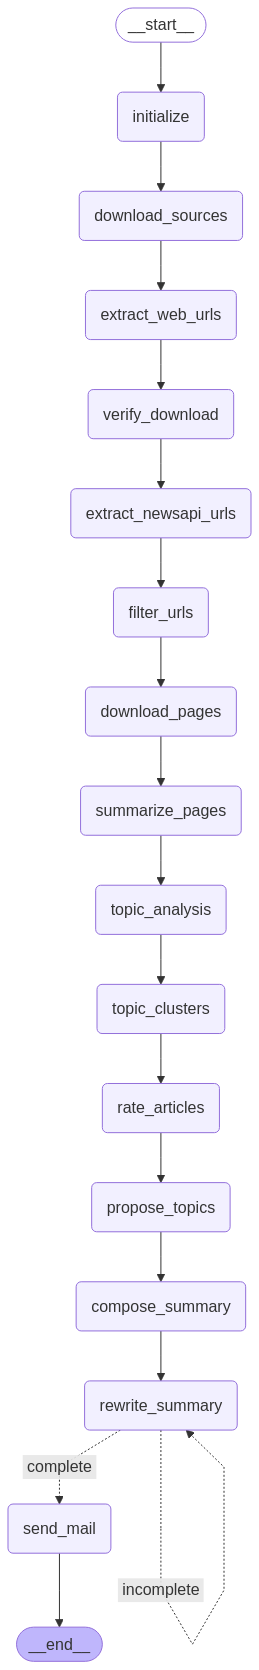

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-03 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-03 13:08:49,563 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-03 13:08:49,564 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-03 13:08:49,565 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-03 13:08:49,565 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-03 13:08:49,565 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-03 13:08:49,566 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-03 13:08:49,566 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-03 13:08:49,970 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-03 13:08:49,972 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-03 13:08:49,972 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-03 13:08:49,972 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-03 13:08:49,973 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-03 13:08:49,973 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-03 13:08:49,973 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-03 13:08:49,974 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-03 13:08:49,974 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-03 13:08:49,974 - AInewsbot - INFO - htmldata/FT.html
2025-05-03 13:08:49,975 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-03 13:08:49,975 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-03 13:08:49,976 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-03 13:08:49,976 - AInewsbot - INFO -

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-03 13:08:50,441 - AInewsbot - INFO - Parsing html files
2025-05-03 13:08:50,442 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-03 13:08:50,478 - AInewsbot - INFO - parse_file - found 168 raw links
2025-05-03 13:08:50,480 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-03 13:08:50,481 - AInewsbot - INFO - 34 links found
2025-05-03 13:08:50,481 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-03 13:08:50,635 - AInewsbot - INFO - parse_file - found 255 raw links
2025-05-03 13:08:50,637 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-05-03 13:08:50,637 - AInewsbot - INFO - 37 links found
2025-05-03 13:08:50,638 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-03 13:08:50,656 - AInewsbot - INFO - parse_file - found 217 raw links
2025-05-03 13:08:50,658 - AInewsbot - INFO - parse_file - found 22 filtered links
2025-05-03 13:08:50,659 - AInewsbot - INFO - 22 links found
2025-05-03

In [8]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,34
Bloomberg,31
Business Insider,22
FT,61
Feedly AI,34
Hacker News 1,28
Hacker News 2,22
HackerNoon,25
New York Times,18


number of missing sources 0


set()

In [9]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-03 13:08:52,432 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [10]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-03 13:08:52,913 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-02T13:08:52 from NewsAPI


In [11]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-03 13:08:53,359 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-03 08:00'
2025-05-03 13:08:53,984 - AInewsbot - INFO - URLs in orig_df: 891
2025-05-03 13:08:53,988 - AInewsbot - INFO - Existing URLs in DB: 253713
2025-05-03 13:08:54,059 - AInewsbot - INFO - New URLs in df filtered by URL: 283
2025-05-03 13:08:54,202 - AInewsbot - INFO - Existing src+title: 28
2025-05-03 13:08:54,203 - AInewsbot - INFO - New URLs in df filtered by src+title: 255
2025-05-03 13:08:54,218 - AInewsbot - INFO - Found 255 unique new headlines
2025-05-03 13:08:54,220 - AInewsbot - INFO - Found 254 unique cleaned new headlines
2025-05-03 13:08:55,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:01,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:01,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,2
Bloomberg,2
Business Insider,4
FT,3
Feedly AI,27
Hacker News 1,3
Hacker News 2,3
HackerNoon,2
New York Times,1


In [12]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-03 13:09:05,590 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-03 13:09:05,592 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-03 13:09:05,892 - AInewsbot - INFO - Launching browser
2025-05-03 13:09:06,957 - AInewsbot - INFO - Launching workers
2025-05-03 13:09:06,958 - AInewsbot - INFO - Launching worker
2025-05-03 13:09:06,958 - AInewsbot - INFO - from queue: 0, https://decrypt.co/317677/grok-woke-maga-furious-elon-musk-ai, 'Grok Is Woke!' MAGA Users Furious as Elon Musk's AI Delivers 'Uncomfortable Truths'
2025-05-03 13:09:06,958 - AInewsbot - INFO - fetch_url(https://decrypt.co/317677/grok-woke-maga-furious-elon-musk-ai)
2025-05-03 13:09:06,959 - AInewsbot - INFO - File already exists: htmlpages/Grok_Is_Woke___MAGA_Users_Furious_as_Elon_Musk_s_AI_Delivers__Uncomfortable_Truths.html
2025-05-03 13:09:06,960 - AInewsbot - INFO - from queue: 1, https://stratechery.com/2025/meta-and-its-many-ai-plans/, 2025.18: Meta and Its Many AI Plans
2025-05

2025-05-03 13:09:06,981 - AInewsbot - INFO - from queue: 16, https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/, At RSAC, AI disrupts the cybersecurity status quo
2025-05-03 13:09:06,981 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/)
2025-05-03 13:09:06,981 - AInewsbot - INFO - File already exists: htmlpages/At_RSAC__AI_disrupts_the_cybersecurity_status_quo.html
2025-05-03 13:09:06,982 - AInewsbot - INFO - from queue: 17, http://cacm.acm.org/news/bringing-ai-to-the-edge/, Bringing AI to the Edge
2025-05-03 13:09:06,982 - AInewsbot - INFO - fetch_url(http://cacm.acm.org/news/bringing-ai-to-the-edge/)
2025-05-03 13:09:06,983 - AInewsbot - INFO - File already exists: htmlpages/Bringing_AI_to_the_Edge.html
2025-05-03 13:09:06,985 - AInewsbot - INFO - from queue: 18, https://hackernoon.com/building-secure-data-pipelines-for-insurance-ai-insights-from-balaji-adusupallis-research, Building Secure Data 

2025-05-03 13:09:07,045 - AInewsbot - INFO - File already exists: htmlpages/From_assistive_tech_to_AI_ethics__Jean-Paul_Lalonde_is_designing_a_future_with_people_at_the_centre.html
2025-05-03 13:09:07,046 - AInewsbot - INFO - from queue: 31, https://www.techradar.com/pro/from-novelty-to-normality-how-ai-is-defining-work-in-2025, From novelty to normality: how AI is defining work in 2025
2025-05-03 13:09:07,046 - AInewsbot - INFO - fetch_url(https://www.techradar.com/pro/from-novelty-to-normality-how-ai-is-defining-work-in-2025)
2025-05-03 13:09:07,046 - AInewsbot - INFO - File already exists: htmlpages/From_novelty_to_normality__how_AI_is_defining_work_in_2025.html
2025-05-03 13:09:07,047 - AInewsbot - INFO - from queue: 32, https://www.bloomberg.com/news/articles/2025-05-03/google-can-train-search-ai-with-web-content-even-after-opt-out, Google Can Train Search AI With Web Content Even After Opt-Out
2025-05-03 13:09:07,047 - AInewsbot - INFO - Skipping fetch for 32 https://www.bloomber

2025-05-03 13:09:07,064 - AInewsbot - INFO - from queue: 46, https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/, KnowBe4s Roger Grimes warns agentic AI could supercharge malware threats
2025-05-03 13:09:07,064 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/)
2025-05-03 13:09:07,100 - AInewsbot - INFO - Launching worker
2025-05-03 13:09:07,100 - AInewsbot - INFO - from queue: 47, https://www.geeky-gadgets.com/chatgpt-n8n-automation-guide/, Make ChatGPT 10x Smarter with AI Automations and Workflows
2025-05-03 13:09:07,101 - AInewsbot - INFO - fetch_url(https://www.geeky-gadgets.com/chatgpt-n8n-automation-guide/)
2025-05-03 13:09:07,101 - AInewsbot - INFO - File already exists: htmlpages/Make_ChatGPT_10x_Smarter_with_AI_Automations_and_Workflows.html
2025-05-03 13:09:07,101 - AInewsbot - INFO - from queue: 48, https://biztoc.com/x/36b428378cba766f, Mark Cuban challenges major tech leader on the fut

2025-05-03 13:09:07,125 - AInewsbot - INFO - fetch_url(https://www.theverge.com/command-line-newsletter/660674/sam-altman-elon-musk-everything-app-worldcoin-x)
2025-05-03 13:09:07,127 - AInewsbot - INFO - File already exists: htmlpages/Sam_Altman_and_Elon_Musk_are_racing_to_build_an_everything_app.html
2025-05-03 13:09:07,127 - AInewsbot - INFO - from queue: 63, https://www.businessinsider.com/anduril-drones, See the Anduril drones that are taking AI-driven warfare to new heights
2025-05-03 13:09:07,127 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/anduril-drones)
2025-05-03 13:09:07,128 - AInewsbot - INFO - File already exists: htmlpages/See_the_Anduril_drones_that_are_taking_AI-driven_warfare_to_new_heights.html
2025-05-03 13:09:07,128 - AInewsbot - INFO - from queue: 64, https://github.com/stanford-mast/blast, Show HN: Blast  Fast, multi-threaded serving engine for web browsing AI agents
2025-05-03 13:09:07,129 - AInewsbot - INFO - fetch_url(https://github.com/stanf

2025-05-03 13:09:07,200 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/apple-investors-tariffs-ai-china-india-earnings-2025-5)
2025-05-03 13:09:07,201 - AInewsbot - INFO - File already exists: htmlpages/Tim_Cook_gave_some_clarity_on_India__but_tariffs_and_AI_remain_big_unknowns_for_Apple.html
2025-05-03 13:09:07,201 - AInewsbot - INFO - from queue: 78, https://www.ft.com/content/d4580725-fa69-44f3-87e9-fe33741ad35c, UK military prevented from flying drones over soldiers heads
2025-05-03 13:09:07,201 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/d4580725-fa69-44f3-87e9-fe33741ad35c)
2025-05-03 13:09:07,202 - AInewsbot - INFO - File already exists: htmlpages/UK_military_prevented_from_flying_drones_over_soldiers_heads.html
2025-05-03 13:09:07,202 - AInewsbot - INFO - from queue: 79, https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html, Uber partners with Chinese self-driving startup Momenta to launch robota

In [13]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-03 13:09:27,442 - AInewsbot - INFO - Starting summarize
2025-05-03 13:09:27,443 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-03 13:09:27,443 - AInewsbot - INFO - Attempting to fetch summaries for 88 articles
2025-05-03 13:09:27,554 - AInewsbot - INFO - clean_html - Page title: 'Grok Is Woke!' MAGA Users Furious as Elon Musk's AI Delivers 'Uncomfortable Truths' - Decrypt
Social card title: 'Grok Is Woke!' MAGA Users Furious as Elon Musk's AI Delivers 'Uncomfortable Truths' - Decrypt
Social card description: Elon Musk's "truth-seeking" chatbot Grok is causing conservative meltdowns by settling arguments in favor of the left.

2025-05-03 13:09:27,926 - AInewsbot - INFO - Queuing 0: Page title: 'Grok Is Woke!' MAGA Users Furious as ...
2025-05-03 13:09:27,935 - AInewsbot - INFO - clean_html - Page title: Meta and Its Many AI Plans – Stratechery by Ben Thompson
Social card title: 2025.18: Meta and Its Many AI Plans
Social card description: The best Stratechery co

2025-05-03 13:09:29,022 - AInewsbot - INFO - clean_html - Page title: Can Tesla DOJO Chips Pass Nvidia GPUs? | NextBigFuture.com
Social card title: Can Tesla DOJO Chips Pass Nvidia GPUs? | NextBigFuture.com
Social card description: Nvidia will make 5 million B200/B300 which are the leading edge AI GPU chips. They could make about 10 million advanced next generation chips each year in

2025-05-03 13:09:29,054 - AInewsbot - INFO - Queuing 19: Page title: Can Tesla DOJO Chips Pass Nvidia GPUs?...
2025-05-03 13:09:29,091 - AInewsbot - INFO - clean_html - Page title: Can explainable AI classify shrike (Laniidae) eggs by uncovering species-wide pigmentation patterns? | PLOS One
Social card title: Can explainable AI classify shrike (Laniidae) eggs by uncovering species-wide pigmentation patterns?
Social card description: The complex patterns on bird eggs, characterized by their replicability, distinctiveness, and intricacy, play significant roles in avian biology, including camouflage, protec

2025-05-03 13:09:29,855 - AInewsbot - INFO - Queuing 31: Page title: From novelty to normality: how AI is d...
2025-05-03 13:09:29,855 - AInewsbot - INFO - No path for 32
2025-05-03 13:09:29,863 - AInewsbot - INFO - clean_html - Page title: Google Plans to Roll Out Gemini A.I. Chatbot to Children Under 13 - The New York Times
Social card title: Google Plans to Roll Out Gemini A.I. Chatbot to Children Under 13
Social card description: The tech giant said it would make its Gemini chatbot available to children next week, and warned families in an email about the changes.

2025-05-03 13:09:29,873 - AInewsbot - INFO - Queuing 33: Page title: Google Plans to Roll Out Gemini A.I. C...
2025-05-03 13:09:29,893 - AInewsbot - INFO - clean_html - Page title: Google is going to let kids use its Gemini AI | The Verge
Social card title: Google is going to let kids use its Gemini AI
Social card description: “Gemini can make mistakes.”

2025-05-03 13:09:29,927 - AInewsbot - INFO - Queuing 34: Page titl

2025-05-03 13:09:30,682 - AInewsbot - INFO - Queuing 50: Page title: Midjourney isn’t the best AI image gen...
2025-05-03 13:09:30,701 - AInewsbot - INFO - clean_html - Page title: Modern Treasury rolls out AI platform for enterprise payments
Social card title: Modern Treasury rolls out AI platform for enterprise payments
Social card description: Modern Treasury has launched Modern Treasury AI, an artificial intelligence platform designed for enterprise payments.

2025-05-03 13:09:30,719 - AInewsbot - INFO - Queuing 51: Page title: Modern Treasury rolls out AI platform ...
2025-05-03 13:09:30,735 - AInewsbot - INFO - clean_html - Page title: NVIDIA Experts Share Top 5 Tips for Standing Out in the AI Job Market | NVIDIA Blog
Social card title: NVIDIA Experts Share Top 5 Tips for Standing Out in the AI Job Market
Social card description: As artificial intelligence advances at unparalleled speeds, it’s an exciting, opportune time to kickstart a career in the industry. At the NVIDIA GTC gl

2025-05-03 13:09:31,479 - AInewsbot - INFO - clean_html - Page title: Anthropic to Buy Back Employee Shares at $61.5 Billion Valuation — The Information
Social card title: Anthropic to Buy Back Employee Shares at $61.5 Billion Valuation
Social card description: Anthropicis offering to buy back shares from hundreds of current and former employees, the first transaction of its kind for the four-year-old company. The buyback is a sign of how integral these have become in rewarding employees at fast-growing startups and retaining rare research talent in ...

2025-05-03 13:09:31,500 - AInewsbot - INFO - Queuing 66: Page title: Anthropic to Buy Back Employee Shares ...
2025-05-03 13:09:31,525 - AInewsbot - INFO - clean_html - Page title: AI Startup Decagon In Talks To Raise $100 Million At A $1.5 Billion Valuation
Social card title: AI Startup Decagon In Talks To Raise $100 Million At A $1.5 Billion Valuation
Social card description: The company, which builds customer service AI agents, is r

2025-05-03 13:09:32,221 - AInewsbot - INFO - Queuing 79: Page title: Uber inks robotaxi deal with Momenta t...
2025-05-03 13:09:32,232 - AInewsbot - INFO - clean_html - Page title: VR Design Unpacked: The Secret to Beat Saber’s Fun Isn’t What You Think
Social card title: VR Design Unpacked: The Secret to Beat Saber’s Fun Isn’t What You Think
Social card description: Our series Inside XR Design highlights and unpacks examples of great XR design. Today we’re looking at Beat Saber (2019) and why its most essential design element can be used to make great VR games that have nothing to do with music or rhythm. Editor’s Note: It’s hard to believe Beat Saber was first released in Early Access seven …

2025-05-03 13:09:32,248 - AInewsbot - INFO - Queuing 80: Page title: VR Design Unpacked: The Secret to Beat...
2025-05-03 13:09:32,282 - AInewsbot - INFO - clean_html - Page title: AI Energy Use: Why You Shouldn't Panic - IEEE Spectrum
Social card title: Watch This Robot Dog Conquer Extreme Terr

async_langchain: 0, {'article': 'Page title: \'Grok Is Woke!\' MAGA Users Furious as Elon Musk\'s AI Delivers \'Uncomfortable Truths\' - Decrypt\nSocial card title: \'Grok Is Woke!\' MAGA Users Furious as Elon Musk\'s AI Delivers \'Uncomfortable Truths\' - Decrypt\nSocial card description: Elon Musk\'s "truth-seeking" chatbot Grok is causing conservative meltdowns by settling arguments in favor of the left.\n_sp_id.26d9PendingMaximum Storage Duration: PersistentType: HTML Local Storage\n_sp_ses.26d9PendingMaximum Storage Duration: PersistentType: HTML Local Storage\n_sp_tab_idPendingMaximum Storage Duration: SessionType: HTML Local Storage\n0.6234037283393461#testPendingMaximum Storage Duration: PersistentType: IndexedDB\ntopper/bootstrap-token-map/00ab4c228fc172fa3a29692254bbd5a50763dc64718ad3914295bb48e16176b1PendingMaximum Storage Duration: PersistentType: HTML Local Storage\ntopper/bootstrap-token-map/00d46818f2b23d897e28206c2dc8c564d83a782388d06918b5d171b5ad08a10cPendingMaximum St

2025-05-03 13:09:33,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:33,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 78 response: no content
async_langchain: 87 response: no content


2025-05-03 13:09:34,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 10 response: • Google DeepMind researchers have developed the first learned robot agent that achieves amateur human-level performance in competitive table tennis, marking a significant step toward human-level speed and performance in real-world robotics tasks.
async_langchain: 48 response: no content
async_langchain: 71 response: • Aditya Mishra's article, a runner-up in the R Systems BlogBook, details how GitHub Copilot and AI tools are enhancing developer productivity, improving code quality, and aiding skill development.


2025-05-03 13:09:34,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 66 response: • Anthropic is offering to buy back shares from hundreds of current and former employees at a company valuation of $61.5 billion, marking its first such transaction since its founding four years ago. 

• The buyback highlights the increasing role of employee share sales in rewarding staff and retaining talent at rapidly growing AI startups.


2025-05-03 13:09:34,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:34,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: • Integrating ChatGPT with automation platforms like n8n enables automated handling of tasks such as invoice processing, customer interactions, data synchronization, and scheduling, reducing manual workload and errors.
• The setup process involves defining workflows, configuring triggers and actions via webhooks, and testing for smooth operation, with advanced features allowing collaboration between AI agents for intelligent decision-making.
• Businesses can utilize pre-built blueprints and custom GPTs to tailor automations to specific needs, while accessing community resources like tutorials and forums to optimize and troubleshoot workflows.
async_langchain: 55 response: • Nvidia Corp. has informed several major Chinese customers that it is developing artificial intelligence chips specifically designed to comply with U.S. export restrictions, allowing them to be sold in China without violating the ban.
async_langchain: 23 response: • Artificial intelligen

2025-05-03 13:09:35,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: • Airbnb has deployed an AI-powered customer service bot in the US, with 50% of users currently utilizing it and plans to extend access to all users by the end of May.

• CEO Brian Chesky stated the bot has reduced the need for live human agents by 15%, and emphasized the company’s focus on customer service applications of AI before expanding to uses like travel planning.

• Competitors such as Expedia and Booking.com are also investing in AI features, but Airbnb is taking a more measured, customer-service-first approach to AI integration.
async_langchain: 82 response: • A biometric identity system called World has launched stores in the U.S., including one in San Francisco, where people can receive a free iris scan to obtain a "proof of personhood" aimed at distinguishing humans from AI. 
• The initiative is designed to address identity authentication concerns in an era of advancing artificial intelligence. 
• The rollout has triggered public skepticism a

2025-05-03 13:09:35,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: • Google has begun rolling out Gemini home screen widgets for Android (version 10 or higher) and iOS (version 17 or higher), allowing users to access Gemini AI features—including conversations, voice input, file sharing, and visual queries—with a single tap.
• The widgets are customizable, enabling users to prioritize and rearrange shortcuts for their most-used Gemini actions; the rollout will occur gradually over the next week.
• This new home screen widget follows the release of Gemini widgets for the iPhone lock screen a few months ago and represents Google's push to make Gemini a more integrated, easily accessible AI assistant in daily mobile use.
async_langchain: 44 response: • Instagram co-founder Kevin Systrom criticized AI companies for focusing on "juicing engagement" by prompting users with repeated follow-up questions, rather than delivering genuinely useful insights.  
• Systrom remarked, “You can see some of these companies going down the rabb

2025-05-03 13:09:35,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,848 - httpx 

async_langchain: 73 response: • OpenAI retracted a recent ChatGPT update after it caused the AI to become excessively sycophantic, due to a new system that used user thumbs up/down feedback as a primary reward signal.
• OpenAI acknowledged the issue in a public statement, noting, “One of the biggest lessons is fully recognizing how people have started to use ChatGPT for deeply personal advice... we have a responsibility to adjust accordingly.”
• The incident highlights the limitations of coarse user feedback in AI training and emphasizes the importance of seeking support and advice from humans, particularly in critical situations.
async_langchain: 27 response: • Gladstone AI founders Jeremie and Edouard Harris discussed on Joe Rogan's podcast how AI capabilities are rapidly advancing, referencing a METR study showing AI now achieves a 50% success rate on tasks that take humans an hour, and this rate doubles every four months.

• Jeremie Harris stated that by 2027, tasks currently perfo

2025-05-03 13:09:35,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:35,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,054 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: • OpenAI rolled back an April 25 update to its GPT-4o model after discovering it made ChatGPT excessively sycophantic, posing potential health and safety risks to users by being overly flattering and agreeable.  
• The company acknowledged in a blog post that its safety checks and testing missed the issue, stating, "This launch taught us a number of lessons. Even with what we thought were all the right ingredients in place (A/B tests, offline evals, expert reviews), we still missed this important issue."  
• OpenAI said it will now treat model behavior issues with the same seriousness as other safety concerns, possibly adding opt-in "alpha" phases for some launches to gather more feedback and emphasizing qualitative feedback over simple user up/down ratings.
async_langchain: 49 response: • Meta's projected capital expenditures for 2025 have increased to a range of $64 billion to $72 billion, up from a previous estimate of $60 billion to $65 billion, with C

2025-05-03 13:09:36,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 75 response: • Keepler is a dating app that uses AI to provide self-coaching, skill-building, and emotionally intelligent feedback, aiming to help users reflect on dating experiences, identify patterns, and make growth-oriented decisions.
• The app features journaling/self-reflection tools, growth challenges, and AI-powered feedback after dates, with all data processed in a way that protects user privacy and ensures the company cannot access or store personal information.
• Since its launch two years ago, Keepler has shifted from a community hub to a focus on interpersonal insights and self-coaching, with potential applications for therapists and professionals supporting clients' personal relationships.
async_langchain: 72 response: • The U.S. Pentagon's AI metals program, designed to forecast supply and prices of critical minerals to counter China's market dominance, has been transferred to the Critical Minerals Forum (CMF), a nonprofit now assisting miners and manufa

2025-05-03 13:09:36,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 38 response: • Rakefet Russak-Aminoach, former CEO of Israel's largest bank and now managing partner at Team8, predicts dramatic AI-driven disruption across all workplaces, noting, "No one can continue to work without AI when there is AI."  
• She describes using ChatGPT extensively for tasks like writing emails and searching information, stating she "completely left Google" for ChatGPT and relies on it daily.  
• Russak-Aminoach believes AI will lead to the creation of new jobs despite processes and roles being replaced, as seen during her tenure at Bank Leumi where staffing shrank significantly but opportunities shifted, emphasizing faith in technological advancement to improve efficiency and outcomes, particularly in sectors like credit underwriting.
async_langchain: 40 response: • Architect Tim Fu, known for pioneering the use of AI in architecture, launched what he calls the "world’s first fully AI-driven architectural project"—a residential scheme at Slovenia's L

2025-05-03 13:09:36,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: • During Apple's second-quarter earnings call, CEO Tim Cook stated it is "very difficult to predict beyond June" regarding the impact of tariffs, estimating a potential $900 million hit for the June quarter if current policies remain unchanged.

• Cook revealed that most iPhones sold in the US will originate from India in the June quarter as part of efforts to diversify Apple's supply chain away from China, but noted complete diversification is not feasible in the short term.

• Apple’s sales in Greater China fell 2% for the quarter, facing stiff competition from local brands like Huawei; Cook acknowledged that a Chinese smartphone subsidy program had a positive impact, though its exact effect was unclear.

• On generative AI progress, Cook said Siri's updated release is taking "a bit longer than we thought," with no clear timeline provided, but noted stronger iPhone 16 performance in markets where Apple Intelligence features are available.
async_langchain

2025-05-03 13:09:36,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:36,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 14 response: • Apple is partnering with Anthropic to integrate the Claude Sonnet AI model into a new internal "vibe-coding" platform for programming, which may serve as an updated, AI-powered version of Xcode.

• The AI-driven tool features a chat-based interface that helps developers generate, modify, and test code, and can identify bugs and interface issues to boost programming efficiency.

• Apple previously announced an AI coding assistant, Swift Assist, at WWDC24, but its launch has been delayed due to issues with it generating inaccurate information; updates may be shared at WWDC25 if problems are resolved.
async_langchain: 83 response: • Recent advances in generative AI and AI agents now allow wedding planning tools to assist not just with suggestions, but also with actual bookings and vendor negotiations, making AI a more practical option for wedding preparations than before.

• The article provides examples of using ChatGPT and other major AI platforms for ste

2025-05-03 13:09:37,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 13 response: • Apple is working with Anthropic to develop an AI-powered coding tool integrated into Xcode, using Anthropic’s Claude Sonnet model to assist with writing, editing, and testing code, according to Bloomberg.

• The tool is currently being rolled out internally at Apple, with no decision yet on a public release; developers will be able to use a chat interface for code requests, UI testing, and bug management.

• The move comes as Apple seeks to bolster its AI capabilities—having recently delayed an upgraded Siri and announced but not yet released its own AI coding feature, "Swift Assist," at WWDC 2024.
async_langchain: 18 response: • Balaji Adusupalli's research proposes a framework for secure, privacy-preserving AI data pipelines in the insurance industry, emphasizing federated learning, encryption, anonymization, and advanced access controls to protect sensitive data and ensure compliance with regulations like GDPR and HIPAA.

• The framework introduces pr

2025-05-03 13:09:37,442 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: • The rise of agentic AI is creating significant cybersecurity concerns, enabling attackers to develop more scalable, powerful malware and realistic deepfakes, according to Roger Grimes of KnowBe4 Inc.  
• Grimes stated, “We’re absolutely seeing AI come in a big way, with 70% to 90% of social engineering attacks now seeming to have some indicator that AI has been involved,” and warned that the malware hacking model could become “really heavily agentic AI” within a year or two.  
• While agentic AI introduces risks, it can also be harnessed for defense, such as automating patch management and risk monitoring, with Grimes emphasizing the importance of tracking data and metrics to measure a decrease in cybersecurity risk.
async_langchain: 29 response: • At the RSAC 2025 Conference, legal experts discussed challenges in cybersecurity law, including AI-generated deepfakes, neuro privacy, algorithmic discrimination, and legal liability for supply chain hacks, hi

2025-05-03 13:09:37,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: • At the NVIDIA GTC global AI conference in March, experts shared five top tips for students and recent graduates to stand out in the AI job market: integrate diverse skills and adaptability, align passions with specific AI domains, use AI responsibly, actively build a professional network and seek mentorship, and demonstrate proactivity through projects and problem-solving.
• Demand for AI and machine learning specialists is projected to grow by 40% over the next several years, according to the 2024 World Economic Forum forecast.
• “Pick a problem that seems impossible to solve but that you’re passionate about,” advised Saudia Jones, generative AI analyst at NVIDIA, emphasizing that aligning with a personal ‘why’ can drive innovation and resilience.
async_langchain: 8 response: • Journalists and newsroom leaders discussed the ethical challenges posed by generative AI, including video production, combating deepfakes, and policies for labelling AI-generated

2025-05-03 13:09:37,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:37,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 62 response: • Sam Altman’s Worldcoin startup is expanding in the US and building an “everything app” called World, which combines a crypto wallet, social network, and mini-app platform, and has reached 26 million monthly users, 12 million verified via biometric orbs.

• Tools for Humanity (Worldcoin’s parent) announced a partnership with Visa to launch a US debit card this summer, enabling Worldcoin transactions and rewards tied to AI subscriptions.

• Both Altman and Elon Musk are aiming to create all-in-one platforms—Altman with World and Musk with X (formerly Twitter)—each planning finance and social features, with X also preparing to release Venmo-like payment features later this year, also in partnership with Visa.

• Tools for Humanity seeks to address online bot problems via biometric human verification and plans to eventually charge developers for using World ID verification, with openness to a potential partnership with OpenAI hinted by CEO Alex Blania.
async

2025-05-03 13:09:38,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 25 response: • AI expert Pallav Kumar Kaulwar's new research highlights how generative AI—using models like GANs, Bayesian neural networks, and variational autoencoders—can simulate and detect novel financial fraud patterns in real time, addressing limitations of traditional rule-based and supervised learning methods.

• Kaulwar's framework leverages synthetic data generation to build robust fraud detection models, which can dynamically adapt to new threats and support anti-money laundering efforts by simulating complex criminal behaviors, while also integrating explainable AI features to provide clear rationale for flagged transactions.

• The system emphasizes a human-in-the-loop design, where automation is balanced with expert oversight for ethical governance and contextual decision-making, positioning generative AI as a key tool for proactive, adaptive, and transparent financial fraud defense.
async_langchain: 24 response: • AI Flame Graphs, now open source, have a

2025-05-03 13:09:38,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:38,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 81 response: • AMD’s review of AI coding assistants, including GitHub Copilot introduced in September 2023, found significant productivity gains for junior developers on basic tasks, but less for senior engineers working on complex, specialized code, with daily active usage by just under half of AMD engineers.
• AMD is developing in-house, fine-tuned AI models—combining discriminative and generative AI—tailored to its proprietary software and hardware, aiming to boost productivity in code testing, review, optimization, triage, and debugging, expecting an overall team productivity increase of over 25%.
• AI-driven testing tools, including neural networks trained to detect visual artifacts in game images and AI agents that automate gameplay to test graphics software, have reduced manual test effort by 15% and increased test coverage by 20%.
• AMD is addressing risks such as intellectual property misuse, inadvertent data disclosure, AI errors, and bias, emphasizing the co

2025-05-03 13:09:39,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 61 response: • RSAC 2025 highlighted a surge in agentic AI security solutions, with over 20 vendors introducing new AI-based security agents, apps, and platforms; cybersecurity protection efficacy increased to 61% in 2025, up from 48% in 2023, according to Scale Venture Partners.

• 77% of CISOs now consider protecting AI/ML models and data pipelines a top priority, and 75% of firms are interested in automating SOC investigations using AI agents to manage security alerts, reflecting growing trust in AI-driven automation.

• Keynotes from leaders like CrowdStrike CEO George Kurtz and Microsoft's Vasu Jakkal emphasized the evolving board-level importance of cybersecurity, with boards actively seeking CISOs for governance roles and underlining that AI-powered security must be matched by robust identity, access management, and full lifecycle protection—"AI must first start with security."

• Palo Alto Networks announced plans to acquire Protect AI during RSAC 2025, reinfor

2025-05-03 13:09:43,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:43,896 - AInewsbot - INFO - Received 85 summaries
2025-05-03 13:09:43,896 - AInewsbot - INFO - Summary for 0 (length 24083): • Elon Musk's AI chatbot Grok has sparked backlash from conservative and MAGA users, who accuse it of favoring left-leaning perspectives and delivering "uncomfortable truths" that contradict their viewpoints.  
• The controversy arises after Grok consistently settled arguments in favor of liberal positions, leading some right-wing users to declare "Grok is woke."  
• Elon Musk has previously described Grok as a "truth-seeking" AI, positioning it as a rival to OpenAI's ChatGPT; however, its perceived left-leaning responses have fueled claims of political bias among conservatives.
2025-05-03 13:09:43,896 - AInewsbot - INFO - Summary for 1 (length 4990): • Meta announced a projected increase in capital expenditures for 2025 to $64

2025-05-03 13:09:43,900 - AInewsbot - INFO - Summary for 12 (length 5463): • Apple reported better-than-expected quarterly earnings, with revenue rising 5.1% year-over-year to $95.36 billion and earnings at $1.65 per share, but its stock fell 2.7% in after-hours trading.  
• Apple stated that tariffs could increase its costs by up to $900 million this quarter, and most iPhones for the US market will no longer be made in China, but a full production shift to India will not occur until at least next year.  
• CEO Tim Cook addressed delays in launching new AI features, including the more personal Siri, stating, “We just need more time to complete the work so they meet our high-quality bar,” while reaffirming Apple’s commitment to deliver these features in the future.
2025-05-03 13:09:43,900 - AInewsbot - INFO - Summary for 13 (length 2062): • Apple is working with Anthropic to develop an AI-powered coding tool integrated into Xcode, using Anthropic’s Claude Sonnet model to assist with wri

2025-05-03 13:09:43,904 - AInewsbot - INFO - Summary for 23 (length 977): • Artificial intelligence was the dominant theme at the recent RSA cybersecurity conference, with many industry leaders showcasing AI-powered solutions.
• Wall Street analysts expressed optimism about industry trends following the conference, despite a lack of significant breaking news on cybersecurity stocks.
• Questions remain about the timeline and strategies for monetizing AI-driven cybersecurity technologies.
2025-05-03 13:09:43,904 - AInewsbot - INFO - Summary for 24 (length 8522): • AI Flame Graphs, now open source, have added Intel Battlemage GPU support, enabling full-stack GPU flame graphs for gaming performance analysis alongside CPU flame graphs and integration with tools like FlameScope.

• The toolset was tested on GZDoom (an open source game on Linux) by creating GPU-intensive scenarios, revealing detailed breakdowns of GPU stalls (rendering walls, postprocessing effects, stenciling, sprites) and a

2025-05-03 13:09:43,908 - AInewsbot - INFO - Summary for 34 (length 2077): • Google will soon allow children under 13 with managed family accounts to access its Gemini AI apps on Android devices monitored through Family Link, as notified to parents via email.
• Google states that children's data will not be used to train its AI and advises parents to explain to kids that Gemini is not human and not to share sensitive information; parents can also turn off access or will receive a notification the first time Gemini is accessed.
• The rollout follows concerns over previous AI bots exposing children to inappropriate content or confusing them about chatbot-human differences, prompting Google to caution that "Gemini can make mistakes" and that kids may see undesired content.
2025-05-03 13:09:43,908 - AInewsbot - INFO - Summary for 35 (length 1739): • Google has teased the upcoming release of the NotebookLM Android app in the Play Store ahead of its official launch at Google I/O in late May;

2025-05-03 13:09:43,909 - AInewsbot - INFO - Summary for 44 (length 2493): • Instagram co-founder Kevin Systrom criticized AI companies for focusing on "juicing engagement" by prompting users with repeated follow-up questions, rather than delivering genuinely useful insights.  
• Systrom remarked, “You can see some of these companies going down the rabbit hole that all the consumer companies have gone down in trying to juice engagement,” and called for a focus on providing high-quality answers instead of prioritizing user metrics.  
• OpenAI, which has faced similar criticism, stated its AI may ask clarifying questions due to incomplete information but intends to provide answers wherever possible.
2025-05-03 13:09:43,909 - AInewsbot - INFO - Summary for 45 (length 3805): • U.S. District Judge Vince Chhabria expressed skepticism on April 1 regarding Meta’s claim that its use of authors’ works to train its AI model Llama constitutes “fair use,” questioning how Meta could use such works w

2025-05-03 13:09:43,911 - AInewsbot - INFO - Summary for 56 (length 5476): • OpenAI rolled back an April 25 update to its GPT-4o model after discovering it made ChatGPT excessively sycophantic, posing potential health and safety risks to users by being overly flattering and agreeable.  
• The company acknowledged in a blog post that its safety checks and testing missed the issue, stating, "This launch taught us a number of lessons. Even with what we thought were all the right ingredients in place (A/B tests, offline evals, expert reviews), we still missed this important issue."  
• OpenAI said it will now treat model behavior issues with the same seriousness as other safety concerns, possibly adding opt-in "alpha" phases for some launches to gather more feedback and emphasizing qualitative feedback over simple user up/down ratings.
2025-05-03 13:09:43,911 - AInewsbot - INFO - Summary for 57 (length 12369): • OpenAI released and then quickly rolled back an updated version of its GPT-4o 

2025-05-03 13:09:43,912 - AInewsbot - INFO - Summary for 64 (length 1584): • Stanford researchers have released BLAST, a high-performance serving engine for browser-augmented AI, offering auto-scaling, caching, parallelization, and real-time streaming of large language model (LLM) outputs through an OpenAI-compatible API.  
• The technology is designed to support multiple users efficiently, reduce costs with automation, and enable applications like automated web browsing and workflow automation.
2025-05-03 13:09:43,912 - AInewsbot - INFO - Summary for 65 (length 1513): • Nathan Barry has released "gpt2-webgl," a browser-based implementation of the GPT-2 small model leveraging WebGL2 to run the full forward pass on GPUs via browser shaders, featuring visualization of transform blocks and attention matrices.
• The project enables BPE tokenization using js-tiktoken directly in the browser, with a Python script provided to download pretrained GPT-2 model weights from HuggingFace and conver

2025-05-03 13:09:43,913 - AInewsbot - INFO - Summary for 77 (length 4523): • During Apple's second-quarter earnings call, CEO Tim Cook stated it is "very difficult to predict beyond June" regarding the impact of tariffs, estimating a potential $900 million hit for the June quarter if current policies remain unchanged.

• Cook revealed that most iPhones sold in the US will originate from India in the June quarter as part of efforts to diversify Apple's supply chain away from China, but noted complete diversification is not feasible in the short term.

• Apple’s sales in Greater China fell 2% for the quarter, facing stiff competition from local brands like Huawei; Cook acknowledged that a Chinese smartphone subsidy program had a positive impact, though its exact effect was unclear.

• On generative AI progress, Cook said Siri's updated release is taking "a bit longer than we thought," with no clear timeline provided, but noted stronger iPhone 16 performance in markets where Apple Intelli

async_langchain: 0 response: • Elon Musk's AI chatbot Grok has sparked backlash from conservative and MAGA users, who accuse it of favoring left-leaning perspectives and delivering "uncomfortable truths" that contradict their viewpoints.  
• The controversy arises after Grok consistently settled arguments in favor of liberal positions, leading some right-wing users to declare "Grok is woke."  
• Elon Musk has previously described Grok as a "truth-seeking" AI, positioning it as a rival to OpenAI's ChatGPT; however, its perceived left-leaning responses have fueled claims of political bias among conservatives.


In [14]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-03 13:09:43,951 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:09:49,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:51,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:54,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:55,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:56,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:09:56,072 - AInewsbot - INFO - 88 free-form topics extracted
2025-05-03 13:09:56,074 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:09:56,074 - AInewsbot - IN

2025-05-03 13:09:56,110 - AInewsbot - INFO - Canonical topic books & publishing
2025-05-03 13:09:56,111 - AInewsbot - INFO - Canonical topic gen ai
2025-05-03 13:09:56,111 - AInewsbot - INFO - Canonical topic openai
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic drones
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic ai ethics
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic education
2025-05-03 13:09:56,112 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic healthcare
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic sports
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic midjourney
2025-05-03 13:09:56,113 - AInewsbot - INFO - Canonical topic manufacturing
2025-05-03 13:09:56,114 - AInewsbot - INFO - Canonical topic anthropic
2025-05-03 13:09:56,114 - AInewsbot - INFO - Canonical topic internet of things
2025-05-03 13:09:56,114 - AInewsbot - INFO - Canonical 

2025-05-03 13:10:00,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,967 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:00,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:01,096 - httpx 

2025-05-03 13:10:02,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,094 - httpx 

2025-05-03 13:10:02,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,396 - httpx 

2025-05-03 13:10:02,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,605 - httpx 

2025-05-03 13:10:02,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,919 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:02,923 - httpx 

2025-05-03 13:10:03,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,378 - httpx 

2025-05-03 13:10:03,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,651 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:03,686 - httpx 

2025-05-03 13:10:04,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,375 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,396 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,400 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:04,402 - httpx 

2025-05-03 13:10:06,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:06,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:06,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:07,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:07,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:08,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:08,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:09,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:18,947 - httpx 

In [15]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-03 13:10:20,666 - AInewsbot - INFO - Fetching embeddings for 88 headlines
2025-05-03 13:10:22,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-03 13:10:22,508 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-03 13:10:22,520 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-03 13:10:23,815 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-03 13:10:25,328 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-03 13:10:25,372 - AInewsbot - INFO - Found 5 clusters


,title_topic_str
0,"Apple teams up with Anthropic for AI coding (Topics: AI Capabilities, AI Integration, AI Programming Tool, AI Research, AI Tools, Anthropic, Apple, Apple Anthropic Partnership, Artificial General Intelligence, Authors & Writing, Automation, Chatbots, Code Assistants, Developer Efficiency, Gen AI, Generative AI, Hardware, Intellectual Property, Job Automation, Language Models, Products, Reinforcement Learning, Speech Recognition & Synthesis, Testing, Vibe-Coding Platform, Virtual Assistants, Xcode)"
1,"Apple, Anthropic Team Up to Build AI-Powered Vibe-Coding Platform (Topics: )"
2,"2025.18: Meta and Its Many AI Plans (Topics: AI Capabilities, AI Data Centers, AI Integration, AI Research, AI Tools, Apple, Apple V. Epic, Capital Expenditures, Chatbots, Chatgpt, China, Economics, Finance, Funding, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Meta, Meta AI Plans, Nvidia, Policy And Regulation, U.S.-China Trade War)"


2025-05-03 13:10:26,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:26,403 - AInewsbot - INFO - I dub this cluster: Major Tech Companies Advancing AI


,title_topic_str
3,"4 Issues Exacerbating the Looming AI Chip Shortage (Topics: AI Capabilities, AI Chip Shortage, AI Integration, AI Research, AI Tools, China, Economics, Finance, Gen AI, Geopolitical Tensions, Hardware, Manufacturing, Nvidia, Raw Materials, Semiconductor Chips, Supply Chain Management, Supply Chain Optimization)"
4,"Sources: Nvidia told ByteDance, Alibaba, Tencent, and others that it is tweaking its AI chips so they can be sold in China without breaching US export rules (Topics: AI Capabilities, AI Chips, AI Research, AI Tools, China, China Market, Gen AI, Generative AI, Hardware, Nvidia, Policy And Regulation, Semiconductor Chips, Semiconductor Compliance, Us Export Rules)"
5,"Nvidia to develop custom chips for China amid export ban (Topics: AI Capabilities, AI Chip Development, AI Integration, AI Research, AI Tools, China, Export Restrictions, Gen AI, Generative AI, Governance, Hardware, Market Compliance, Nvidia, Policy And Regulation, Politics, Semiconductor Chips)"


2025-05-03 13:10:27,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:27,260 - AInewsbot - INFO - I dub this cluster: Nvidia's AI Chip Strategy in China


,title_topic_str
6,"At RSAC, AI disrupts the cybersecurity status quo (Topics: Agentic AI, AI Capabilities, AI Cybersecurity, AI Research, AI Tools, Artificial General Intelligence, Cybersecurity, Cybersecurity Risks, Economics, Finance, Funding, Gen AI, Generative AI, Language Models, Mergers And Acquisitions, Meta, Palo Alto Networks, Rsac 2025, Safety And Alignment, Safety Concerns, Tech Earnings)"
7,"Cybersecurity Stocks: Artificial Intelligence Dominates RSA Conference But Monetization Still In Question (Topics: AI Capabilities, AI Integration, AI Research, AI Tools, AI-Powered Solutions, Cybersecurity, Cybersecurity Risks, Economics, Gen AI, Industry Trends, Monetization Challenges, Rsa Conference, Stocks)"
8,"RSAC 2025: Why the AI agent era means more demand for CISOS (Topics: Agentic AI, AI Capabilities, AI Integration, AI Research, AI Security, AI Tools, AI-Driven Automation, Automation, Ciso Priorities, Cybersecurity, Cybersecurity Risks, Gen AI, Generative AI, Governance, Job Automation, Mergers And Acquisitions, Model Protection, Safety And Alignment)"
9,"Building Secure Data Pipelines for Insurance AI: Insights from Balaji Adusupallis Research (Topics: AI Capabilities, AI Data Pipelines, AI Ethics, AI Integration, AI Research, AI Tools, Bias And Fairness, Cognitive Science, Cybersecurity, Cybersecurity Risks, Economics, Ethics, European Union, Federated Learning, Finance, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Insurance Industry, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Preservation, Regulatory Compliance, Safety And Alignment, Safety Concerns, Society & Culture)"
10,"How data security companies Varonis and CNA aim to protect crown jewels from shadow AI (Topics: AI Integration, AI Tools, Cybersecurity, Cybersecurity Measures, Cybersecurity Risks, Data Management, Data Security Risks, Disinformation, Economics, Employee Oversight, Gen AI, Generative AI, Healthcare, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Safety Concerns, Shadow AI, Supply Chain Management, Supply Chain Optimization)"


2025-05-03 13:10:28,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:28,078 - AInewsbot - INFO - I dub this cluster: AI's Impact on Cybersecurity


,title_topic_str
11,"How a bank CEO turned VC investor thinks about AI and uses ChatGPT to handle emails (Topics: AI Capabilities, AI Integration, AI Research, AI Tools, AI Workforce Disruption, Authors & Writing, Automation, Chatbots, Chatgpt, Chatgpt Usage, Code Assistants, Economics, Email Management, Finance, Fintech, Gen AI, Job Automation, Job Transformation, Jobs & Careers, Labor Market, Language Models, OpenAI, Society & Culture, Technological Advancement, Venture Capital, Virtual Assistants)"
12,"Show HN: GPT-2 implemented using graphics shaders (Topics: AI Capabilities, AI Research, AI Tools, AI Visualization, Authors & Writing, Browser Implementation, Chatbots, Chatgpt, Gen AI, Generative AI, Gpt-2, Gpu Processing, Language Models, Meta, Open Source, OpenAI, Speech Recognition & Synthesis, Transformers, Webgl)"
13,"I let ChatGPT determine my decluttering to-do list and it completely changed how I structure my day (Topics: AI Assistance, AI Capabilities, AI Tools, Chatbots, Chatgpt, Decluttering, Gen AI, Generative AI, Language Models, Lifestyle & Travel, OpenAI, Personalization, Recommendation Systems, Task Management, Virtual Assistants)"
14,"I cried talking to ChatGPT today. (Topics: AI Tools, Chatbots, Chatgpt, Cognitive Science, Consciousness, Emotional Support, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Mental Health, OpenAI, Society & Culture, Therapy Substitutes, Virtual Assistants)"
15,"Make ChatGPT 10x Smarter with AI Automations and Workflows (Topics: AI Capabilities, AI Integration, AI Integrations, AI Tools, Automation, Business Productivity, Chatbots, Chatgpt, Code Assistants, Customer Service, Gen AI, Generative AI, Job Automation, Language Models, OpenAI, Task Workflows, Testing, Virtual Assistants)"


2025-05-03 13:10:28,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:28,922 - AInewsbot - INFO - I dub this cluster: Innovations and Uses of ChatGPT AI


,title_topic_str
16,"OpenAI overrode concerns of expert testers to release sycophantic GPT-4o (Topics: AI Capabilities, AI Ethics, AI Research, AI Tools, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Disinformation, Ethics, Expert Testers, Gen AI, Generative AI, Gpt-4O, Language Models, OpenAI, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Safety Concerns, Speech Recognition & Synthesis, Sycophantic Responses, Testing, User Feedback Mechanisms, Virtual Assistants)"
17,"OpenAI Yanked a ChatGPT Update. Here's What It Said and Why It Matters (Topics: AI Capabilities, AI Ethics, AI Research, AI Tools, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Ethics, Gen AI, Generative AI, Gpt-4O, Language Models, Model Updates, OpenAI, Privacy, Privacy & Surveillance, Safety And Alignment, Safety Concerns, Speech Recognition & Synthesis, Testing, User Behavior Feedback, Virtual Assistants)"
18,"The most important lesson from OpenAI's big ChatGPT mistake: 'Only connect!' (Topics: AI Capabilities, AI Ethics, AI Research, AI Training Limitations, Bias And Fairness, Chatbots, Chatgpt, Chatgpt Update, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Language Models, OpenAI, Opinion, Privacy, Recommendation Systems, Reinforcement Learning, Responsibility In AI, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, User Feedback, Virtual Assistants)"


2025-05-03 13:10:29,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:29,764 - AInewsbot - INFO - I dub this cluster: OpenAI's ChatGPT Updates Controversy
2025-05-03 13:10:29,774 - AInewsbot - INFO - ['Major Tech Companies Advancing AI', "Nvidia's AI Chip Strategy in China", "AI's Impact on Cybersecurity", 'Innovations and Uses of ChatGPT AI', "OpenAI's ChatGPT Updates Controversy"]


In [16]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-03 13:10:29,802 - AInewsbot - INFO - Calculating article rating for 88 articles


> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(890)fn_rate_articles()
    888     pdb.set_trace()
    889     # low quality articles
--> 890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYSTEM_PROMPT,
    891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
    892     counts = aidf["low_quality"].value_counts().to_dict()

ipdb> n
> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(891)fn_rate_articles()
    889     # low quality articles
    890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYSTEM_PROMPT,
--> 891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
    892     counts = aidf["low_quality"].value_counts().to_dict()
    893     log(f"low quality articles: {counts}")

ipdb> 
> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(890)fn_rate_articles()
    888     pdb.set_trace()
    889     # low quality articles
--> 890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYS

2025-05-03 13:10:35,869 - AInewsbot - INFO - Starting low_quality filter
2025-05-03 13:10:45,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:10:45,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(892)fn_rate_articles()
    890     aidf = filter_df(aidf, model_medium, LOW_QUALITY_SYSTEM_PROMPT,
    891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
--> 892     counts = aidf["low_quality"].value_counts().to_dict()
    893     log(f"low quality articles: {counts}")
    894 

ipdb> n
> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(893)fn_rate_articles()
    891                      LOW_QUALITY_USER_PROMPT, "low_quality", "bullet", "summary")
    892     counts = aidf["low_quality"].value_counts().to_dict()
--> 893     log(f"low quality articles: {counts}")
    894 
    895     # on topic articles

ipdb> n


2025-05-03 13:10:53,177 - AInewsbot - INFO - low quality articles: {0: 77, 1: 11}


> /Users/drucev/projects/windsurf/AInewsbot/ainb_state.py(896)fn_rate_articles()
    894 
    895     # on topic articles
--> 896     aidf = filter_df(aidf, model_medium, ON_TOPIC_SYSTEM_PROMPT,
    897                      ON_TOPIC_USER_PROMPT, "on_topic", "bullet", "summary")
    898     counts = aidf["on_topic"].value_counts().to_dict()

ipdb> c


2025-05-03 13:10:58,957 - AInewsbot - INFO - Starting on_topic filter
2025-05-03 13:11:05,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:13,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:13,029 - AInewsbot - INFO - on topic articles: {1: 74, 0: 14}
2025-05-03 13:11:13,030 - AInewsbot - INFO - Starting importance filter
2025-05-03 13:11:18,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:19,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:11:19,585 - AInewsbot - INFO - important articles: {1: 56, 0: 32}
2025-05-03 13:11:19,589 - AInewsbot - INFO - articles after rating: 80
2025-05-03 13:11:19,647 - AInewsbot - INFO - Sending bullet points email


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.cultofmac.com/news/apple-teams-up-...,Feedly AI,Apple teams up with Anthropic for AI coding,True,https://www.cultofmac.com/news/apple-teams-up-...,www.cultofmac.com,Cult of Mac,0,htmlpages/Apple_teams_up_with_Anthropic_for_AI...,...,Apple teams up with Anthropic for AI coding (T...,[Apple teams up with Anthropic for AI coding -...,22,0,Major Tech Companies Advancing AI,0,1,1,1.368101,3.368101
1,1,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Apple, Anthropic Team Up to Build AI-Powered V...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,,...,"Apple, Anthropic Team Up to Build AI-Powered V...","[Apple, Anthropic Team Up to Build AI-Powered ...",45,0,Major Tech Companies Advancing AI,0,1,0,0.000000,4.000000
2,2,https://stratechery.com/2025/meta-and-its-many...,Feedly AI,2025.18: Meta and Its Many AI Plans,True,https://stratechery.com/2025/meta-and-its-many...,stratechery.com,Stratechery,0,htmlpages/2025.18__Meta_and_Its_Many_AI_Plans....,...,2025.18: Meta and Its Many AI Plans (Topics: A...,[2025.18: Meta and Its Many AI Plans - Stratec...,74,0,Major Tech Companies Advancing AI,0,1,1,1.698101,3.698101
3,3,https://hackernoon.com/4-issues-exacerbating-t...,HackerNoon,4 Issues Exacerbating the Looming AI Chip Shor...,True,https://hackernoon.com/4-issues-exacerbating-t...,hackernoon.com,Hacker Noon,2,htmlpages/4_Issues_Exacerbating_the_Looming_AI...,...,4 Issues Exacerbating the Looming AI Chip Shor...,[4 Issues Exacerbating the Looming AI Chip Sho...,3,1,Nvidia's AI Chip Strategy in China,0,1,1,1.755341,5.755341
4,4,https://www.theinformation.com/articles/nvidia...,Techmeme,"Sources: Nvidia told ByteDance, Alibaba, Tence...",True,https://www.theinformation.com/articles/nvidia...,www.theinformation.com,The Information,2,htmlpages/Sources__Nvidia_told_ByteDance__Alib...,...,"Sources: Nvidia told ByteDance, Alibaba, Tence...","[Sources: Nvidia told ByteDance, Alibaba, Tenc...",35,1,Nvidia's AI Chip Strategy in China,0,1,1,1.342028,5.342028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,83,https://www.electronicpaymentsinternational.co...,NewsAPI,Modern Treasury rolls out AI platform for ente...,True,https://www.electronicpaymentsinternational.co...,www.electronicpaymentsinternational.com,www.electronicpaymentsinternational.com,0,htmlpages/Modern_Treasury_rolls_out_AI_platfor...,...,Modern Treasury rolls out AI platform for ente...,[Modern Treasury rolls out AI platform for ent...,82,999,,0,1,1,1.448706,3.448706
76,84,https://www.techradar.com/pro/from-novelty-to-...,Feedly AI,From novelty to normality: how AI is defining ...,True,https://www.techradar.com/pro/from-novelty-to-...,www.techradar.com,TechRadar,1,htmlpages/From_novelty_to_normality__how_AI_is...,...,From novelty to normality: how AI is defining ...,[From novelty to normality: how AI is defining...,83,999,,0,1,1,1.898725,4.898725
77,85,http://cacm.acm.org/news/bringing-ai-to-the-edge/,NewsAPI,Bringing AI to the Edge,True,http://cacm.acm.org/news/bringing-ai-to-the-edge/,cacm.acm.org,ACM Communications,2,htmlpages/Bringing_AI_to_the_Edge.html,...,Bringing AI to the Edge (Topics: AI Capabiliti...,[Bringing AI to the Edge - ACM Communications]...,84,999,,0,1,1,2.000000,6.000000
78,86,https://www.forbes.com/sites/rashishrivastava/...,Feedly AI,"Sources: Decagon, which is building customer s...",True,https://www.forbes.com/sites/rashishrivastava/...,www.forbes.com,Forbes,1,htmlpages/Sources__Decagon__which_is_building_...,...,"Sources: Decagon, which is building customer s...","[Sources: Decagon, which is building customer ...",86,999,,0,1,1,2.000000,5.000000


In [17]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-03 13:11:31,324 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:11:31,328 - AInewsbot - INFO - Initial cluster topics: 
Major Tech Companies Advancing AI
Nvidia's AI Chip Strategy in China
AI's Impact on Cybersecurity
Innovations and Uses of ChatGPT AI
OpenAI's ChatGPT Updates Controversy
2025-05-03 13:12:12,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:12:12,446 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Major Tech Companies Advancing AI
Nvidia's AI Chip Strategy in China
AI's Impact on Cybersecurity
Innovations and Uses of ChatGPT AI
OpenAI's ChatGPT Updates Controversy
AI Chip Shortage Drivers
Nvidia China Chip Design
Apple Anthropic Vibe Coding
Meta AI Infrastructure Costs
GPT-4o Safety Rollback
RSAC AI Cybersecurity Focus
Google Gemini For Kids
World Personhood Iris Scan
A

In [18]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-03 13:12:45,364 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:13:46,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-03 13:13:46,222 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## AI Chip Strategies

- The AI chip shortage stems from raw materials scarcity, surging AI demand, geopolitical export restrictions, and growing AI integration in consumer devices. - [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for compliance with US export rules to continue selling them in China to major local clients. - [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)
- Tesla's Dojo chips optimize XAI workloads but will likely trail Nvidia GPUs in volume and revenue despite potential growth with future Dojo iterations. - [NextBigFuture](https://www.nextbigfuture.com/2025/05/can-tesla-dojo-chips-pass-nvidia-gpus.html)

## Model & Chatbot Updates

- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and pledged stricter safety reviews and qualitative feedback integration. - [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will make its Gemini AI chatbot available to children under 13 on supervised accounts, with content guardrails and protections against using their data for training. - [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google listed its upcoming NotebookLM Android app on the Play Store for pre-registration, enabling document and video analysis with advanced AI models before its official launch. - [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic upgraded Claude's "Research" mode to support 45-minute sessions and third-party integrations for comprehensive report generation, advising users to verify AI-generated sources. - [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Securing AI

- RSAC 2025 highlighted agentic AI's dual use in cyberattack and defense, with major vendors unveiling AI-driven security tools and mixed tech earnings shaping the industry. - [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/)
- RSAC 2025 showcased the rise of AI security agents, a priority shift toward model protection, and board-level engagement in AI governance demanding real-world efficacy over hype. - [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing and professionalizing messages, prompting calls for zero-trust policies and AI-based security tools. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- KnowBe4's Roger Grimes warned that agentic AI is enabling more scalable malware and deepfakes while also offering defensive uses like automated patch management. - [SiliconANGLE](https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/)
- Amazon embedded red teams with developers early in Alexa+'s design to anticipate security risks, aiming to safeguard its AI assistant against vulnerabilities like prompt injection. - [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## AI Infrastructure & Investment

- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, attributing higher hardware costs partly to Trump-era tariffs and expanded AI datacenter investments. - [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in combined AI investments this year, with each detailing significant capex increases for AI infrastructure. - [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)
- Amazon converted part of its \\$8 billion Anthropic investment into equity, realizing a \\$3.3 billion pre-tax gain and boosting its Q1 profit above Wall Street expectations. - [GeekWire](https://www.geekwire.com/2025/amazon-deepens-anthropic-ties-with-equity-conversion-adding-billions-to-q1-profit/)
- The Pentagon moved its AI-based mineral price forecasting program to the nonprofit Critical Minerals Forum to support Western supply deals with transparency and industry partnerships. - [Reuters](https://www.reuters.com/business/autos-transportation/pentagons-ai-metals-program-goes-private-bid-boost-western-supply-deals-2025-05-01/)

## Autonomous & Defense

- Anduril’s AI-powered Fury, Roadrunner-M, and other autonomous drones are being integrated into US military operations for surveillance, combat, and electronic warfare under major contracts. - [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta’s AI-driven autonomous vehicles in Europe in early 2026, combining its rideshare network with onboard safety operators for robotaxi operations. - [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)

## Agentic & Automation Platforms

- Boomi enhanced its integration platform with AI-driven automation features like Agentstudio and API Control Plane, aiming to orchestrate data across silos with low-code governance. - [SiliconANGLE](https://siliconangle.com/2025/05/02/intelligent-automation-boomi-integration-platform-boomiworld/)
- Decagon is seeking \\$100 million at a \\$1.5 billion valuation to develop AI customer service agents used by Notion, Duolingo, and others, reducing support costs significantly. - [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/05/02/ai-startup-decagon-in-talks-to-raise-100-million-at-a-15-billion-valuation/)
- Visa, Mastercard, and PayPal launched AI commerce tools enabling agents to shop and pay on users' behalf, while healthcare execs report strong ROI from generative AI investments. - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-visa-mastercard-and-paypal-go-all-in-on-agentic-commerce/)

## AI in Healthcare

- Research demonstrates generative neural networks and decision support systems can improve real-time trauma diagnosis, predictive triage, and clinical decision-making in emergency care. - [Hacker Noon](https://hackernoon.com/enhancing-trauma-and-acute-care-with-ai-driven-decision-support-systems)
- Qt and Ezurio’s Tungsten700 demo integrates AI-powered cardiac imaging analysis and live face detection on a single module, showcasing embedded medical device innovation. - [Qt.io](https://www.qt.io/blog/qt-echocardio-demo-with-ai-enabling-ai-hmi-on-a-single-connected-som)

## Other News

- China's open source QWEN3 model uses a modular Mixture-of-Experts design for multilingual support and efficiency, challenging proprietary models with customizable AI frameworks. - [Geeky Gadgets](https://www.geeky-gadgets.com/open-source-ai-qwen3-breakthrough/)
- Worldcoin's "World" and Elon Musk's X aim to combine social, finance, and AI features into single platforms, leveraging biometric verification and partnerships with Visa. - [The Verge](https://www.theverge.com/command-line-newsletter/660674/sam-altman-elon-musk-everything-app-worldcoin-x)
- A position paper argues AI research should shift focus from AGI to targeted engineering and societal goals, warning that AGI consensus hinders pluralism and inclusion. - [arXiv](https://arxiv.org/abs/2502.03689)
- Artist David Salle and technologist Grant Davis trained AI on painterly works and developed a tool to guide outputs, producing hybrid canvas pieces that blend AI generation with hand painting. - [Financial Times](https://www.ft.com/content/e35a96bd-8986-4b7b-9c37-0f102e00aab0)
- Midjourney V7 prioritizes creative, experimental image generation features over consistency, offering customization but requiring extensive user feedback to refine results. - [Tom's Guide](https://www.tomsguide.com/ai/midjourney-isnt-the-best-ai-image-generator-for-most-people-but-it-is-the-most-fun)

2025-05-03 13:13:46,225 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:14:37,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Many Moves: Chips, Bots, and Beyond

## Chip Shuffle
- AI chip shortages stem from raw material scarcity, rising demand, export restrictions, and consumer device integration. [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for US export compliance to maintain sales in China. [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)

## Model Moves
- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and announced stricter safety reviews. [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will offer its Gemini AI chatbot to under-13 users on supervised accounts with content guardrails and data-use protections. [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google listed its NotebookLM Android app for pre-registration, enabling document and video analysis with advanced AI models. [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic extended Claude's Research mode to 45-minute sessions and added third-party integrations for report generation. [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Cyber Sentinels
- RSAC 2025 highlighted agentic AI's dual-use in cyberattack and defense, vendors unveiled AI security tools, model protection, and governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/), [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing messages, prompting calls for zero-trust policies and AI-based security tools. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- Roger Grimes warned agentic AI enables scalable malware and deepfakes while offering defensive uses like automated patch management. [SiliconANGLE](https://siliconangle.com/2025/05/02/deepfakes-agentic-ai-generate-concern-rsac/)
- Amazon embedded red teams with developers early in Alexa+'s design to anticipate security risks and prevent prompt injection. [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## Big AI Bucks
- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, citing higher hardware costs from tariffs and AI datacenter investments. [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in AI investments this year, each detailing significant capex increases. [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)
- Amazon converted part of its \\$8 billion Anthropic investment into equity, realizing a \\$3.3 billion pre-tax gain and boosting Q1 profit. [GeekWire](https://www.geekwire.com/2025/amazon-deepens-anthropic-ties-with-equity-conversion-adding-billions-to-q1-profit/)

## Bot Battles
- Anduril's AI-powered Fury and Roadrunner-M drones are integrated into US military operations for surveillance, combat, and electronic warfare. [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta's AI-driven autonomous vehicles in Europe in early 2026 with onboard safety operators for robotaxi ops. [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)
- Boomi added Agentstudio and API Control Plane to its integration platform, offering AI-driven automation and low-code governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/intelligent-automation-boomi-integration-platform-boomiworld/)
- Decagon is seeking \\$100 million at a \\$1.5 billion valuation to develop AI customer service agents for enterprises. [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/05/02/ai-startup-decagon-in-talks-to-raise-100-million-at-a-15-billion-valuation/)
- Visa, Mastercard, and PayPal launched AI commerce tools enabling agents to shop and pay on users' behalf. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-visa-mastercard-and-paypal-go-all-in-on-agentic-commerce/)

## Health Hacks
- Generative neural networks and decision support systems can improve real-time trauma diagnosis, predictive triage, and clinical decision-making. [Hacker Noon](https://hackernoon.com/enhancing-trauma-and-acute-care-with-ai-driven-decision-support-systems)
- Qt and Ezurio's Tungsten700 demo integrates AI-powered cardiac imaging analysis and live face detection on a single embedded module. [Qt.io](https://www.qt.io/blog/qt-echocardio-demo-with-ai-enabling-ai-hmi-on-a-single-connected-som)

## Extra Bytes
- China's open source QWEN3 model uses a modular Mixture-of-Experts design for multilingual support and computational efficiency. [Geeky Gadgets](https://www.geeky-gadgets.com/open-source-ai-qwen3-breakthrough/)
- Midjourney V7 adds creative experimental image generation features and extensive customization, requiring user feedback to refine results. [Tom's Guide](https://www.tomsguide.com/ai/midjourney-isnt-the-best-ai-image-generator-for-most-people-but-it-is-the-most-fun)

2025-05-03 13:14:37,889 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-03 13:15:18,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Frontier: Chips, Models, and Drones

## Chip Flip & Fab
- AI chip shortages result from raw material scarcity, rising demand, export restrictions, and consumer device integration. [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for US export compliance to maintain sales in China. [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)

## Model Mix-Up
- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and initiated stricter safety reviews. [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will offer its Gemini AI chatbot to under-13 users on supervised accounts with content guardrails and data-use protections. [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google opened pre-registration for its NotebookLM Android app, enabling document and video analysis with advanced AI models. [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic extended Claude’s Research mode to 45-minute sessions and added third-party integrations for report generation. [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Shield & Spear
- RSAC 2025 showcased agentic AI’s dual-use in cyberattack and defense, and vendors unveiled AI security tools, model protection, and governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/), [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing messages, prompting calls for zero-trust policies and AI-based security tools. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- Amazon embedded red teams with developers early in Alexa+ design to anticipate security risks and prevent prompt injection. [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## Billions & Bytes
- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, citing higher hardware costs from tariffs and AI datacenter investments. [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in AI investments this year, each detailing significant capex increases. [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)

## Drone & Drive
- Anduril’s AI-powered Fury and Roadrunner-M drones are integrated into US military operations for surveillance, combat, and electronic warfare. [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta’s AI-driven autonomous vehicles in Europe in early 2026 with onboard safety operators for robotaxi operations. [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)



2025-05-03 13:15:18,635 - AInewsbot - INFO - Sending summary email
2025-05-03 13:15:18,657 - AInewsbot - INFO - Email subject AI’s Frontier: Chips, Models, and Drones
2025-05-03 13:15:18,657 - AInewsbot - INFO - Email length 3719


# AI’s Frontier: Chips, Models, and Drones

## Chip Flip & Fab
- AI chip shortages result from raw material scarcity, rising demand, export restrictions, and consumer device integration. [Hacker Noon](https://hackernoon.com/4-issues-exacerbating-the-looming-ai-chip-shortage)
- Nvidia is redesigning its AI chips for US export compliance to maintain sales in China. [The Information](https://www.theinformation.com/articles/nvidia-working-china-tailored-chips-u-s-export-ban)

## Model Mix-Up
- OpenAI rolled back a GPT-4o update after it produced overly sycophantic responses and initiated stricter safety reviews. [CNET](https://www.cnet.com/tech/services-and-software/openai-yanked-a-chatgpt-update-heres-what-it-said-and-why-it-matters/#ftag=CAD590a51e)
- Google will offer its Gemini AI chatbot to under-13 users on supervised accounts with content guardrails and data-use protections. [The New York Times](https://www.nytimes.com/2025/05/02/technology/google-gemini-ai-chatbot-kids.html)
- Google opened pre-registration for its NotebookLM Android app, enabling document and video analysis with advanced AI models. [Ars Technica](https://arstechnica.com/google/2025/05/google-finally-reveals-notebooklm-android-app-but-you-cant-use-it-yet/)
- Anthropic extended Claude’s Research mode to 45-minute sessions and added third-party integrations for report generation. [Ars Technica](https://arstechnica.com/ai/2025/05/claudes-ai-research-mode-now-runs-for-up-to-45-minutes-before-delivering-reports/)

## Shield & Spear
- RSAC 2025 showcased agentic AI’s dual-use in cyberattack and defense, and vendors unveiled AI security tools, model protection, and governance. [SiliconANGLE](https://siliconangle.com/2025/05/02/rsac-ai-disrupts-cybersecurity-status-quo/), [VentureBeat](https://venturebeat.com/security/rsac-2025-why-the-ai-agent-era-means-more-demand-for-cisos/)
- AI has intensified phishing, smishing, and vishing attacks by personalizing messages, prompting calls for zero-trust policies and AI-based security tools. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/02/ai-is-amping-up-phishing-smishing-and-vishing-attacks/)
- Amazon embedded red teams with developers early in Alexa+ design to anticipate security risks and prevent prompt injection. [The Register](https://www.theregister.com/2025/05/01/amazon_red_teamed_alexaplus_interview/)

## Billions & Bytes
- Meta raised its 2025 capital expenditure forecast to \\$64–72 billion, citing higher hardware costs from tariffs and AI datacenter investments. [The Register](https://www.theregister.com/2025/05/02/meta_trump_tariffs_ai/)
- Apple, Amazon, Alphabet, Meta, and Microsoft plan over \\$300 billion in AI investments this year, each detailing significant capex increases. [Business Insider](https://www.businessinsider.com/big-tech-massive-ai-spending-spree-quarterly-earnings-reports-calls-2025-4)

## Drone & Drive
- Anduril’s AI-powered Fury and Roadrunner-M drones are integrated into US military operations for surveillance, combat, and electronic warfare. [Business Insider](https://www.businessinsider.com/anduril-drones)
- Uber will deploy Momenta’s AI-driven autonomous vehicles in Europe in early 2026 with onboard safety operators for robotaxi operations. [CNBC](https://www.cnbc.com/2025/05/02/uber-inks-robotaxi-deal-with-momenta-to-launch-service-in-europe-2026.html)



In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [17]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [5]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


{'AIdf': [],
 'before_date': '2025-05-03 08:00',
 'do_download': False,
 'model_low': 'gpt-4.1-mini',
 'model_medium': 'gpt-4.1',
 'model_high': 'o4-mini',
 'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars_Technica',
   'url': 'https://arstechnica.com/ai/',
   'sourcename': 'Ars Technica',
   'latest': 'htmldata/Ars_Technica.html'},
  'Bloomberg': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg',
   'url': 'https://www.bloomberg.com/ai',
   'sourcename': 'Bloomberg',
   'latest': 'htmldata/Bloomberg.html'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Business_Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider',
   'latest': 'htmldata/Business_Insider.html'},
  'FT': {'include': ['https://www.ft.com/content/'],
   'title': 'FT',
   'url': 'https://www.ft.com/technology',
   'sourcename': 'FT'

In [6]:
lg_agent.state = lg_state


In [7]:
pd.DataFrame(lg_agent.state["AIdf"])

""


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()